# Feature engineering

# Imports and general info

In [139]:
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import scipy
import psycopg2
from collections import defaultdict
con = psycopg2.connect(database='codeforces', user='Joy')
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.rcParams['figure.facecolor'] = 'white'

In [3]:
db = 'codeforces'
usr = 'Joy'
con = psycopg2.connect(database = db, user = usr)
cur = con.cursor()

Print the tables currently in the database

In [4]:
cur.execute("""
SELECT
    table_schema || '.' || table_name
FROM
    information_schema.tables
WHERE
    table_type = 'BASE TABLE'
AND
    table_schema NOT IN ('pg_catalog', 'information_schema');
    """)
rows = cur.fetchall()
for r in rows:
    print r

('public.handles',)
('public.submissions',)
('public.contests',)
('public.tags',)
('public.hacks',)
('public.user_rating',)
('public.problem_rating',)
('public.problem_info',)


# Data smoothing

Apply the Savitzky-Golay filter with 1st order polynomials to smooth the user ratings

https://en.wikipedia.org/wiki/Savitzky%E2%80%93Golay_filter

# Data smoothing

Apply the Savitzky-Golay filter with 1st order polynomials to smooth the user ratings

https://en.wikipedia.org/wiki/Savitzky%E2%80%93Golay_filter

/usr/local/lib/python2.7/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


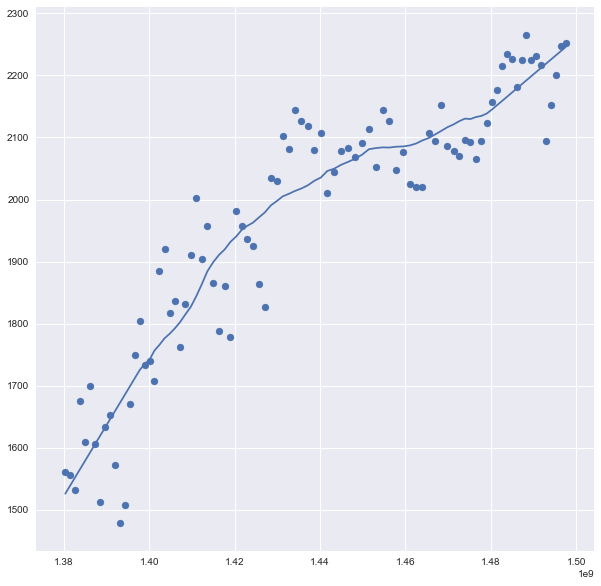

In [7]:
user = 'chenmark'
df = pd.read_sql("select oldrating, newrating, ratingupdatetimeseconds from user_rating where handle = '%s' order by ratingupdatetimeseconds" % user, con)

window = df.shape[0]/3
window += ((window%2) == 0)

sfilter = scipy.signal.savgol_filter(df.loc[:, ['newrating', 'ratingupdatetimeseconds']], window, polyorder=1, axis=0)

smooth_rating, time = zip(*sfilter)

plt.plot(time, smooth_rating)
plt.scatter(time, df.newrating)

# Features
* X total number of problems solved
* X mean, variance wrong tries on a problem
* X mean, variance of difference between rating and problem rating
* X mean, variance fo amt time between solves
* X \# problems solved $\geq$ some threshold
* X current rating
* X Number in contest
* **tags??**
* **hacks?**

##  Read in smaller dfs for performance

In [5]:
q = """ SELECT * FROM problem_rating """
problem_ratings = pd.read_sql(q, con)
valid_contests = set(problem_ratings.contestid)

problem_ratings.set_index(['contestid', 'problemid'], inplace=True)

In [78]:
user_rating = pd.read_sql("SELECT * FROM user_rating;", con)
user_rating['rating_change'] = user_rating['newrating'] - user_rating['oldrating']
user_rating_group = user_rating.groupby('handle')

In [79]:
cur.execute("""SELECT handle FROM handles;""")
handles = [x[0] for x in cur.fetchall()]

In [138]:
problem_tags = pd.read_sql("SELECT * FROM tags;", con)
problem_tags.set_index(['contestid', 'problemid'], inplace=True)
all_tags = set(problem_tags.tag.values)

## Functions for getting various problem stats

In [155]:
def get_problemstats(sub, usr_rating):
    tagcounts = defaultdict(int)
    
    g = sub.groupby(('contestid', 'problemid'))
    nsolved = 0
    wrong = []
    ratings = []
    solvetime = []
    n_prac = 0
    n_cont = 0
    
    # ----------------------------------------------------------
    # For each problem the user solved
    # ----------------------------------------------------------
    # if we can't estimate ratings for a problem, for now just ignore them
    # (or--assume it's the same as the median of other problems that were done during this period??)
    for k, v in g:
        n_cont += 'CONTESTANT' in v.participanttype.values
        nsolved += 'OK' in v.verdict.values
        temp = list(v.verdict.values)
        wrong.append(len(v.verdict) - temp.count('OK'))
        
        try:
            matched_tags = problem_tags.loc[k, 'tag']
            for t in matched_tags:
                tagcounts[t] += 1
        except:
            pass
        
        try:
            solvetime.append(min(v.loc[v.verdict == 'OK', 'starttimeseconds']))
        except:
            pass
        
        try:
            ratings.append(problem_ratings.loc[k, 'problemrating'])
        except:
            pass
    solvetime.sort()
    timebetween = np.diff(solvetime)
    harder = sum(ratings > usr_rating)
    harder50 = sum(ratings > (usr_rating + 50))
    harder100 = sum(ratings > (usr_rating + 100))
    harder500 = sum(ratings > (usr_rating + 500))
    rating_diff = ratings - usr_rating
    
    ret = {'problems_solved': nsolved, # total number of problems solved
            'n_wrong_mean': np.mean(wrong),
            'n_wrong_std': np.std(wrong), # mean var of number of wrong tries on problem
            'rating_diff_mean': np.mean(rating_diff),
            'rating_diff_std': np.std(rating_diff), # mean, var of difference between user rating and problem rating
            'time_between_mean': np.mean(timebetween),
            'time_between_std': np.std(timebetween),
            'n_harder': harder, # number of harder problems than user rating
            'n_harder50': harder50,
            'n_harder100': harder100,
            'n_harder500': harder500,
            'n_contest': n_cont,
           }
    for t in all_tags:
        ret[t] = tagcounts[t]
    return ret

In [156]:
def get_training_data(submissions, user_rating, max_time_elapsed):
    data = []
    contest_starts = []
    g_contest = submissions.loc[submissions.participanttype == "CONTESTANT"].groupby('contestid')
    
    # for each contest
    for k, v in g_contest:
        contest_start_time = min(v.starttimeseconds)
        contestid = v.contestid.values[0]

        if contestid in valid_contests:
            contest_starts.append( [contestid, contest_start_time] )
            
    for cid, ctime in contest_starts:
        try:
            usr_rating_smooth = user_rating.loc[int(cid), 'smooth_rating']
        except:
            continue
        df_train = submissions.loc[np.logical_and(submissions['starttimeseconds'] < ctime, submissions['starttimeseconds'] >= (ctime - max_time_elapsed) ) ]
        
        x = get_problemstats(df_train, usr_rating_smooth)
        x['rating_change'] = user_rating.loc[int(cid), 'rating_change'] 
        x['rating_change_smooth'] = user_rating.loc[int(cid), 'smooth_rating_change'] 
        x['contestid'] = cid
        x['contesttime'] = ctime
        x['user_rating'] = user_rating.loc[int(cid), 'oldrating']
        x['user_rating_smooth'] = usr_rating_smooth

        data.append(x)
    
    return data

In [157]:
def smooth(u_rate):
    window = u_rate.shape[0]/3
    window += ((window%2) == 0)
    if window < 2:
        return

    sfilter = scipy.signal.savgol_filter(u_rate.loc[:, ['newrating', 'ratingupdatetimeseconds']], window, polyorder=1, axis=0)

    smooth_rating, _ = zip(*sfilter)
    smooth_diff = np.diff(smooth_rating)
    
    # remove the first contest, we have no info on rating change here since CF assumes everyoen starts at 1500
    df_usrrate.drop(df_usrrate.index[0], inplace=True)
    df_usrrate['smooth_rating_change'] = smooth_diff
    df_usrrate['smooth_rating'] = smooth_rating[1:]
    
    
    
#    plt.scatter(u_rate.ratingupdatetimeseconds, smooth_rating)
#    plt.scatter(u_rate.ratingupdatetimeseconds, u_rate.newrating)

In [137]:
for i, h in enumerate(handles):
    if h == 'anta':
        print i
        break

59


In [158]:
from os.path import exists

# params
filename = 'training_linear_regression_smooth.csv'
maxtime = 30 * 24 * 3600 # number of seconds in a month
lastidx = 0

for i, h in enumerate(handles[lastidx:]):
#    if i%10 == 0:
    print lastidx+i, h
    df_usrsub = pd.read_sql(""" SELECT * FROM submissions WHERE handle = '%s'; """ % h, con)
    df_usrsub.is_copy = False

    #df_usrrate = pd.read_sql(""" SELECT * FROM user_rating WHERE handle = '%s'; """ % h, con)
    try:
        df_usrrate = user_rating_group.get_group(h)
        df_usrrate.is_copy = False
        df_usrrate.set_index('contestid', inplace=True)
        df_usrrate.sort_values('ratingupdatetimeseconds', inplace=True)
    except:
        pass

    smooth(df_usrrate)
    
    data = get_training_data(df_usrsub, df_usrrate, maxtime)
    data = pd.DataFrame.from_dict(data)
    data.is_copy = False
    data['handle'] = h
    if exists(filename):
        data.to_csv(filename, mode='a', header=False, index=False)
    else:
        data.to_csv(filename, mode='a', header=True, index=False)

0 tourist
1 LHiC
2 Petr
3 ainta
4 Um_nik
5 W4yneb0t
6 RomaWhite
7 moejy0viiiiiv
8 I_love_Tanya_Romanova
9 Zlobober
10 -XraY-
11 izrak
12 vepifanov
13 TakanashiRikka
14 bmerry
15 al13n
16 Merkurev
17 TankEngineer
18 Shik
19 V--o_o--V
20 y0105w49
21 jiry_2
22 zemen
23 cubelover
24 cki86201
25 matthew99
26 scott_wu
27 Alex_2oo8
28 xyz111
29 SirShokoladina
30 AlexDmitriev
31 jcccccccccccccccccccccsb
32 kcm1700
33 halyavin
34 qwerty787788
35 PavelKunyavskiy
36 mnbvmar
37 dotorya
38 ershov.stanislav
39 rng_58
40 subscriber
41 Radewoosh
42 YuukaKazami
43 black_horse2014
44 yosupo
45 ecnerwal
46 semiexp
47 sd0061
48 waterfalls
49 ACRush
50 Burunduk1
51 SpyCheese
52 uwi
53 Gullesnuffs
54 lewin
55 rowdark
56 tomasz.kociumaka
57 Xellos
58 LayCurse
59 anta
60 niyaznigmatul
61 sdya
62 Endagorion
63 drinkless
64 gs12117
65 fqw
66 Belonogov
67 muratt
68 MainDullMoeHand
69 aid
70 yeputons
71 GlebsHP
72 enot110
73 Kostroma
74 yutaka1999
75 DemiGuo
76 snuke
77 Chmel_Tolstiy
78 liymsheep
79 Nezzar
80 Rey

638 ValenKof
639 stringstream
640 Accelerator_916852
641 AndreiNet
642 GentleSmile
643 Giraffy
644 Melnyk
645 Sankarea
646 m4ddie
647 mislav
648 NuM
649 SoroushE
650 arseny30
651 hzt1
652 yaro
653 cnjzxy
654 linkct1999
655 zigui
656 .0.
657 Scorpy
658 StefanoT
659 kefaa
660 yoshinoprpr
661 I_love_PHP
662 ___LH
663 ir5
664 jhn333
665 marcorezieho
666 zouxun
667 Imba
668 MakeYanGreatAgain
669 evil666man
670 Smit
671 sotrqz
672 Remilia-Scarlet
673 KOTEHOK
674 edorundo
675 orzsd0061
676 xuhaike
677 rudy102
678 SCUTE
679 akashdeep
680 duyboy135
681 rais.fathin38
682 Folorn
683 Motarack
684 Semenar
685 Xylofo
686 Sereja
687 azizkhan
688 mrNobody
689 Chelly
690 Smylic
691 lydrainbowcat
692 JustN
693 Solaris
694 alecsyde
695 kliu31415
696 senek_k
697 xorfire
698 Neroysq
699 abyssmall
700 razia_sultana
701 ufo
702 williamhu08
703 rdfz_yjy
704 k21
705 rudradevbasak
706 ch_egor
707 FreeMoneyCity
708 Gomhog
709 Life_is_like_a_boat
710 MikhailRubinchik
711 Oleg_Smirnov
712 jiangshibiao
713 Dembel
7

1243 akashin
1244 murphy
1245 t90tank
1246 zlzmsrhak
1247 Nekosyndrome
1248 Victor
1249 akhtyamovpavel
1250 igogo
1251 lyy
1252 pvs
1253 thinfaifai
1254 tigvarts
1255 tomekkulczynski
1256 Arpa
1257 bekzhan29
1258 elsantodel90
1259 jinzhao
1260 tckwok0
1261 thocevar
1262 zscefn
1263 Eledven
1264 J_X
1265 glebushka98
1266 liouzhou_101
1267 rcx92
1268 vitar
1269 yjq_naive
1270 DexTrom
1271 Flandre_Scarlet
1272 Gyosh
1273 JavaInTheSouth
1274 Kujou_Karen
1275 alexey.enkov
1276 keivan
1277 rizar
1278 yzyz
1279 LGM
1280 Xnewfolder
1281 a58
1282 horseleat
1283 ydc
1284 MissMyDearest
1285 Remarque
1286 Reshetnikov_Ivan
1287 nvilcins
1288 IIIIIIIIIIIIIIIII
1289 Sammarize
1290 nacisey314
1291 xhsong
1292 Artem_kh
1293 Avitella
1294 Namnamseo
1295 dkirienko
1296 freopen
1297 Mikan_Tsumiki
1298 Qwaz
1299 biGinNer
1300 gjh
1301 viv001
1302 GILGAMESH
1303 klamathix
1304 Elshiko
1305 GARNETCROW_a.k.a_hhanger
1306 ardiankp
1307 footo
1308 lajiniunai
1309 lbn187
1310 mynameisverylong
1311 vici
1312 zano

1818 Kamilot
1819 Ryan_MuQ
1820 greatwall1995
1821 gty3296
1822 guliashvili
1823 helThazar
1824 jki14
1825 magician_14312
1826 nigus
1827 pauldb
1828 robinyu
1829 shevk
1830 shivamkakkar
1831 tapasjain
1832 triploblastic
1833 542395329
1834 VAVAvile
1835 Valaky
1836 kobae964
1837 LoveYayoi
1838 YerzhanU
1839 choice
1840 kmxyvb
1841 kodek.sh
1842 permin
1843 riantkb
1844 whalyzh
1845 Amirnasr
1846 Ketsui
1847 Lepton_s
1848 RostVel
1849 Solo
1850 TheWishmaster
1851 WanderingID
1852 Wuvin
1853 avm
1854 azaky
1855 ika
1856 jkxing
1857 kimiyuki
1858 octopuses
1859 pythonpro
1860 zhsh
1861 zrz1996
1862 Ali.Sh
1863 PauGra
1864 Touma-Kazusa
1865 cebrusfs
1866 lagoon0o0
1867 lnjlnj
1868 seanwu
1869 tworuler
1870 GoogleBot
1871 NEIL74
1872 Ownz
1873 TheSkyFucker
1874 WAF
1875 ZhouRunlong
1876 anewhandle
1877 carabet.cosmin
1878 fanzhirui
1879 hu19921011
1880 laoriu
1881 saharshluthra
1882 tataky
1883 teja349
1884 touristv2
1885 747929791
1886 PhamQuangHuy
1887 darkshadows
1888 forest
1889 loveli

2391 lulitao1997
2392 m.sewcio
2393 mister_dudec
2394 muliguishou
2395 pkq2010
2396 praran26
2397 sensei11
2398 super_cdd
2399 timics23
2400 wanbo
2401 win_ay39
2402 xiqiao
2403 yum
2404 zhouxingxing
2405 Conscious
2406 Farhit
2407 Hadi_Asiaie
2408 Navick
2409 Sun_For_Life
2410 Velixa
2411 Velter
2412 anubhav94
2413 bartek95
2414 imaxblue
2415 kefir
2416 le_code
2417 szszsz
2418 weekend1997
2419 zhongzihao
2420 DiegoCR
2421 I_love_a0666
2422 Kerim.K
2423 KevinTan
2424 RemmargorP
2425 SakurakoujiRuna
2426 TLERush
2427 ctunoku
2428 foreverbell
2429 kormyshov
2430 miagkov
2431 moinul.shaon
2432 pawelwa111
2433 shiva_r31
2434 sk_aswd
2435 squee_spoon
2436 steiner
2437 teoionescu
2438 wyfengers
2439 I_will_win_a_div1_round
2440 M.D.L
2441 Naij
2442 __LH
2443 andrewchen
2444 asalwaysdontbeahero
2445 gainullin.ildar
2446 hanfei19910905
2447 ingress
2448 qazwsxedcrfvtg14
2449 sajal_
2450 sazerterus25
2451 stonepage
2452 tfg
2453 timl
2454 vient
2455 AnotherOneRandomGuy
2456 BillXu2000
2457 INV

2962 3chenzhehuan
2963 657906231
2964 ChuYuxun
2965 CyberQuantum
2966 Kreyyy
2967 LeMieux
2968 SA_glory
2969 Yengtan
2970 _ami
2971 ajjack999888
2972 awc
2973 fahrbach
2974 fengsuiyan
2975 mamekin
2976 orzkac
2977 salex
2978 ACalvin
2979 BlinkingStar
2980 H0ngJun7
2981 Heisenbug
2982 delta_4d
2983 gbarto
2984 jerjerinmylefthand
2985 lizi_lzy
2986 lyk248289469
2987 mfv
2988 quyse
2989 timgaripov
2990 tjw_boyfriend
2991 vsp4
2992 waerlawson
2993 windsfantasy6
2994 xyz1234
2995 Alladdin
2996 Bugday
2997 JohStraat
2998 Ra8
2999 RamTararam
3000 Saat
3001 V-Sat
3002 aquatic
3003 bukefala
3004 gafeol
3005 ielenik
3006 lys1280023
3007 nims11
3008 ouch__casquinha
3009 raihatneloy
3010 sereja589
3011 sevenzero
3012 timothygk
3013 wilcot
3014 yanshuyi
3015 Archazey
3016 Hirasawa_Yui
3017 Leymore
3018 Lusajfer
3019 New_God
3020 NotEvenWrong
3021 Nozdormu
3022 Slevin
3023 Te4NIK
3024 abhi1agarwal
3025 brycesandlund
3026 c_on
3027 chychmek
3028 darrenhp
3029 fleimgruber
3030 forever97.
3031 koderlia

3539 sparik
3540 tian
3541 whybert
3542 ItcanHalal
3543 Kharybin
3544 MashiroKing
3545 NagiNikaido
3546 Saeed.Sryhini
3547 Sunar
3548 U6121071173
3549 a654889339
3550 b92paul
3551 fsps60312
3552 godjersavestheworld
3553 gregorinio
3554 hzfan
3555 inutard
3556 olage
3557 smahdavi4
3558 takamoto
3559 twj1993
3560 ypavel31
3561 zas409257934
3562 zhyang
3563 Alexa2001
3564 Domire
3565 Eragon
3566 LGWLGWLGW
3567 Too_lazy
3568 asterius
3569 avictor2010
3570 ayakut
3571 dark_n8
3572 kolina
3573 shjj
3574 ucfpt
3575 whitebai
3576 xht13127
3577 111lll1l1l
3578 844122492
3579 BlackTools
3580 Boxer
3581 DKarev
3582 MLins
3583 Mikuri
3584 Naduxa
3585 Raynger
3586 Yukikaze
3587 _Gewery_
3588 amankedia1994
3589 andrewgark
3590 bluemmb
3591 codexile
3592 fanhqme
3593 hoangdai
3594 igor.glushkov
3595 krinkin.m
3596 kshj78
3597 lunawyll
3598 siyavash
3599 sorry_quailty
3600 tehqin
3601 white_cobra3
3602 2016
3603 Alpha_Q
3604 Cth1999
3605 Ixanezis
3606 Jakube
3607 Joshua_Bright
3608 Petrist
3609 Relax


4114 luvlubb
4115 pt1989
4116 sampriti
4117 songman
4118 tanzon0xA5
4119 tnbt
4120 vanogam
4121 yashkumar18
4122 zMy
4123 zyeric
4124 -Tachibana_Kanade-
4125 AStepanov
4126 Barbossa
4127 Birjik
4128 Chenghiz
4129 For_the_Hope
4130 Harry.Guo2012
4131 I_Love_Phan_Trinh
4132 LLI_E_P_JI_O_K
4133 Liaksiejka
4134 MaryamG
4135 Megaminx
4136 PlayfulPanda
4137 StillFantasy
4138 ajkrish95
4139 axs
4140 jackraft
4141 jererereremy
4142 kfx
4143 loushengyuan
4144 one_more_min
4145 pyrexshorts
4146 sbansalcs
4147 shjgkwo
4148 tiirz
4149 yanjieru
4150 644262163
4151 EarlOfDitches
4152 FZU_NuclearWeapon
4153 Noobgam
4154 RedStar_13
4155 RoBa
4156 Valentin_E
4157 grandrogue
4158 hotwater
4159 house1993
4160 jaguar1996
4161 lucyfer
4162 lxyxynt
4163 mr.dudec
4164 orlov
4165 seraph1212
4166 shyao
4167 sskolot
4168 techwiz911
4169 xiper
4170 -Emilchess-
4171 Aaron.H
4172 Alexey
4173 BelovP
4174 Geralt18
4175 LoveCJ
4176 Timo
4177 Vladl1313
4178 YNote0621
4179 _threat_
4180 accelerator
4181 alwayswimmin
41

4676 tarang1610
4677 wildeyes
4678 zhangxiaohao
4679 Alireza
4680 EJG
4681 Hayama_Hikari
4682 HighFlow
4683 JeffreyLC
4684 M18-HellCat
4685 Onlylonely
4686 PM2.5
4687 SU-100
4688 ShineCheng
4689 SnowyJune
4690 VOIAFBR
4691 WiBk
4692 akshay_miterani
4693 boook
4694 farmersrice
4695 fishbaba
4696 hybrid
4697 koganeser
4698 mohamadkar
4699 newbiek92
4700 ppfish45
4701 qscqesze4
4702 reccy168
4703 repeatuntil0
4704 thamyin1
4705 xiaohao123
4706 1rw6
4707 ACLhj
4708 AK93
4709 Dadaxon
4710 E869120
4711 Jonis
4712 KArs
4713 MariaIzobava
4714 Nurlykhan
4715 Solo322pro
4716 Vendetta.
4717 andytyk
4718 atol
4719 freepvps
4720 fromWork
4721 gleb.astashkin
4722 helio
4723 kirill.dragalov
4724 kyleliu
4725 laablckdae
4726 laurageorgescu
4727 lchacon
4728 maximkoval
4729 nike0good
4730 peehs_moorhsum
4731 thunderking
4732 vasya12345
4733 zhudhjen
4734 zzblack
4735 IanCastro
4736 RainDreamer
4737 RockyB
4738 Tudor
4739 Wolfje
4740 abgnwl
4741 buxiaoyu
4742 edisonhello
4743 felixba2
4744 gzz
4745 hech

5234 ymlin
5235 z1401074
5236 994495jj
5237 Ajatar
5238 Divanshu
5239 Doopy
5240 DoubleLu
5241 E.Space
5242 FallDream
5243 GemeneN
5244 Hedayet
5245 Jovfer
5246 Koblyk
5247 LWMAN
5248 NURx2
5249 SSJJ
5250 Shurikenger
5251 Stebaev
5252 TranThuyLuc
5253 XuYipei
5254 Yuliy
5255 Yury_Bandarchuk
5256 ZYF-ZYF
5257 foolishhmy
5258 fresher96
5259 fshp971
5260 huhuxue
5261 izuru
5262 kbnzlevy
5263 lzl65829
5264 m_bezrutchka
5265 morojenoe
5266 norgevz
5267 qwsqwa
5268 starry_tales
5269 stdioH
5270 vuonghy2442
5271 Applejack
5272 DaemonGinger
5273 EZ_fwtt08
5274 Fedyarer
5275 Grandpa
5276 ICouldHaveLied
5277 Kacey
5278 RDimon2912
5279 TylerX
5280 Veag
5281 Zarxdy34
5282 ashpsycho
5283 baumanec
5284 bichen
5285 cristb
5286 denote
5287 derkenbaev
5288 fanzhengchen
5289 filo
5290 giongto35
5291 guizeyanhua
5292 hsnprsd
5293 ilianolhin
5294 mbfilho91
5295 milosz
5296 naveen_iitr
5297 pavlovv
5298 shivatejesh
5299 sy15
5300 valeriy.stromov
5301 zDule98
5302 Archies
5303 Bashuk
5304 CHENXI1
5305 CHNZY

5807 dreamzor
5808 kobe24
5809 ma5termind
5810 maha1192
5811 rezwan4029
5812 sdedalus
5813 tlwpdus
5814 todo
5815 walkhorse
5816 wcwswswws
5817 zhuaiballl
5818 AutSky_JadeK
5819 Auto
5820 Dshavn
5821 JSZKC
5822 Nomad
5823 Syiml
5824 VinyleEm
5825 ashu1461
5826 chpzcc
5827 dddxhh
5828 jozef.brandys
5829 pengshangfu
5830 t.muttaqueen
5831 tgoulart
5832 420
5833 HunDunDM
5834 Leonardo_Blanger
5835 Mamedov
5836 Nutnut
5837 PikMike
5838 dashashi
5839 fedorov2602
5840 foolifish07
5841 gongzhi
5842 irakli_p
5843 jaina
5844 kellymilla18
5845 luyangliu
5846 nathanielbarshay
5847 rmtd99
5848 sahedsohel
5849 sz1231
5850 vance
5851 vishalgupta
5852 xenocide
5853 2011022631
5854 PolyProgrammist
5855 Purpleslz
5856 awaykened
5857 dtnar
5858 ericpts
5859 fuwutu
5860 graves
5861 knock-knock
5862 misael
5863 misaka_mikoto
5864 nagibator-228
5865 nuit
5866 pc1ang
5867 raiders
5868 sinhashubham95
5869 tbw1033
5870 Antandard
5871 Bo_Odya
5872 Ktya_59
5873 Mario88
5874 SnapDragon
5875 Yuno
5876 for_the_mon

6379 crystal_mis
6380 gentoo_root
6381 halilozanakgul
6382 koyaaniqatsi
6383 lyyllyyl
6384 miaowu
6385 nima
6386 rogeri
6387 scinart
6388 sister_what_hate_most
6389 thomount1998
6390 wanghang
6391 wwt1024
6392 xlc2845
6393 Created_equal
6394 D_style
6395 DenXX
6396 ElBatanony
6397 Enterpaise
6398 Grevozin
6399 Qiang_cx
6400 TheLegend27
6401 Wielomian
6402 akaki
6403 ayang
6404 hnshhslsh
6405 krdln
6406 kshitij_jain
6407 lrahul7
6408 m.kashichkin
6409 majd.gda1
6410 oswww
6411 romanasa3
6412 shubhamgarg1
6413 sublimation
6414 tavyrikov
6415 utsav.delhi2
6416 xonatius
6417 yejinru
6418 Hieu
6419 Poaceae
6420 Uncia
6421 Zpw987
6422 a180285
6423 akshay1994.leo
6424 arif.ozturk
6425 badpoet
6426 danilodnr2
6427 gaurav708
6428 kyonrevens
6429 madxmad
6430 matejbalog
6431 pro100leo
6432 rhezo
6433 ts09
6434 vitux
6435 xfhcx
6436 zyoohv
6437 3booood
6438 CisnijAsdPawel
6439 IWillBeRed
6440 Matjaz
6441 Phyto
6442 ToMoClone
6443 Xer0
6444 autotaker
6445 emm
6446 femsub_a
6447 goooooooopan
6448 j

6952 fpavetic
6953 haruki57
6954 hyunmin
6955 lyonlys
6956 orz_wmg
6957 pankaj_gudlani
6958 peaceful_warrior
6959 qw842
6960 rodz
6961 simenl
6962 suxing11
6963 tinytree
6964 wp32pw
6965 xiefubao
6966 yge
6967 zplinti1
6968 AdilkhanKo
6969 DARIUS_XIX
6970 Dekacc
6971 LebronJames
6972 Moskupols
6973 NOIRP
6974 Narg
6975 NovChaos
6976 XC_KiwiCherry
6977 babacry
6978 charity
6979 comunodi
6980 junis3
6981 k_sudharsan
6982 scau201330340113
6983 semicolon29
6984 shad2w_walker
6985 vers
6986 wust_hee
6987 x3n
6988 xwind
6989 zssky
6990 13rj1115
6991 Delta003
6992 Euron
6993 Mes
6994 SatsukiRin
6995 _skip_
6996 all_out
6997 codingrabbit
6998 csegura
6999 diver_ru
7000 jseo
7001 mmaks
7002 ooOOOOoooOOOOo
7003 randygx
7004 sak_agg
7005 sanjana_chatterjee
7006 sharat1105
7007 stony_oi
7008 stostap
7009 tamirOK
7010 tosaka2
7011 wmg_1001
7012 wokop22
7013 0010
7014 CAPITAL
7015 ELPistolero
7016 HeZiying
7017 LinJiYuan90
7018 MVesterli
7019 Mixf
7020 Ogel777
7021 Paradox1
7022 Scau-Ly
7023 Titandr

7518 portal
7519 stoyanovd
7520 taurus123
7521 yang_yue
7522 yujingping
7523 GeLo
7524 Grandfather_Mr.Fly
7525 I_love_47
7526 JOZHEG
7527 Octavian_August
7528 Tigran_H
7529 TobiichiOrigami
7530 VUAcoder
7531 adityaakash
7532 andrei-alpha
7533 bluemao
7534 cilebritain
7535 erdenebayr_d
7536 ijnhtrgdew
7537 kitayuta
7538 kkyuggu
7539 manish05
7540 marekzby
7541 mike239x
7542 nijinan
7543 rssj
7544 salikhov
7545 sandeep.iiit
7546 stapanulocu1
7547 toilingcow
7548 wzc1995
7549 x-ray
7550 1243France
7551 Aidin
7552 AlaZh
7553 EZ_zby
7554 FunkyCat
7555 I_love_Cristina_Melnic
7556 Kekmaster
7557 LvChaoShuai
7558 NBAH
7559 Nodirbek_uniquE
7560 NutelIa
7561 Rainto96
7562 Reol
7563 a275909044
7564 ahng_hue
7565 bangbarang
7566 brainstorm
7567 f52985
7568 fakehesap
7569 haitian
7570 hj929
7571 kek1234
7572 misis_Sergey_Ilyuhin
7573 nellex
7574 neverlandhacker
7575 omidazadi
7576 philippica1
7577 pi37
7578 poegva
7579 s_z_l
7580 sweetdum
7581 ustimaw
7582 v_guihom
7583 vtantia
7584 wolfib
7585 won

8080 Togop
8081 akdal
8082 akill3r
8083 ashkan
8084 brioso
8085 caojiangxia
8086 chensongsong
8087 chirs241097
8088 dqhungdl
8089 guguli
8090 halfyarn
8091 jhfjhfj1
8092 kt-9
8093 l21561
8094 linzy
8095 memeda
8096 oimotor
8097 redrover555
8098 seeeeeeven7
8099 sunjieeee
8100 tkgnus
8101 wcr1996
8102 xiaohao321
8103 z123z123d
8104 zjutlgw
8105 23333333333
8106 BrightestSirius
8107 Cr0wley
8108 Denyhoof
8109 Haskell_loves_me
8110 Mikagura_Seisa
8111 Mrone
8112 Nekola
8113 Puella
8114 Ruki
8115 ShiXingxing17
8116 Tayama
8117 Wheeler
8118 andypanda
8119 ankeshgupta007
8120 asantonenko
8121 c0d3junki3
8122 dprokopenko
8123 fsa4
8124 hi_im_jeremy
8125 liangjingtao
8126 loli
8127 mhy54321
8128 minimator
8129 nukeykt
8130 rajmanvar
8131 round_0
8132 ryad0m
8133 srdr38
8134 tansongsong
8135 telgipz
8136 tungnt_580
8137 western_theory
8138 zy1997
8139 zzxchavo
8140 Alick
8141 AlphaStream
8142 Dako_Shen
8143 Dias
8144 FunnyFoX
8145 Goldensea
8146 HiaHiaHia
8147 HouJP
8148 Kentauros
8149 Lvat2000

8646 sss2391267
8647 stevenwjy
8648 sulume
8649 suyufeng
8650 vadi
8651 victor2992
8652 --OvO--
8653 0123456789
8654 Amuro_Tashi
8655 BlackJJ
8656 Daumilas
8657 Guliash
8658 HackMeOrGetHacked
8659 JsimIdziemyNaASD
8660 Magda95
8661 Megumi233
8662 Nemer_Was_a_Hero
8663 RatingBooster
8664 SPAND
8665 Saturday
8666 TangSiLoveDingYing
8667 Terrorist_Usaty
8668 The_Meme_Sculptor
8669 VictorForbes
8670 Yermak0v1
8671 __PLEASEDONTHACKME__DSB
8672 alibi
8673 ars-kro
8674 cheezer94
8675 chiyahoho
8676 courtesy
8677 cwz
8678 ehsanoo
8679 erb666
8680 fangshifu
8681 hzhwcmhf
8682 imzhazha
8683 invincibles
8684 jhhan94
8685 kevin20x2
8686 lisik
8687 lqdbb
8688 milo
8689 miraziz
8690 mojo7054
8691 niobium
8692 nkyrt
8693 o.0
8694 onjo0127
8695 rajuknit
8696 ryry56
8697 salnikov
8698 sanket1729
8699 tec
8700 thorikawa
8701 xieshiqi
8702 xptree
8703 y553546436
8704 ._.
8705 1dayac
8706 A_Ballpoint_Pen
8707 AiyokunoEustia
8708 Algorism
8709 BigBigBigDevil
8710 ChaRiL
8711 Erinnerst_du_dich_noch
8712 Far

9199 hoshi524
9200 jugnu
9201 kirill
9202 kzvant
9203 mad.exe
9204 mateuszdanowski
9205 mobius
9206 naveen.learning
9207 nk1879570236
9208 nnandi
9209 osank
9210 pandazcy6
9211 primorial
9212 qazwsxedcrfv
9213 rajabell
9214 rationality
9215 sarcasm
9216 snow_lotus
9217 strawberry3.16
9218 testing_round
9219 tientmse610xx
9220 travm12
9221 winnerls
9222 wx2486
9223 xcszbdnl
9224 xinging
9225 yiyezhiqiu
9226 zld3794954
9227 20111114
9228 2011330300713
9229 Austria1
9230 Bakser
9231 Code_L
9232 DQQZK
9233 Darkhan
9234 Deebsy
9235 FarbodY
9236 FastYes
9237 Gaytrodex
9238 Hamada14
9239 HappyStars
9240 Hineven
9241 IneQualitY
9242 Kanaunara
9243 KobeBryant1994
9244 MakingMaker
9245 Minacor
9246 MockingHawk
9247 PCZ
9248 Radi4
9249 RatingBooster_2
9250 SDil
9251 TreeDiagram
9252 Vital1ty
9253 YHihi
9254 ZJUT_AA
9255 alhprp
9256 andrk
9257 big_dick
9258 boomshakalaka
9259 bright_moon
9260 codeJan
9261 d1xlord
9262 geroveni
9263 ipqhjjybj
9264 isaaccwoo
9265 it69
9266 jelly
9267 jooman
9268 jul

9763 LeKhacHuy08
9764 Mast3rmind
9765 PlausibleDeniability
9766 QLSpirit_005
9767 Ratuvog
9768 Reimu
9769 ShiXingxing20
9770 Sprite
9771 TAABAP
9772 TEEandMO
9773 Th_Ki_De
9774 Totktonada
9775 UESTC_Spartacus
9776 UESTC_XHXJ
9777 Zhi_Ma
9778 abc3141
9779 adrianvidal
9780 ahartik
9781 aneesh2312
9782 arystan_kalimov
9783 as277575
9784 bation
9785 bigoceanlhy
9786 buben
9787 charlie01
9788 chinh7
9789 eugene_lim
9790 forDiv2
9791 gshag
9792 hacker
9793 happyBirthDayBeni
9794 hodduc
9795 iceman_w
9796 king.marl
9797 like_wtf1
9798 lyhxh
9799 lzsz2012
9800 n1k1tung
9801 neu_tron93
9802 okko
9803 pablo.aguilar
9804 pocztapirxa
9805 riverman
9806 rng_85
9807 sequence
9808 serglag
9809 shr_zarkh09
9810 sight
9811 sunjie7
9812 tomciomistrzu
9813 tourists
9814 xxyyzz
9815 yassin-
9816 yujiping
9817 zeroxf
9818 zjnuvjudge1
9819 --Robot
9820 2bly
9821 Abaddon
9822 Al_Lynn
9823 ArrayAdvance
9824 CodeFast
9825 Conny
9826 Cyber
9827 DCN748
9828 DooIt
9829 FlaminRage
9830 FreePassword
9831 Gi1dor
983

10307 Bat-man
10308 CenariusXz1
10309 CooCoo
10310 HackMeAndGet100Points
10311 HassanAbadi
10312 HouJikan
10313 Jozik
10314 KanameMadoka
10315 L.A.C.
10316 Ljubitel
10317 LoveLiver_CatNote
10318 MISiS_Petrova
10319 MeFa
10320 MilkyHolmes
10321 Rafsan
10322 Safayat
10323 Universe_hcy
10324 ValeriaHil
10325 Zeroclock
10326 abcdabcd987
10327 bojan.serafimov
10328 bottle
10329 catlak_profesor_mfb
10330 dadoubi02
10331 daizhy
10332 dianbei_10
10333 domhow
10334 eagle93
10335 ffx9
10336 gy1010701318
10337 haicon232
10338 hardyyeh
10339 himeyouzhi
10340 i_love_gold_and_nt
10341 intgraph0
10342 kavinkumar
10343 killyou213
10344 konstantint
10345 kuangbin4
10346 kunkun220189
10347 lala
10348 lazzrov
10349 left_hand
10350 linyy
10351 liv_curious
10352 maddoctor2
10353 mhsekhavat
10354 miraliv
10355 naumazeredo
10356 nguyen_khanh_linh
10357 pass_pretest
10358 pietrzkiewicz
10359 qiaorancomeon
10360 qyjubriskxp
10361 rajeshkumarsinha12
10362 rfs
10363 saurabhsuniljain
10364 seif
10365 shato
10366 

10831 Blazon
10832 Cardi
10833 ForPan
10834 Gang_Chen1
10835 Helga
10836 HououinKyouma
10837 Inner_x_Peace
10838 Irisviel_von_Einzber
10839 Konon
10840 Krarl
10841 MeoMeoo
10842 Mohamed.Bassem
10843 NewGYM
10844 PureAwesomeness
10845 QiuPassGoogle
10846 Ram.te
10847 SegmentationRight
10848 Sholja7
10849 SmirnovBoris
10850 T_1610
10851 Waffchenko
10852 WeMadeFox
10853 WhoTheHellIsMe
10854 __RiverLoong
10855 aditya1995
10856 ahmed_kamal1432
10857 altertain
10858 amirb
10859 amitverma14ster
10860 beautiful
10861 c0d3r
10862 catawar2
10863 cmonkey
10864 gnomnain
10865 homelesser
10866 hpinto
10867 iBlackShadow
10868 ichigo
10869 jan25
10870 jys123
10871 kiber
10872 kyparus
10873 maplefallfrost
10874 marschenly
10875 mjchao
10876 mlzlt
10877 monsoon
10878 naijeuohz
10879 pakh
10880 playitcool
10881 ploym
10882 shiyuan
10883 tantunovic
10884 teoy
10885 thienanh1999
10886 tohdon
10887 too.ez.to.code
10888 tottoripaper
10889 ulyanick
10890 valikluks1995
10891 vdragon4774
10892 wangjl_sdu
10893

11359 vegetable_ploym
11360 whatsgoingon
11361 whbm
11362 wither
11363 wwt100
11364 xRoms
11365 xiaoxin3
11366 ymondelo30
11367 ytrab
11368 yunyin
11369 yzcqqq
11370 zhouyiself
11371 zlc
11372 zlctmp
11373 -Invoid
11374 Ails
11375 Anja
11376 CarlyPlus
11377 CodeAce
11378 ConLonCon
11379 ConfidenceConstructor
11380 GLSilence
11381 IAMABRONY_Deal_With_IT
11382 ISIS_fighter
11383 Jigers
11384 KawaiiDragon
11385 LSR
11386 Lugera
11387 M.E.O.W
11388 Mavzes
11389 Nozim
11390 Petrus
11391 Praesidio
11392 QLSpirit_009
11393 RaceBug
11394 RealCow
11395 Troy1118
11396 UESTC_Mephisto
11397 Ufotalent
11398 Universez
11399 Yukari
11400 alaala
11401 asd130530
11402 ashes.0
11403 Ziklon
11404 codingMachine
11405 combint
11406 domhowc
11407 gaofushuai
11408 gflyingcat
11409 gzp95
11410 hijacker
11411 hope1
11412 hopkins
11413 hsk
11414 ilovepink
11415 inapt
11416 jyoteshrc
11417 kachayev
11418 kdedovich
11419 liuchuang
11420 lzqxh2
11421 nullzero
11422 os_b
11423 oxidizer
11424 pashakovalenko
11425 pe

11889 jmk
11890 just_tourist
11891 kikosovich
11892 kreet
11893 lantimilan
11894 lbz007
11895 lijian430421
11896 limuyang01
11897 loveSakura
11898 lyztyj
11899 ml_mhl
11900 mme
11901 mynameisveryshort
11902 nanae772
11903 nnareshkrishna
11904 poao900
11905 rob.kh
11906 roxion1377
11907 shyamkb
11908 sickness
11909 slim_lee
11910 spaul100
11911 spectrums
11912 suzu
11913 tavo92
11914 team002
11915 tempid
11916 threepipes_s
11917 vou-vou_posoni_polehche
11918 wangshufeng
11919 winking
11920 wwt65536
11921 xc_down
11922 yasser_adel
11923 zhouyy
11924 zwjytt
11925 4everAlone
11926 59TUGE
11927 AlexandraLi
11928 Apoptoxin
11929 Azad_Yusupov
11930 Brains_Beldon
11931 Conan630
11932 DarkEffect
11933 DarkZero
11934 Dremov
11935 Dshawn1
11936 FTDaddy
11937 Gleb_Kazantaev
11938 HerbertHair
11939 HimawariNoKyoukai
11940 Im_devil
11941 Itpossible
11942 L_at_BK
11943 Lich_Amnesia
11944 Lilk
11945 Mikhail_Amirov
11946 MrArM
11947 Newbie_Ghost_
11948 NurlashKA
11949 Pahom
11950 PeeNoise
11951 Pouriya

12416 lazzy
12417 lethanhhai
12418 luyun612
12419 lwc
12420 maagiline
12421 maicaifou
12422 mayankg2602
12423 oliver122333
12424 oyj9109KOR
12425 phoenix4830
12426 plokmijn
12427 promentol
12428 qteat
12429 raedselim
12430 random_y
12431 rohit_code
12432 rucwdp
12433 samarth_1996
12434 shengtao96
12435 spudimun
12436 srikkbhat
12437 sven
12438 svsfzhc
12439 swm8023
12440 sycbbq
12441 topskychen
12442 tpkwok
12443 ts16shuai
12444 ujraaja
12445 v11
12446 v_akshay
12447 wuhangewang
12448 xiaofan.mytifa
12449 zhangxiaoxiaohao
12450 zjwoody1
12451 zongbingwang
12452 .vince
12453 343649190
12454 907th
12455 BagInCode
12456 Corianderleaves
12457 Destinity
12458 DnS
12459 Elias
12460 Err0r404
12461 Final
12462 I_AM_BOSS
12463 KGenc
12464 Kardanil
12465 LimitSY
12466 MCoder
12467 NeverLand.Dai
12468 OMEGA_xuelanghu
12469 PhantomLancer
12470 SC_pRo_ION
12471 SlaMandor
12472 VictorWonder
12473 WABear
12474 WAF2
12475 WuDiWu
12476 Zuikaku
12477 _sceptile_
12478 a.kazimirov
12479 a.khoshghalb
12480

12947 noh4h_ss
12948 preeminenth
12949 qieqie
12950 rohitshah177
12951 rom_k
12952 sabbathist
12953 spandan611
12954 stosd0061
12955 suh_ash2008
12956 sweet_love
12957 testVim
12958 van_gogh
12959 vikhs_96
12960 vilnasta
12961 winsweet
12962 wmg_is_really_imba
12963 x4150
12964 xchernoff
12965 xiaoshua3
12966 yobobobo
12967 yoones.rezaei
12968 yours1103
12969 zgg
12970 zhengly123
12971 zhqc
12972 zzxzxzzxz
12973 -qqq
12974 101142TS
12975 3301
12976 AC_way
12977 Alain
12978 Alex342
12979 Artifere
12980 CCC
12981 CathyChen
12982 Ditwoo
12983 DoomzDay
12984 E.B.
12985 Electric-tric
12986 Et3rnity
12987 Exodia
12988 GalaxyH
12989 Gogeta4122
12990 GreenWorm
12991 HSJMDMG
12992 Hodobox
12993 IndexLibrorumProhibtorum
12994 Izaron
12995 Koreyoshi
12996 Lisz
12997 North
12998 Nuta
12999 OnlyTheStrongSurvive
13000 OnurYildiz
13001 PaiGuLong
13002 PrincessBubblegum
13003 R.Lee
13004 RodionGork
13005 SNMOJ
13006 SadBB
13007 Scrat
13008 StarEyes
13009 Thomas0726
13010 Tulchinskyi_Eduard
13011 YJWD


13481 yooo
13482 092000
13483 1067607
13484 1106100116
13485 294334714
13486 4ndypanda
13487 ACMega
13488 ACSquare
13489 BlinKer
13490 Bullbas
13491 DAYDAYUP
13492 DarthHayate
13493 Dima_qwer
13494 Duc_cmn_Le
13495 Ecthelion
13496 EndOfFile0608
13497 FreeCoding
13498 GuessEver
13499 HaveItAll
13500 I_Love_EEvilCatt
13501 I_love_alex256
13502 Light_Kiss
13503 Lolkekzor
13504 M.A.H.M.O.O.D
13505 MrBrionix
13506 Mukit09
13507 NotDefined
13508 Prakhar1509
13509 Roll
13510 Rusu
13511 SegmentationFault
13512 Sender
13513 Solitary
13514 TTFH
13515 Xinkai_Wang
13516 Zebra_Finch
13517 Zheng
13518 _spartan
13519 abbyy
13520 aldred
13521 ambling
13522 ayushtulsyan
13523 azurespace
13524 barty2
13525 bonfire
13526 bright_star
13527 clumsysniper
13528 crystal
13529 dianbei_04
13530 emonzhong
13531 gepard211
13532 grandvic
13533 gzh1994n
13534 hoco
13535 hustlike
13536 ibrohimislam
13537 igor.pisarev
13538 ikid.duc
13539 iron-man
13540 ivan.e.geffner
13541 jai_godara
13542 jionghehe
13543 kevinz
135

14003 HulkBuster
14004 ILARION
14005 ILOVEYY
14006 Isco
14007 KtlTheBest
14008 LelouchRiBritannia
14009 LowB
14010 Meternal
14011 Ololoshin
14012 PeterGriffin
14013 Pimpom
14014 Possessed_by_Phoenix
14015 Protess
14016 RoyZheng
14017 SaraGuru
14018 Senjougahara_Hitagi
14019 Seto_Kosuke
14020 SoSweet
14021 Taiga
14022 TearinFree
14023 UranusX
14024 Voleking
14025 Wetand
14026 ZJUT-Noresponse
14027 a4461494
14028 anders.westling
14029 anirudh.beria
14030 best.ua
14031 bitu
14032 bojomy07
14033 bpa_
14034 c175353
14035 chensqi
14036 chrome
14037 daftcoder
14038 david_942j
14039 donghao
14040 gaoxiang36999_A
14041 genadz
14042 gleiz
14043 gongbaoc
14044 goodoo
14045 gzh1997n
14046 haisesasaki
14047 hetong007
14048 hyplymac
14049 infinitelephants
14050 jayantjpr
14051 jqyjqyjqy
14052 jufusong
14053 justever23
14054 kevin71139
14055 kunaljain
14056 latika_22
14057 lauda
14058 lovelove95
14059 m.haghpanah
14060 maxim-m94
14061 mha_bd
14062 mobaizxy
14063 orzzgg
14064 overnight
14065 pauldiac


14531 lld
14532 lqw
14533 me999
14534 moyung
14535 mvl720
14536 norshtein
14537 pernay
14538 prithviraj7
14539 r2d2
14540 sebastianmualim
14541 takacsg84
14542 ulthril
14543 uncletom6
14544 woshibdl
14545 xuan.
14546 zxy_snow
14547 Djusa
14548 DmitriyIvanov
14549 Echo_key
14550 Ekaterina999
14551 Errathy
14552 Firebat
14553 Flyce
14554 IRLndis
14555 I_Love_Misaki_Mei
14556 Ivann
14557 JeffreyHui
14558 Katyia
14559 LOBANbI4
14560 NHDYC
14561 Nicolai_Kovrov
14562 PIAOYI
14563 QAQSheiLaiJiaoWoXuanKe
14564 Souling
14565 Suez
14566 Vaghar
14567 W_T_F
14568 YLAsce
14569 YuemingLi
14570 ZimMaxim
14571 _Katherine_J
14572 anardael
14573 astoninfer
14574 bhrzslm
14575 big_tomato
14576 boray
14577 cacyth
14578 cookieme
14579 dachunan
14580 dinnot
14581 eku
14582 ememak
14583 enesakdogan
14584 iamme181
14585 kadora
14586 karadza3a
14587 kliner
14588 lijianblv
14589 marsh
14590 mb1994
14591 mikhaelkh
14592 minhtung04042001
14593 mogambo
14594 nguyenvietkhanh
14595 nik123456
14596 njrafi
14597 pegas

15062 mitya52
15063 mustrumr
15064 poutiko
15065 retired2.0
15066 rpinto
15067 rwsrsx54gx
15068 sajad22
15069 schindlerlee
15070 sherry
15071 sorry-haghani
15072 status_x
15073 vadimkantorov
15074 vinod10
15075 vovinam
15076 wh2000
15077 xtu_free
15078 yakumolx
15079 zany4eg
15080 Artishok
15081 CST14-TZY
15082 D_StrawHat
15083 E_ThunDer
15084 Eculiwood
15085 FLOWMAN
15086 FORHAD-SUST-BD
15087 GT_18
15088 IrisM
15089 LobsterLord
15090 McCrea
15091 MonsterGentlemanLYP
15092 SNU
15093 TDLmstzaiyiqi
15094 YshrDbrn
15095 _MAXX_
15096 aeg43axiii
15097 ak.bewildered
15098 akshaygarg1995
15099 akvasha
15100 anmolr7
15101 ar4ebald
15102 aysonje
15103 brighterstill
15104 calflove
15105 cbgiri_001
15106 chiehmin
15107 code_and_hack
15108 cryspharos
15109 ctg
15110 cty002718
15111 dakdima
15112 dfk
15113 eoy5ihz536
15114 halfo
15115 hua
15116 jkq247
15117 jumpwmk
15118 kylych03
15119 llyang
15120 lnuic
15121 lukecavabarrett
15122 masterwayne
15123 naughty
15124 phonix45
15125 pva10795
15126 renad

15589 Rpplusplus
15590 SSherry
15591 Senji
15592 ShweTheBae
15593 Silence.
15594 Sirojiddin
15595 SnowMyDream
15596 SofiaBalushka
15597 Timus96
15598 _____upsolver_____
15599 aBoyIsNoOne
15600 alepic
15601 andrey_andrukhovich
15602 antkhorin
15603 brando
15604 coder28
15605 cxjyx_xme
15606 eduarc
15607 fedorusov
15608 feng_bo_tian
15609 flushfile
15610 gaoyang
15611 harsh19
15612 honya121
15613 i101i
15614 im13
15615 kosakkun
15616 kshitij1114
15617 kw_udon
15618 mIXs
15619 maxpoops
15620 parina1
15621 shenben_WJ
15622 starwand
15623 storm95
15624 tapopadma
15625 tranhuy
15626 vivek51
15627 vvk
15628 wangyingxu
15629 xfause
15630 xiaoxinxin
15631 yangjun2
15632 Avq
15633 BruteMaster
15634 Cupcakess
15635 DonutsDose_
15636 Doratti
15637 Fedya001
15638 GQH123
15639 Iwaskid
15640 JIuMoH4uk
15641 KD35OKC
15642 Kewowlo
15643 Lancelot
15644 Luzan
15645 MIA_Rodney
15646 Mazeev
15647 MrYX-Z
15648 SidneyMars
15649 WID
15650 XelMed
15651 You_cant_guess_who_am_I
15652 Zander505
15653 Zander_Shah


16128 graphis
16129 jaybosamiya
16130 katnasun
16131 keyzhang
16132 kirill_mykhailov98
16133 kita_masa
16134 kujta1
16135 lastacmer
16136 littleMine
16137 lv_ye233
16138 mclegrand
16139 meoguru
16140 mint.mint
16141 okcd00
16142 one_last_time
16143 pswgoo
16144 rookie0521
16145 secretcoder1
16146 sevenzplus
16147 shenyunhan
16148 spiritual121
16149 sprade
16150 squarePenguin
16151 stareven
16152 suresh279
16153 takumi
16154 teochaban
16155 vidova
16156 wust_zhanpang
16157 xrav3nz
16158 xuanthuy_sp96
16159 youaremyangel
16160 yungchienliu
16161 zhuyaoyu
16162 zwt395081716
16163 594250
16164 8cbx
16165 987654321
16166 BlueHya
16167 Cactus_Irl
16168 ColorfulCookie_SPAnother
16169 Ghassan.Khazaal
16170 IvoryTower
16171 JZG
16172 M.Aladdin
16173 MeowMeow
16174 MoRandi91
16175 Naginchik
16176 ProLights
16177 STArtanis
16178 Tanmoy_Datta
16179 Thalia
16180 Wajeb
16181 Whiteknight4796
16182 Winnie_Pooh
16183 YJHX
16184 __master
16185 _victoria_
16186 a540524095
16187 ajmarin
16188 alpc32
16189

16643 xth1
16644 10142130236
16645 Bilime_Destek_Kesilmesin
16646 BishalG
16647 CMH
16648 CatCoder
16649 Helena
16650 Hustlan
16651 JoshuaCNF
16652 King_of_Tide
16653 LOGO5
16654 Leopard_KHTN
16655 OrzMuddleAlong
16656 Sloe
16657 Spartina
16658 Suichi
16659 Temych
16660 TooCrAzY
16661 Valera_Rezz
16662 Vicmal
16663 Vladimir_Lenin
16664 Xuh723
16665 ZaakDov
16666 abhid95
16667 adilkhan
16668 ayush07
16669 beyhhhhh
16670 caoyuan9642
16671 cyendra
16672 cyl1
16673 delphifirst
16674 dennisdaslim
16675 dounima
16676 drd93
16677 elin42
16678 fzszsc
16679 george24601
16680 gg.vdn1999
16681 hackr32
16682 hangto
16683 hustsxh
16684 hwcsrj
16685 hxhl95
16686 hxywtc
16687 krylovgv97
16688 lais
16689 llyyff
16690 luizribeiro
16691 master.milind
16692 max777alex
16693 mdzahidh119
16694 mirak94
16695 nenik234
16696 qhung49
16697 slash
16698 tvhong
16699 varduhi.yeghiazaryan
16700 westu
16701 zgf
16702 zhuangzhixiaohao1
16703 Arithmophobia
16704 BMan
16705 ChillingDream
16706 DIII
16707 Demasi
16708 

17174 sunhaowen123
17175 tempforwhat
17176 thanhld94
17177 tkaneko
17178 touya.akira
17179 vuduclong0309
17180 xormrr
17181 yesh233
17182 yinthewater
17183 z52528
17184 zhusha11
17185 2279544550
17186 A.I
17187 Boring
17188 Chengi
17189 Gandzy
17190 GiveMeATicketToChildhood
17191 Govikhuu
17192 I.Salim
17193 I_LOVE_
17194 Itakua
17195 LabibDoesntCare
17196 MastaOfDisasta
17197 Serzhan
17198 Sn1p3r5
17199 Stadly
17200 StrawberryMilk
17201 TheWitchSlayer
17202 WeAreTheFlame
17203 ZeroHero
17204 ahmad.soliman
17205 alextrovert
17206 alijaya
17207 alwaysbetter
17208 archimedes
17209 barty1
17210 brute
17211 cjwj5505
17212 ckthomas
17213 denrog
17214 dopamine
17215 doraemongrapes
17216 dschlyter
17217 h_r
17218 hadesgames
17219 hageloid
17220 happybob
17221 hiteahman
17222 hussieneloy
17223 kakolookiyam
17224 kapilks
17225 kharvd
17226 lixingyao
17227 loveqin
17228 mckay
17229 miaom
17230 mxzf0213
17231 nguyenvu9405
17232 nikto990
17233 okcd01
17234 ps06756
17235 qcyclone
17236 sdfsdfdfsdsf

17696 Mistique
17697 Nicolas_Cage
17698 Old_drivers
17699 Paradiser
17700 PeaceDeath
17701 RoyYuan
17702 Slice
17703 ThomazL
17704 WYJOIER
17705 Yazaten
17706 abcd
17707 acm-nimo
17708 andrew704
17709 black93
17710 cfgbd
17711 changzi
17712 chemthanlan
17713 deleted902
17714 dergachev
17715 dman95
17716 extremator95
17717 furkanAydar
17718 geniym25
17719 georgesovetov
17720 godgetfun
17721 guoduanac
17722 hadrori
17723 heike520
17724 hinodi_1998
17725 hogeus
17726 iit.saurav
17727 jk123456789tw
17728 katto
17729 kbavar
17730 kohei0418
17731 kozinov
17732 lightgod
17733 little_aler
17734 momoadept
17735 mrj
17736 neil51
17737 nickdiaz
17738 noob200
17739 pomo_mondreganto
17740 possibility
17741 potaty
17742 redoc
17743 roach
17744 sachin92
17745 sayedgkm
17746 seat26
17747 sgondala2
17748 shadow95
17749 sonyaku
17750 sorry_baobaopangzi88
17751 soshika
17752 stderror
17753 syx1994
17754 venkatesh9
17755 vkarthik195
17756 wawa.
17757 wowgs
17758 xfilonx
17759 xiaoyu1_2
17760 yanushviktora

18221 nghoangphu
18222 nitinj
18223 orzgmh
18224 peti1234
18225 ratulghatak
18226 rohankaroommate
18227 rvkonovalov
18228 silentboy302
18229 superpi83
18230 tardis_forever
18231 tobygameac
18232 toyking
18233 yaoyueduzhen
18234 yasumitsuoomori
18235 Ayrlin
18236 BardiaAF
18237 CatchChicken
18238 ChenDaMiaoQAQ
18239 DukeResultIsTommorrow
18240 Frez
18241 FromATP
18242 Gaajvi
18243 Gayle
18244 H0t
18245 HS432
18246 HammerTime
18247 KOVAL_7
18248 LLX
18249 Md._Abu_Nafee_Ibna_Zahid
18250 Mur
18251 Oooooo
18252 Risers
18253 S.HASHEMI
18254 Swin_Shady
18255 Tamara
18256 TazikPlusAnchousForever
18257 Wrymm
18258 Yan_force
18259 acom
18260 alexjthat
18261 altsyp
18262 anksy
18263 aspiring_man
18264 baodaqing
18265 bwoss123
18266 cindy
18267 claudia
18268 cxp
18269 dadi0517
18270 desdolganov
18271 eduard
18272 endometritis
18273 enterHandle
18274 fanhaotian1
18275 fcbruce
18276 grow
18277 gtpan77
18278 kamil.j.nizinski
18279 latin
18280 lemur
18281 michal.waszczuk
18282 msc
18283 musin.dmitriy9

18741 kisna_101
18742 kzanmos
18743 lipsum
18744 lqs2015
18745 mr_jigsaw
18746 mrz
18747 nnoobzade
18748 petersdenksportacademie
18749 phreeze
18750 qaxnouxeb
18751 raghav123
18752 rajat2k12
18753 sakina
18754 shivamh71
18755 suraj_97
18756 swust_sj
18757 tbcaaa8
18758 williamx
18759 wuyiqi
18760 xkyrie
18761 zsp
18762 199911
18763 APELSINCHIK
18764 CKreppein
18765 Castrop-Rauxel
18766 ChuckNorris
18767 Colrko
18768 Dr.Who
18769 Frost__
18770 HappyNaPin
18771 Imran_Bin_Azad
18772 KhoC
18773 Lee
18774 Losanto
18775 Maffka
18776 Och-Iv2000
18777 Persian_Gulf
18778 Recoder
18779 Robinson_828
18780 Tangled
18781 Utenaq
18782 VampireWeekend
18783 Zhanbolat
18784 _Chieh_
18785 aaa_bbb_ccc
18786 aksh04ay
18787 artyom.kazak
18788 artyom.kuis
18789 bagincode6120
18790 clickme8
18791 cugb1004101218
18792 dendnk9681431
18793 functor
18794 gdomen
18795 grated
18796 hogeover30
18797 hrushikesht
18798 ilya_ust
18799 imAnik
18800 jsego6
18801 kingofprank
18802 klsjdfufhlkafuisdfsg
18803 layton
18804 

19268 donraj
19269 dqueue_s
19270 drigger
19271 erikwei
19272 georgejsh
19273 hmishra2250
19274 ilord
19275 jprl
19276 kharm
19277 kheili_chert1
19278 lcx_snow
19279 lyminghao
19280 maiyatang
19281 marikuna
19282 matalek
19283 mohitmangnani
19284 pandusonu
19285 pawelzell
19286 poipoipo
19287 practices
19288 pulkitjain411
19289 q15000557748
19290 raindemon
19291 saba_tavdgiridze
19292 sbory2011
19293 shrihariabhat
19294 suwuqiang
19295 tantanvi
19296 thisisarandomhandle
19297 updown1
19298 vogetihrsh
19299 waterman1009
19300 x2012303540x
19301 yankaifyyy
19302 zjs
19303 10210124
19304 354898002
19305 4ndrejm
19306 814jingqi
19307 A.Iman
19308 AFGhazy
19309 Abhwl14130
19310 Antonov
19311 Darko
19312 Devilz
19313 FCun
19314 Hao17
19315 Konfetka
19316 M_Mohsen
19317 My_Sweetheart_Arisha
19318 NTaveras
19319 NangisDarah
19320 Oh2
19321 Pehat
19322 Rayker
19323 RobertBruce
19324 Seraphine
19325 Snopka
19326 Supzle
19327 WCoder
19328 abdelmaged
19329 administrator
19330 afc_03
19331 ayaHamdi

19803 search
19804 slelaron
19805 stqhmf
19806 suibianbaoli
19807 tuananh2209
19808 venikman
19809 vivmufc
19810 wust_kesihai
19811 xiyuantianya
19812 yarah.mohamed
19813 yoshi21420
19814 zheltopuzik
19815 531911437
19816 Abkreno94
19817 Afshin
19818 I_Love_Jenabe_Haghani
19819 Jicote
19820 Lostwinder
19821 Mathree
19822 MelikeYILDIZ
19823 PinPinx
19824 Samsons_SK
19825 Servy
19826 Sharifa
19827 SubwayL
19828 Tabris
19829 TheRedBaron
19830 TucoSalamanca
19831 Xiyanghong
19832 YPL
19833 Yura_Sultonov
19834 a312745658
19835 aminabedi
19836 ansi_kdy
19837 arpit717
19838 ars860
19839 athlete
19840 atulb
19841 avagnite
19842 bigjet
19843 brijs
19844 cocoloko
19845 crusader123
19846 daizuke
19847 dertnez
19848 doremi
19849 dungeon_master
19850 fearme
19851 gcmgomes
19852 gianttt97
19853 giobro
19854 holden
19855 hsr
19856 internom
19857 ironman_
19858 jian432535w43
19859 junhee
19860 kkjjkk2
19861 kyun
19862 leaomatheus11
19863 lex_1403
19864 lichunzhu
19865 littleturtle
19866 ltf1320
19867 

20338 cs2000
20339 csdon111
20340 deadmoroz
20341 deva477
20342 f.chopin
20343 greedyman
20344 hxt365
20345 iambatman1234
20346 joaquinrj
20347 jslijin
20348 jsvangeffen
20349 liniku
20350 llIIIlIlII
20351 lucasschm
20352 lzlhy
20353 manishmap2
20354 mayank_natani
20355 mike16
20356 mikroz
20357 mostafaizz
20358 nbashaev
20359 nemzs
20360 nkrajesh
20361 paranoid
20362 parse
20363 penetole
20364 phoulady
20365 prateeksinghal
20366 pythonkplus
20367 renld
20368 rhehi
20369 saisumit
20370 scf0920
20371 sjo200
20372 spj_29
20373 suno
20374 tamaki__ako
20375 wac.banasik
20376 wrz91win
20377 wyp
20378 zjsyhjh
20379 zjwoody
20380 2014112
20381 460002326
20382 BillGatesXXXNew
20383 ByFlash
20384 Eeyore
20385 EmmanuelAC
20386 GUGA_B
20387 Hos
20388 Jeflie
20389 KeeperOfSword
20390 LDD
20391 MAALA_MH
20392 MadGoogle
20393 MakArtKar
20394 OceanEye_fdc
20395 OutOfRange
20396 Parsee_Mizuhashi
20397 Pedja5000
20398 Prilog
20399 RippleOfLove
20400 Tensor
20401 Thesedays
20402 TommyX
20403 TooRist
204

20866 luugiathuy
20867 makeshift
20868 micid88
20869 mostafa.saad.fci
20870 naruszko.adrian
20871 nedragnez
20872 s.ritam.7692
20873 satyam_shekhar
20874 seewoo5
20875 sepehrassadi
20876 shrimpy
20877 shubham1402
20878 slobodianiuks
20879 vidur
20880 vk_eipi
20881 vojta.luk
20882 xhm50216
20883 xuhongxu96
20884 zengshiyuan
20885 zhukov.ilya
20886 .24
20887 1178450780
20888 472234915
20889 A-coder
20890 AbdoEid
20891 Aihaodelinghun
20892 AirForce1
20893 AleksandraZh
20894 AshishRKO
20895 Budday
20896 CAUTION
20897 Domino
20898 Er_fun__Tala1
20899 HJWAJ
20900 Invalid_Input
20901 Jack_Feng
20902 Khersiii
20903 Killer45
20904 MagedMilad
20905 Phenol
20906 Phoenix1369
20907 Poffe22
20908 Raindorous
20909 Snakapkin
20910 Snickeen
20911 SoVictor
20912 The_Pain_Inside_
20913 Tullio
20914 X_mingo
20915 ZooM
20916 ___Demons
20917 _grandmaster_
20918 ac_magician
20919 alnoor
20920 antic1
20921 arshuaz
20922 ascchrvalstr
20923 bfienngg
20924 bryonglass
20925 cgarrido
20926 chest_hair
20927 deror18

21393 a_starov
21394 abdul_fm
21395 acm_allen
21396 agnusmaximus
21397 arnoldhapler
21398 auto_boom
21399 boolean
21400 chemaba
21401 chonattapon
21402 clx
21403 d_skyhawk
21404 dangxuanvuong98
21405 differ
21406 divij_nsit
21407 duke007
21408 gvishal
21409 howardchlee
21410 ilyto14
21411 iwanttochange
21412 jaric
21413 jiangminyang
21414 liwen
21415 luzihao
21416 mage
21417 mintuhouse
21418 moonin
21419 nursation
21420 olo-.-olo
21421 puffingpup
21422 pyBlob
21423 rabbitchaser
21424 rm372439
21425 sen23.51D26
21426 seven-eight-six
21427 shulya
21428 stalkr
21429 staszic3
21430 sunchara
21431 teptin
21432 tos
21433 txzhanghuan
21434 vakita5572
21435 vinish_jail97
21436 wiizeldaguy
21437 woaiyy
21438 zer0nes
21439 ._____.
21440 19194
21441 ANSY
21442 Ammy2
21443 BlackDragonFly
21444 Burstshot
21445 ChallengeAccepted
21446 FurkoRoman
21447 IOI11
21448 Isa_rentacs
21449 JWZH
21450 JohnHook
21451 JorreS
21452 Leikari
21453 Minione
21454 Selv_Lucky
21455 Signin
21456 SouthRa
21457 Starsky
2

21922 Snapt
21923 Snower
21924 TeddyYe
21925 Time_limit
21926 VArt
21927 X58
21928 XuZheYuan__
21929 aba99
21930 abhiranjan
21931 algon_320
21932 algorythm
21933 anirudha
21934 apzarabi
21935 axie
21936 bbaa77770
21937 bigbrain
21938 cheezecake
21939 clhiaung
21940 dduyhungg
21941 deepakgoyal29
21942 disa
21943 dongy
21944 fawlocode
21945 fegla
21946 g_vk
21947 ghnjk_2
21948 gopinath
21949 gotman.maria
21950 gyuw
21951 halimsadaf
21952 hinai
21953 hyon
21954 i2code
21955 iszov
21956 jitendra_theta
21957 kitti
21958 lasm.777
21959 lovexx
21960 marcosarribas
21961 meashish2
21962 mihalykoandras
21963 moons
21964 ndz
21965 npenate
21966 pbj
21967 prashant_13
21968 Ychn
21969 pratverma
21970 purboo
21971 rafa6
21972 rui
21973 rvisser
21974 schuh
21975 screamin
21976 scx135
21977 shangjie
21978 splucs
21979 stalemate126
21980 stevenyu
21981 suarezhk
21982 swarmer
21983 urby7
21984 vb30
21985 voteII
21986 vyrtus
21987 wangao
21988 wildptr
21989 willyc20
21990 xianxingxiangguan
21991 xorcap
2

22465 sums77
22466 tainic
22467 tito.troy
22468 tsioftas
22469 viaan
22470 viktoria.0907
22471 where_are_you_my_queen
22472 wk476855
22473 wrongnumber
22474 x2zy4z
22475 xiangqis
22476 xlro
22477 yinwawa3
22478 yohshama
22479 yudin2109
22480 0xABCD
22481 2008061626
22482 2012201208
22483 2207120214
22484 8888
22485 AccuType-911
22486 Allamian
22487 AmirHossein.sh
22488 Be23n
22489 Crackpot
22490 DoubleA
22491 Elk-Cloner
22492 GevSed
22493 Ilnur_the_best
22494 Jack_Li
22495 Jyoti_P
22496 Larhard
22497 LuckyQueen
22498 MamaLi201
22499 MrRen
22500 NoraSt
22501 Prionantha_gf_of_pyj
22502 Qalib_Sarayev
22503 RamMajitensi1
22504 S221100233
22505 Shantanu_Tripathi
22506 Spider-Man12
22507 TESTINGTASK
22508 Tz_rain
22509 VictorMChQ
22510 VladSevets
22511 VladimirVladimirov
22512 Voodoo
22513 WillyPillow
22514 YY_More
22515 amang034
22516 angelzouxin
22517 ankyizhere
22518 atmsacombank
22519 augus
22520 blinnikov.ilya
22521 budhdhu
22522 catheryn
22523 cntkkf
22524 codeforces_idy_01
22525 dttun

22989 Sor0u5h
22990 Special_Love
22991 TLN
22992 Trafalgar
22993 YangZhao512
22994 YouCantHandleMe
22995 __pikachu__
22996 _revive_k_
22997 aadeshbagmar
22998 abhigupta4
22999 adrians
23000 alexalex
23001 arrowx123
23002 bruce_wayne
23003 chetan_shukla
23004 chuxing0119
23005 cytb
23006 dana
23007 darthxelam
23008 deidzen
23009 dheeraj1995
23010 dimaszav
23011 dimionx
23012 disppr
23013 dkudrow
23014 fabregas
23015 feibonaccichan
23016 findneel
23017 fumacm
23018 gokart23
23019 hacker1
23020 hj_d
23021 hnust_taoshiqian
23022 i_love_lperovskaya
23023 japdlsd
23024 jatin_cpp
23025 joseph_sobhy
23026 kiko91_7
23027 lpp
23028 merhalak
23029 nikita3147
23030 pavelk108
23031 pazspm
23032 pltanton
23033 prasun123
23034 sabithasan
23035 sailor08065
23036 sanyo.gorbunov
23037 sddyzjh
23038 siddharth_l
23039 slalex
23040 so_what
23041 wustmengzhennan
23042 zerg
23043 zgtsy
23044 ArgentDawn
23045 Barvikha_coder
23046 CBVon
23047 ChOmPs
23048 CoolAkshay
23049 GUYES
23050 GarIp0v
23051 Illuminati_c

23508 kirilvuchkov
23509 kjykju7457
23510 ksladkov
23511 lai66
23512 lococo
23513 luka25
23514 mIchanic
23515 m_p
23516 mahe_pj
23517 minhnhat
23518 mpxsuyzmk3008
23519 my_blue_luck
23520 myltik
23521 okumin
23522 orange
23523 overflow30
23524 palikrushev
23525 peregrinus
23526 rahim_425
23527 romeritto
23528 slavyan900
23529 summer_gba
23530 trialman
23531 tskhada
23532 tyakennikku
23533 victorcamacho
23534 viditg
23535 vishwacs111
23536 xunayun
23537 xupypr
23538 yooasd11
23539 0-_-0
23540 AndreuMayo
23541 Anonymuoss
23542 Ariadne
23543 Azami
23544 CQU-WWT
23545 DaHang
23546 Det
23547 Elluin
23548 Fed
23549 FireIce
23550 Harun
23551 JaroslavZh
23552 KBFZ
23553 Kizaru
23554 MKorashi
23555 Maravich
23556 MarcoXerox
23557 Mbt925
23558 Megalitum
23559 MichaelTan
23560 NiazKhan
23561 No-Wrong_Answer
23562 Rosette
23563 S.Bahodur
23564 S.Khansari
23565 Synth
23566 Team_GGG
23567 Yusuf__
23568 _tas
23569 abrar_labib
23570 albusshin
23571 athappy
23572 baozhao
23573 caovanan
23574 cindymath


24049 whitebear123
24050 wilspi
24051 xDEMONx59
24052 ygtiwari
24053 yishichangan
24054 yuqian55
24055 zhengfy1
24056 zstu_abc
24057 .PEIN.
24058 0x00FFFFFF
24059 3012218141
24060 A.Teo
24061 AhmedOsama
24062 Aizu-Wallenstein
24063 AlexandrNikolaev
24064 Burst
24065 DJDJ
24066 El_Ectric
24067 Erona
24068 FarukNane
24069 Feagty
24070 Giratina01
24071 H14huhu
24072 HunTer
24073 INUA
24074 Ivy_End
24075 Laurelindorinen
24076 Ljzves
24077 LoveYL
24078 MDCCXXIX
24079 MHieu
24080 MarryAfterAC
24081 MaxEinstle
24082 Mohman
24083 Moon_1st
24084 NguyenAnhMinh
24085 NiCkS_91
24086 OhYee
24087 PrinceFrost
24088 PuncocharM
24089 ReaterYu
24090 Rentt
24091 RickGrimes
24092 SierraBravo
24093 Slumdog
24094 Truncourist
24095 Veboy
24096 YangYimin
24097 agr.bhavesh
24098 akshayOK
24099 alik1nia
24100 alimorty
24101 alooochaat1998
24102 alwayslate13
24103 amitgoel
24104 arswt1
24105 azk84
24106 balaharish
24107 bin_gege
24108 bloat
24109 chanchal
24110 clicksaswat
24111 daash_parsa
24112 dinge
24113 dor

24583 mr.alexander
24584 nadia.com227122
24585 nandar.rustam
24586 nicknamezhaoyinuo
24587 nishant15
24588 nologic
24589 parapapapa
24590 prerakd
24591 rcseven
24592 red_Archer
24593 sagarguptasml
24594 shambala22
24595 shinji
24596 sky1007
24597 skywalker_q
24598 starime
24599 ucorp
24600 uptimist
24601 usernameson
24602 v2v4
24603 ving.xia
24604 vsavchenkov
24605 wcv
24606 widowmaker
24607 winrar.rar
24608 wtd3000
24609 wyxoi
24610 xor2404
24611 xuyecan
24612 yedgarciago
24613 yoshiokatsuneo
24614 AnnieLi
24615 BlackVS
24616 Caxek
24617 Chingiz228
24618 Cnilin
24619 Drino
24620 Eather
24621 Forcharc
24622 Hattori
24623 Ivan_Sergeev
24624 JulySparrow
24625 Junior94
24626 Kaildls
24627 Kashanipour
24628 Kecven
24629 Nastaran75
24630 Polkut
24631 Priest
24632 Shrook_Nassar
24633 Sorington
24634 VikiP
24635 Zhandos
24636 ZyxSlender
24637 abc123123abc
24638 abhirup17
24639 adnan0944
24640 airborne
24641 aleksey.gaydukov
24642 altais
24643 aszinovyev
24644 bangbang_678
24645 bekzat
24646 b

25129 quaddock
25130 racheleaf
25131 rares96cheseli
25132 return__zero
25133 roman.a.panov
25134 rryk
25135 ruban
25136 s77.post
25137 sad_robot
25138 secsegy
25139 sevak.avet
25140 shahriar18
25141 shivanker.goel
25142 speedster7795
25143 sugarrr
25144 sunt_emo
25145 tavan_edla
25146 timmurk
25147 tykuyh
25148 untech
25149 wcnm
25150 whatever1
25151 xendon
25152 yamaton
25153 zhl2
25154 1151923604
25155 41216236
25156 A-LEXus91
25157 AlanYJ
25158 AlexandrShcherbakov
25159 AmbarPal
25160 AndreiBiruk
25161 Aristarkh4
25162 Burbon13
25163 DeJw
25164 DevendraPratap
25165 Djez
25166 Illuminati_zhou
25167 Izzat_Sultanow
25168 LinkovMih
25169 MOPKOBKA228
25170 Nada.
25171 NoSolution
25172 Pegue_o_pombo
25173 VirtusPro_pashaBiceps
25174 __am
25175 abandonplum
25176 alex_morgan
25177 alpc_lpq
25178 angrytitan
25179 ani310
25180 ankit2311
25181 anon007
25182 avirammagen11
25183 badcoder
25184 blueskyz
25185 by.world
25186 c3pt31n
25187 carter91620
25188 chazevishnu267
25189 computer-easy
25190 

25661 marche147
25662 mengshangqi
25663 monkeynhucci
25664 mousemjq
25665 mzhomart
25666 negligent
25667 nika.begiashvili
25668 nivin
25669 olicity
25670 pankajb23
25671 pauljames
25672 ramanujans
25673 romanychda
25674 sahilarora946
25675 sashalab
25676 sinaka
25677 sleepify
25678 snake
25679 solovey_tani
25680 squarenabla
25681 superman_k
25682 thaolinh816
25683 thewildnath
25684 tigertang
25685 tr4rex
25686 utkarsh.1003
25687 v.kristijan
25688 yifan1021
25689 zdf615328619
25690 zeinab69
25691 1234godf
25692 1252187392
25693 2enk
25694 4Dmovie
25695 AaronPolaris
25696 Akai32
25697 Alcyone
25698 AnnaPhts
25699 Arjun_Warrior
25700 BlackKitty
25701 Blackcat
25702 CST16-WWTT0T
25703 Danger
25704 FaeeLoL1
25705 Gamer28
25706 HekpoMaH
25707 Inspired
25708 JackSparrow
25709 Lalita
25710 Maxwei_wzj
25711 Nickir
25712 Nicksechko
25713 NotliarT
25714 OneMoreProblem
25715 Rartain
25716 Revengers_E_S
25717 Roman1
25718 Ryckes
25719 Shilling
25720 Top-week
25721 VGel_er
25722 _JM
25723 _Lucifer
2

26191 AHappyFlower
26192 Anastasiya.Zhyr
26193 BobykEgor
26194 CF_Excalibur
26195 DNC97
26196 Dibu
26197 Freedom71
26198 HollowCrown
26199 IDzekh
26200 KadiyalaSaiManoj
26201 Massaraksh
26202 Meowl
26203 Morgan_iv
26204 OX_louis
26205 OmarYousry
26206 Pafitis009
26207 Sanzhar.fm
26208 Silver.Wolf
26209 Skippy
26210 Sleeping
26211 VincentSilenus
26212 WingeD
26213 XiaoHao
26214 YO123
26215 _xxuan
26216 a_dp
26217 abc04
26218 adastra
26219 aishwarya_garg
26220 akupr11
26221 archange
26222 arthurmassar
26223 at.kanon
26224 bigfoot
26225 blunder
26226 brainylark
26227 cgrunau
26228 ckcz123
26229 cnhs2205
26230 cruzjorgesalazar
26231 czh825419466
26232 danteso4132
26233 ddevbrat
26234 deaqin
26235 dogsaur
26236 domybest
26237 dxmtb
26238 elcaballero
26239 explorepulkit
26240 flying.pig.lcl
26241 foursome
26242 fresmic
26243 ftm2001
26244 fuckman
26245 hhuuson97
26246 hiroro
26247 hypothesist
26248 ignorieren
26249 ilqar
26250 jeevaniith
26251 jtmzheng
26252 jvjhfhg
26253 kevunoh
26254 kibor

26713 WASP-12b
26714 Wahahalyq
26715 Wayne1992
26716 WellHatchedOne
26717 _Hunter_
26718 _acs
26719 albeXL
26720 amrondonp
26721 apankiv
26722 arswt2
26723 ayush1723
26724 basuhqqk
26725 bicat
26726 bingshen
26727 buzden
26728 chongkong94
26729 chouti
26730 codaeteur
26731 code_guri
26732 cs_hamako
26733 ctlchild
26734 darkHacker
26735 deadbrain
26736 dpppBR
26737 duc99chl
26738 filipmihov
26739 fillarios
26740 fish7_2
26741 from__future__
26742 gauravrana981
26743 grammar_natsu
26744 iadh_aboud
26745 ilyakryukov
26746 itayz
26747 jain.sanil1994
26748 k3k33
26749 kappa123zz
26750 kjnh10
26751 ktl2016
26752 little_mod
26753 llvllahsa
26754 lurker86
26755 maestro_ua
26756 mehdi
26757 michael.egorov
26758 mnlm
26759 momoka
26760 mostcleverboy
26761 niudongze123
26762 nyarr
26763 nyhenry
26764 patchouli
26765 pavel13
26766 phycode
26767 pseuda
26768 ravi416
26769 rayafjyblue
26770 regkelvin
26771 richardzrc
26772 rootucilv24
26773 sankalpsingh
26774 secundus
26775 shouhm
26776 sinha_ji
267

27237 egor-belikov
27238 facepalmist
27239 genius.zhaoyi
27240 h43k3r
27241 hectic_pixie
27242 hunyadym
27243 inquisitive
27244 it.lhp.gnoud
27245 itiu
27246 kanghuangnj
27247 lchenat
27248 mat3910
27249 mjjc1337
27250 mythic_bat
27251 namanyadav12
27252 nielsdb
27253 nitin.gangahar
27254 nouret
27255 ntrifunovic
27256 pd1794
27257 pepi_angelov
27258 pnv
27259 praveenkumar1605
27260 pushap
27261 rush_123
27262 rusinsr
27263 ruvamu
27264 sama
27265 samsam2310
27266 sdlcj
27267 shivprasad
27268 smietosdcs
27269 supy
27270 t.dakhran
27271 tak_fate
27272 tarunkathuria
27273 tia
27274 vampire18
27275 vasya32
27276 viktor.hapiak
27277 vladis
27278 wanfranck
27279 winee
27280 xokin
27281 xuehuww
27282 xyz600
27283 ydy
27284 zhshx
27285 072988
27286 AminR8
27287 Artemsta
27288 Blisstoner
27289 CodeToChange
27290 D_Star
27291 Deeles
27292 Dimalish
27293 Dx_Sylar
27294 Gag2001
27295 Gauna
27296 IlyaIlya
27297 Imadzuma
27298 IssamT
27299 JackBai
27300 Jane_99
27301 Kaum
27302 Kirchhoff95
27303 Ko

27776 wolf2014
27777 xuanduc1124
27778 yaniel
27779 ycku
27780 z-ghost
27781 201316080220
27782 Absoult
27783 Al_Ma
27784 Alestra
27785 ArbB145
27786 BeliarX
27787 Clark
27788 Dragos121
27789 Du_San
27790 Eduard1998
27791 Emirhan
27792 Galastor
27793 HEykPoTuM
27794 HiImAlex
27795 Kassadin
27796 Leshka
27797 Lyn
27798 MikleM2
27799 Mohamad_MohamadPoor
27800 Mr_black
27801 O_bai
27802 Presentation_Error
27803 Rhino
27804 Sherwood
27805 Susioun
27806 Syk
27807 T3sla
27808 TuanNM
27809 VeskeR
27810 WinThemAll
27811 Winchester_
27812 Yousack
27813 _kryptonyte_
27814 _vip3_
27815 aayushagarwal
27816 afafsdg
27817 alkiller22
27818 aman71197
27819 anuragbakshi
27820 as12
27821 csy
27822 cueng93
27823 cy2017
27824 denglyan
27825 draghici.adrian.b
27826 dziku
27827 edgarshmavonyan
27828 fefo
27829 finomen812
27830 fly_
27831 george.koshelev
27832 is_low5
27833 jbbeltran
27834 kaavee
27835 kastuss
27836 kuarc
27837 l1fan
27838 linweiway67
27839 liu115
27840 llkpersonal
27841 longchv2k
27842 ly94

28311 EvgeniyGor
28312 F___Society
28313 HelenaBond
28314 Hello_at_123
28315 Igor_Zakharov
28316 Illumi
28317 Isaacus
28318 JacksonGibsonESP
28319 Kamehamehaaaa
28320 Kollego
28321 Kotenko
28322 MAQ678
28323 Mickey_Mouzze
28324 Minato_Kageaki
28325 Mohamed-Dimashky
28326 NaDaAshraf
28327 Nickkid
28328 Numbinatrics
28329 PTNK_12_1215
28330 Rana1
28331 RohG
28332 SaniraX
28333 Seventh-Heaven
28334 Tahmurath
28335 Tried
28336 WagJK
28337 XoXoXo
28338 adya
28339 alex-china
28340 arnav_roy
28341 brt
28342 bzs
28343 chugaev
28344 code_zha
28345 const.bel
28346 contactone
28347 coolpassion
28348 coral_peng
28349 dcp
28350 dhe128
28351 didenko.ilia
28352 dosydon
28353 doupleganger
28354 eric_cartman
28355 fakee
28356 fang89
28357 findeasy
28358 fly23322
28359 Nov1
28360 fuck_coderinuse
28361 gps
28362 grim-grime
28363 gupta_97
28364 haleemullah
28365 heoin122
28366 hezhichao
28367 i_lol_ia
28368 ivanovalexalex
28369 jasmin
28370 joker23
28371 jsk94
28372 justaname
28373 kaolavinh1417
28374 kik

28835 shalinmangar
28836 shapovalex
28837 shuhrat-shokirov
28838 silonov
28839 srswain2
28840 sumeet411
28841 szfck
28842 tarasevich
28843 ubee77
28844 vikram987
28845 viks
28846 vinitkp
28847 wxy_2015
28848 xdumlex
28849 xmrisha
28850 ya_reza
28851 zpan004
28852 1004146124
28853 A.Child
28854 Abdurrahman
28855 AboveWood
28856 AmirAliS
28857 Ands
28858 Azadeh
28859 Biza
28860 Botman
28861 CKingy
28862 CST16-LJM
28863 CityHunter
28864 Conan_c
28865 DOS_2_Oleg
28866 Drako_2K
28867 Eneru
28868 EzhikOo
28869 Game.oveR
28870 Geometr
28871 GoT0Coding
28872 GreedyIsGood
28873 Igoyran
28874 Jgodream
28875 KKastaneda
28876 KivApple
28877 LIu_
28878 LSH
28879 Literman
28880 Lunaro
28881 MOPMblLLlKA
28882 Magratey
28883 MaryMakronN7
28884 Mohito
28885 Nitro
28886 Nursoltan
28887 Omrigan
28888 Once_Ray
28889 PaidySung
28890 Papicha
28891 Rado
28892 RedBuff
28893 Saberre
28894 Sergiu1899
28895 Shivam_Mangla
28896 SomeoneStupid
28897 SoulTch
28898 Strikalov-Vladimir
28899 VahanG
28900 Wenice
28901 X

29368 hegde
29369 ice_cookie
29370 jack57lee
29371 jcbbigcrane
29372 katuuusha
29373 lapadcho
29374 lnwvr
29375 lukmdo
29376 makeecat
29377 malhar1995
29378 mohammedehab2002
29379 mprateek
29380 mschumi
29381 n_tR0
29382 navneetagarwal4
29383 nikitxskv
29384 nipunn1313
29385 nishad94
29386 nitsc
29387 nmdt123
29388 noblesse
29389 oakszyjrnrdy
29390 ok_boy
29391 pedromagnifico
29392 psg2
29393 qmalzp
29394 rachel.wong62
29395 rito
29396 rogueh
29397 roomylee13
29398 rusurares
29399 rvkmr102
29400 sautin1
29401 sebastian.buruiana
29402 sebasvega95
29403 shantanushanto
29404 songc
29405 ssgcai
29406 surendragadwal93
29407 svineet
29408 tesla95
29409 tornozed
29410 utkarsh
29411 vicsky
29412 vuck_flade
29413 warface
29414 wllw2011
29415 wxh_ak
29416 xeyyam
29417 zsf222
29418 7Kingdoms
29419 AliMohammadi
29420 Alive_but_not_living
29421 Arrthu
29422 Asterik
29423 Bigg
29424 Darsider
29425 Elizaveta
29426 Gogis0
29427 Gozz
29428 Grimes
29429 Icemanack
29430 JustAnAverageCoder123
29431 Kelvar

29899 chandhu
29900 dat_e_poka
29901 dathpt
29902 deleted__
29903 dhydhydhy
29904 duguiping
29905 dydcfg
29906 gabrielmilitao
29907 gara007
29908 gautambathla
29909 greySon
29910 hiding_nya
29911 hmelnoy
29912 i_love_smbdy
29913 inception_95
29914 inkysakura
29915 irtTbow
29916 ishanchawla
29917 itolstikhin
29918 jessepinkman
29919 joelmanning
29920 jsy4754
29921 karl_sc
29922 kashyap_kumar
29923 keguar
29924 kokokozhina
29925 krnfx
29926 krunt
29927 kyduke
29928 lausugia
29929 lichunhui912
29930 lightseller
29931 liqingyao
29932 lkjjkl70
29933 mammadov
29934 manrajsingh
29935 marxpro
29936 matrixD
29937 mrEDitor
29938 nishant_pathak
29939 nitishsinha
29940 nmn_11
29941 oceanTu
29942 ojjiy5
29943 oneself
29944 pitbull21
29945 pool
29946 pooyaostovar
29947 prachi24
29948 pwn
29949 resch
29950 roxit
29951 rwj
29952 ryogo
29953 s.yanush
29954 sahildua2305
29955 sanngu
29956 shivarovaleksandr1
29957 shuying
29958 sourabh1024
29959 spade
29960 ssay_1314
29961 starosta
29962 sucking_sucks_du

30434 propeng
30435 qwertyisme
30436 racsosabe
30437 rahulverma95
30438 ransewhale
30439 return007
30440 rjh7008
30441 rock_lee26
30442 sanjeev90an
30443 scausen
30444 serafimkoo
30445 sgaflv
30446 shivam217
30447 stormovik
30448 stunpayne
30449 tengo_muchas_novias_
30450 thuyhung
30451 tick
30452 toxahak
30453 ttthebest
30454 unrealprox
30455 vapido
30456 vmp
30457 wideweb
30458 yasek
30459 zhengs04
30460 zoyi
30461 zp976
30462 zzsy_fox
30463 .888
30464 20130218
30465 ArtemPavlov
30466 Aydin193
30467 BarbaraCortes
30468 Bjarne_Stroustru
30469 BronzeBee
30470 BuddhaCoder
30471 FUrkoooooo
30472 GersonLazaro
30473 Hellc
30474 ING
30475 Ifugao
30476 Kajitsu
30477 KhaR
30478 Kleiber
30479 Laizl
30480 MTA.XuanThuy
30481 MZAZ
30482 MahdiSoltani
30483 Medic
30484 Nellmoon
30485 New-Top20
30486 P4N74
30487 Paul-Andre
30488 Radhey_41
30489 Raev
30490 Ricky_Ye
30491 Sirius.Jupiters
30492 Soul_Full_Of_Thunder
30493 Specfizic
30494 SpockChan
30495 THAT70sSHOW
30496 TeddyMichael
30497 VanyaDX
30498

30962 camap
30963 cse_acm_chjzh
30964 ctrlaltdeletel
30965 cyberguru007
30966 daksh.anand
30967 deathma5ter
30968 dev21
30969 dinkeza
30970 diveshuttam
30971 doof
30972 dpreer
30973 drvtv
30974 duck90
30975 elclasico
30976 elmatamarranos
30977 errorcode15
30978 fanciful
30979 frag
30980 fuboats
30981 gccbg04538
30982 i_love_Velichko
30983 id_fake
30984 ifrit
30985 k7fly
30986 koxpower
30987 kuroko
30988 laurion
30989 liuliulove
30990 losered
30991 lucasdiniz
30992 lyaksei
30993 mikaeel
30994 miteshjoshi
30995 modrekiladze
30996 mr.stefan
30997 mynynbk
30998 newts
30999 nicoyin2016
31000 nikjain
31001 opalle
31002 ozil_is_the_best
31003 palak2612
31004 parietinae_umbra
31005 pearKhan
31006 pivasan97
31007 pratikvasa
31008 praveen11235813
31009 raghutejaparisa
31010 randomm
31011 rockmanpro9x
31012 royalharsh95
31013 shamdor
31014 shikhar1154
31015 shingkai.chiu
31016 slava812
31017 srgbl
31018 tabrez
31019 tamilc
31020 tan14007
31021 the_sandman
31022 tress
31023 tyrion
31024 underdogs2

31483 romama
31484 rookie111
31485 rsg3
31486 sankalpsb123
31487 saurabhsaini2k
31488 seeker
31489 sidk
31490 spb.stud
31491 stopped
31492 sud962468
31493 sumitbh250
31494 sweg
31495 thanhtuan
31496 tirtaabimanyu
31497 torif
31498 tuna
31499 utkarshmall13
31500 wrighter
31501 xiejun
31502 xtoffer
31503 zhouhy
31504 zhujiajing
31505 zhukov
31506 zxjcarrot
31507 004993
31508 15AISA
31509 2486fu
31510 770780079
31511 ARZhu
31512 Bidanets
31513 BoostedBonobo
31514 CHarm
31515 Chandler_M_Bing
31516 CodeBreaker
31517 DevilOnField
31518 Drumea
31519 Ema1997
31520 FenixReturns
31521 Fereshte
31522 Gui_Henna
31523 Hacker9
31524 Hoangi19
31525 HopelessCoder
31526 HungFWS
31527 I_love_Ayfer
31528 IfeelU
31529 IgorZolotov
31530 ImagineWarrior
31531 Jomax100
31532 KouroshTVS
31533 LeSoleil
31534 LogiK
31535 LoiChip193
31536 MIPT293
31537 MMao
31538 Mher97
31539 Nezhdan23
31540 Oleg_Shitikov
31541 POUNCE_V_OKNO
31542 Q_Q
31543 Roland
31544 Russelmann
31545 Serban
31546 Shadow3797
31547 Sta
31548 der

32011 I_Just_I
32012 IleksaNott
32013 Imba-Coders
32014 Inarito
32015 JayVeer
32016 KusTaFa
32017 LE7YA
32018 Laggard
32019 LizaVasilenko
32020 Logioniz
32021 Lost_in_wine
32022 MaicoLeberle
32023 Mambacrson
32024 Morteza.j8
32025 Parisa_es
32026 PetruM
32027 SergiUs_off
32028 ShengYing
32029 TetS2Tin
32030 Vether
32031 WaNgtIAnyIOi
32032 Welran
32033 WolfPredator134
32034 Yukarin
32035 Zer0Point
32036 ZikZin
32037 Zo0MER
32038 _1_incognito_1_
32039 ___Hyoga
32040 achueva
32041 alaa_megahed
32042 amir.mirzaei1379
32043 anjalinauhwar
32044 ans.ivanov
32045 arunkumar94
32046 arvind_br
32047 ayk115
32048 believer0305
32049 bibhor97
32050 bicycle18
32051 byncuco
32052 c0de222
32053 ccyjava
32054 code60
32055 codelala
32056 cvqt
32057 dencool777
32058 dey_jayanta
32059 djoker
32060 dnr257
32061 dragangabriel
32062 edward2414
32063 eric-haibin-lin
32064 fire_dragon_king
32065 floatingfowl
32066 fluxay
32067 furquanuddin94
32068 fznx
32069 goldflake
32070 gor_avan
32071 harsha1
32072 heae
320

32534 hmcdevil
32535 honeyslawyer31
32536 humada
32537 iCUbe
32538 iMind
32539 iitpsr
32540 itomatik
32541 jhljx
32542 jyraff
32543 k-turn
32544 k_u_s_h
32545 kanansa
32546 kappere
32547 kinshukkashyap.1999
32548 klochkov
32549 kmsnnn
32550 kolya37
32551 kurogane
32552 lijunqiangacm
32553 lingten
32554 liubowen891125
32555 lockyy
32556 lokeshh
32557 lucien0
32558 manoj_awakens
32559 mans25
32560 mayank876
32561 mikhail
32562 ms.ms.ms
32563 murooka
32564 mybestwishes
32565 nhatdx
32566 nightwish
32567 o_panda_o
32568 orzys
32569 paunmatei7
32570 phython1996
32571 pijun
32572 prashanttyagi
32573 programajor
32574 pseudopenggy
32575 rivendell
32576 rocknrolla14
32577 rohitkumar
32578 sakurasa
32579 skiluo
32580 sobhanAbedi
32581 stevejobs0123
32582 szh1120132034
32583 taraneh
32584 tollek
32585 uditmanit
32586 valeriy227
32587 vampireWYN
32588 vivwind
32589 wlsl4239
32590 zeroBit
32591 15Y
32592 20092134
32593 201392013
32594 707481877
32595 891922758c
32596 AMOrrA
32597 BurningMarshmallo

33061 lonly
33062 m4j3st3r
33063 max-zu995591
33064 megachuhancer
33065 mohlat
33066 niket.khandelwal
33067 nishant_141077
33068 npfoss
33069 odin
33070 paraggupta1993
33071 pranaysharma08
33072 prashkr
33073 rappel
33074 reinaldo31
33075 rz3
33076 saisatyam
33077 sandilya28
33078 sanjeev1779
33079 sarthak_garg_
33080 shirkin39
33081 sidhartha4
33082 sorry_dahaodl
33083 stumble
33084 test_account_001
33085 tkokan
33086 traveller
33087 tushutripathi
33088 tvdlhp10tin
33089 vaibhav310
33090 vecktor.vek
33091 vishnu.vinjam
33092 whus2010301500230
33093 wrong_answer_on_test_137
33094 wukefe
33095 yasarjames
33096 yashi
33097 ymwneu
33098 yogeshg39
33099 yyw
33100 zakiazad.ops
33101 zst_0110
33102 ztitova
33103 10142130255
33104 142123
33105 154115061002
33106 154115081020
33107 Alexandr_Q_Q_
33108 AzazKamaz
33109 Barufa
33110 CProgger
33111 CdxCdx
33112 CheburashkaS
33113 Code_Cancer
33114 D.Y.L
33115 DeadBe
33116 Drami
33117 FZHT
33118 FernandaODD
33119 Forest_
33120 GDR
33121 GiorgianB
3

33575 lzt2002
33576 masterika
33577 mauriciofmar3
33578 merem
33579 mpp121
33580 mukundratan95
33581 mymurgi
33582 mystery_boy
33583 n4k0master
33584 naman2304
33585 narangkay
33586 nevai
33587 ninjaa
33588 nishantsharma7
33589 nt_it1417
33590 nursultanaldaiarov
33591 omidsh
33592 opkdx
33593 paka99
33594 pink_rabbit
33595 poetrist
33596 raoji
33597 rashik004
33598 rishubgarg
33599 rodrigorandel
33600 shizu
33601 shuresh
33602 sirlancecc
33603 siscos
33604 sonanui
33605 spankratov
33606 spetz911
33607 sruabc
33608 sulfurfff
33609 super
33610 supertux
33611 tishin-anton
33612 traveler0131
33613 trololo
33614 ubiratan37
33615 uforujjwal
33616 vaquishsen
33617 wath
33618 weiweibrada
33619 white_pony
33620 wust_ZJX
33621 xo7
33622 zoombee
33623 zzkksunboy
33624 zzu51k
33625 14170225
33626 20020924liu
33627 30306xxt
33628 AndrewTheGreat
33629 Anton_Vak
33630 ArtPetroff
33631 AsTex2
33632 BestHacker
33633 Bla
33634 CYPH3R
33635 ChamChi
33636 Cookissea
33637 Executor
33638 Foamjk
33639 FourFo

34099 guiyiniu
34100 harshdcoder
34101 heuristic
34102 hlong290494
34103 hooYIsu.hao
34104 i_reborn
34105 jainrishab1996
34106 jesseh
34107 jonas.maj
34108 kard
34109 katayad
34110 kimTY
34111 ksanju
34112 lemontea
34113 linmingxiao
34114 lizheng626
34115 look-in-a
34116 lopum19
34117 love_ly
34118 lovelykiss
34119 m4s4n0bu
34120 mahindar
34121 maxim.vorontsov20117720
34122 melouber
34123 mukulchandel
34124 naoone
34125 nicoing
34126 nurskz
34127 nyc_us
34128 parham.alvani
34129 phamngoctuan
34130 pranjul.ps3
34131 pulkits123
34132 qiuyu8290
34133 rbnext29
34134 rcg_
34135 rockyalan
34136 silverwing
34137 skg92
34138 slvital
34139 stein
34140 sumit13
34141 swap.rp15
34142 timmychiang
34143 tswu2010
34144 walja99
34145 wangxiaoyu
34146 winter2121
34147 x21999
34148 xujian9502
34149 yacek
34150 yahiaelgamal
34151 yuhhh
34152 zChengyuan
34153 zmad
34154 0w0yxl
34155 146130062
34156 15110506027
34157 3d510
34158 995908786
34159 ATSTNG
34160 Age_of_CPP_Empires
34161 Aksyonov_Anton
34162 Ale

34628 Roobik
34629 Sazzon
34630 Sekten
34631 The_Face
34632 Tonyoni
34633 UNBEATEN_CODER
34634 WAMonster
34635 YaoYinbo
34636 _ALI
34637 aassdd22
34638 abhijith
34639 abhineet_jain
34640 agudo
34641 aijichengd
34642 aina0
34643 alarmik
34644 alexpessoajr
34645 algonion_7
34646 amirbehshad
34647 arsenal2310
34648 artyom.fedosov
34649 bpszk
34650 chadliu23
34651 chocolateboy
34652 chudovas
34653 codec123
34654 codeprog
34655 codewdy
34656 cwbc
34657 dd_lucky
34658 ddyankov
34659 debumathur
34660 dkdlel921
34661 dogorgod
34662 en30
34663 eteced
34664 extosis
34665 gegam77777
34666 gg1466
34667 hannad
34668 himanshu92
34669 hindsight
34670 hssh
34671 hun1138
34672 iguazu
34673 iitr.naresh
34674 impulse
34675 iorie98
34676 irakli.butskhrikidze
34677 isma_ro
34678 jamilasad
34679 jaseemumar
34680 jay_mahadeokar
34681 jokeD
34682 kbiiit
34683 kitt5000
34684 kompot
34685 lamark
34686 landaigia
34687 lastkill
34688 late_nighter
34689 lazykoder03
34690 ld92203
34691 less_than_three_Code
34692 li

35163 matr9901
35164 merkator
35165 merryann
35166 mohammadjavad1999
35167 moon_love
35168 mr.havu
35169 mus_Rel
35170 mythabc
35171 mzhorvath
35172 nignimus
35173 nminh238
35174 noname379
35175 ocean2
35176 orat
35177 piti
35178 popina
35179 r8b8
35180 radheshyam43
35181 raivekhan
35182 rforrester
35183 romb.ik
35184 sadiq16
35185 serg_coder
35186 shadycoder
35187 shaman_1
35188 shit_yaar
35189 skate1998
35190 spartak88
35191 tacocat
35192 testingmyluck
35193 thanhbinh0995
35194 tudor_bonifate
35195 uncov
35196 v_geta
35197 vamaddur
35198 viiickyyo
35199 vjlink
35200 volodymyrpr
35201 wiIbs43
35202 wolf3001
35203 wzhgba
35204 x670784915
35205 xehoth
35206 xiaohongzhu
35207 12016222
35208 ARron_64
35209 Aizava
35210 AlanDiakov
35211 Alphard
35212 AndrewZhernov
35213 AyahEhab
35214 Booger
35215 CST_QZ
35216 Daniel.Pazinato
35217 DarkRaven
35218 Dimas101
35219 DoDD
35220 E.Rokyan
35221 Elizusha
35222 Ernazar
35223 Gamerxxx
35224 Guaty
35225 HGsilverman
35226 Hosssein
35227 HumbertoBarbos

35695 PetrasJ
35696 RedCat
35697 RichardJiang820
35698 SanCHEESE93
35699 SilverSoul
35700 SmailD-m6600
35701 TLE_master
35702 Thrower
35703 Tom1031
35704 WhyAmISoStupid
35705 acm_poppy
35706 acmwe
35707 adimanav
35708 akash333
35709 alf
35710 alisher.karzhaubaev
35711 amaunet
35712 ann_z
35713 ash_14
35714 ashuiiita
35715 bachpro
35716 beyjo
35717 bh2142
35718 blackhorse21
35719 bloodyhell
35720 cheb_Sa3id
35721 codersuruchi
35722 deffrian
35723 demon11
35724 denis.surin2011
35725 dima00000027
35726 dimam_kz
35727 drobert
35728 dxp498688071
35729 eax255
35730 edorado93
35731 eldsg
35732 english1
35733 fanshidong
35734 fasunny
35735 firstone1
35736 flaster08
35737 fouad-wahabi
35738 fz-29
35739 gayathri
35740 gcwhiteshadow
35741 grass
35742 gwsbhqt
35743 hemant05
35744 holyqy
35745 i.vaigult
35746 int128
35747 joNat06
35748 jormal
35749 kamiem123
35750 kanakthakkar
35751 kavin_motlani
35752 korvyashka
35753 kumar
35754 lboris
35755 lehuyduc
35756 libssl
35757 linke
35758 liugang123
3575

36213 manish_
36214 matixmax
36215 mi5take
36216 mo296
36217 mohsincsedu
36218 moshiur_cse15
36219 namnguyen123
36220 nanobyte
36221 neno
36222 nesti
36223 nick06
36224 nik06
36225 nky_007
36226 noisy_boy
36227 oshiro
36228 otrada
36229 panxi
36230 phllpng
36231 poma
36232 potatomatorange
36233 pranav_1997
36234 pranavanurag
36235 protosevich2001
36236 prov
36237 qzhang902
36238 rachit_parikh
36239 raghav_7796
36240 rajthegreat80
36241 ranjan31051997
36242 rexlcd
36243 rizhiy
36244 s3r4f1m
36245 sachemmark
36246 saitama102
36247 samnonly
36248 sanchopanca
36249 sarunk
36250 sas5580
36251 scaulyd_majia
36252 scorcher
36253 shek_shek
36254 shrestha46
36255 shrpshtr
36256 sluqy671
36257 smalljust
36258 sneha143
36259 sora
36260 spin13131
36261 sterzh.kate7164
36262 superprogramist
36263 t11111
36264 tanvircsedu15
36265 temchik00
36266 the_addy
36267 trunganhdinh
36268 typcn
36269 vi34
36270 visa_done
36271 void4096
36272 w93163red
36273 water
36274 weixing
36275 wlgur1014
36276 wondo
3627

36736 attack_eg
36737 aznkid66
36738 besttretrauworld
36739 bipsta
36740 cal2u
36741 captain123
36742 catemp
36743 chainsmoker
36744 changz
36745 cweny
36746 dacainiao
36747 daviddovodov
36748 denchik07
36749 denny_sem
36750 devuu
36751 eitaho
36752 eugenb
36753 fdf
36754 fightmaster
36755 firesh
36756 floating_point
36757 franckmy
36758 fsf
36759 grand1
36760 gusc
36761 harsh_deep
36762 harshit_96
36763 hed_gmail
36764 helloGuan
36765 hesibo
36766 hivsnu
36767 huaouo
36768 ivanlsk1656
36769 jack_sparow
36770 jaroslove
36771 jaya_8896
36772 jberci
36773 jiangxx
36774 k2man
36775 kellerv1300
36776 khujamurod97
36777 kl97cvp
36778 krnbatra
36779 kuvera22
36780 lifenoodles
36781 liuiyilang
36782 lmhunter
36783 m.sarbasov
36784 m4tx
36785 machewil
36786 magd-dev
36787 magicat
36788 magicyang
36789 majin_buu
36790 makkurokurosuke
36791 maksridush
36792 meI
36793 metadata
36794 mousam
36795 movidius
36796 murtaza2102
36797 necati
36798 negi_magnet
36799 nisargshah95
36800 no_space
36801 novo

37265 RagoN
37266 RayaBurong25.1
37267 RealMonia
37268 RubyStone
37269 Russian_Cerber
37270 Sefidr
37271 SemAlAn
37272 SergoDubovick
37273 Shadeling
37274 Shun_PI
37275 SingWithMe
37276 SkyRunn3r
37277 SmileCat
37278 TDragos
37279 T_e_
37280 TerTig
37281 Tersim
37282 TheAIAJ
37283 Tourist3
37284 Tvorobusheck
37285 VasiliyChelpanov
37286 VirtualPower
37287 XuanTocDo
37288 YWepHDSi
37289 Yuhong
37290 a7884594
37291 adam.szefer
37292 adambakhov
37293 agrwlanirudh
37294 ahemd.elbagoury
37295 akshaypundle
37296 alpha_beta
37297 amirkarimi7
37298 andrebreda
37299 andreychen
37300 andy1414
37301 aobagaosen
37302 ardiyu07
37303 askarbek173
37304 bazub
37305 bfrac
37306 bichiko
37307 bingbing
37308 bnoxxi
37309 brickinthewall
37310 calm_ankush
37311 chenchen1024
37312 chrizt99
37313 coder148
37314 d_void
37315 deva3105
37316 dimka8668-_-
37317 doctorifour
37318 doublegamer26
37319 dubrovskieddie
37320 ekansh8094
37321 ferry706
37322 fifarafa
37323 fritzmomoto
37324 gizmo17
37325 glinuxc
37326 g

37779 kishu96
37780 kmc1987g2002
37781 kutnjaci
37782 kxh1995
37783 leoleleo
37784 lihaitao
37785 lilo
37786 liuke19950717
37787 lsd12300
37788 lxhsb
37789 m13632022910
37790 makina
37791 mask_mask
37792 maverick_xiii
37793 mhtt1123
37794 michaelszerman
37795 mogu
37796 muraken
37797 muvasco
37798 neo123leo
37799 nlundbo
37800 nongeek
37801 omarfarhat97
37802 parthlathiya
37803 pexeer
37804 phamtrancse
37805 plsgreen
37806 potetisensei
37807 prateek1985
37808 psuedonym
37809 ququbsm
37810 rafiki93
37811 redoy11
37812 riades563
37813 ruyvallem
37814 rwLovingPP
37815 s.zubrilina
37816 sakk_diaz
37817 sehgal_daredevil
37818 shark3dd
37819 shivani_ch
37820 slava3351
37821 spiderg
37822 sukanyagupta
37823 suwik
37824 swapit
37825 tabgok44
37826 tekfyl
37827 testDG
37828 tjohnson314
37829 tolyapro
37830 top_coder007
37831 ujjawal1506
37832 vjudge6
37833 watssun
37834 werusnik
37835 xbang
37836 xingren
37837 yakob
37838 yasinkkaya
37839 yegor_kotov
37840 yeyuchen
37841 yrsb_kiss
37842 z7oka
3

38297 Vitorvgc
38298 WERush
38299 Wuxing
38300 XFireFall
38301 XHMS
38302 Xue_Alex
38303 Yatogami_Tohka
38304 _UltimateCoder_
38305 __touchSky
38306 _erdos_
38307 adityank007
38308 ag157
38309 aichemzee
38310 amr.nabil
38311 anari
38312 andyzju
38313 ankur630
38314 anvesh16
38315 arcaneblast
38316 arefanov
38317 arpit_coder
38318 ashipma
38319 ayush24117
38320 banslahimanshu
38321 baraba
38322 basic60
38323 bdshadow
38324 beast411
38325 bitesshadow
38326 boomstick
38327 carpetar
38328 cc15
38329 chenghao_97
38330 coldplayer
38331 cxworks
38332 daydream
38333 ddovod
38334 dexoon
38335 dkat
38336 dofwk1526
38337 dragon9x9x9
38338 drsr
38339 dywzc123
38340 edya
38341 eel
38342 eliza60309
38343 ept.saifeddine
38344 erasmas
38345 ethanszeto
38346 fhlihua
38347 fshahinfar1
38348 fyf
38349 geekpradd
38350 gukamaz
38351 hardik_iitr
38352 heha
38353 hoainamhk14
38354 hyeonjae0310
38355 igofed
38356 ilya16
38357 ingwar34
38358 jainsunny80
38359 jitendrapal
38360 jyjy1229
38361 k484n3n
38362 k_an

38825 watchmedothis123
38826 whystr
38827 wildshaman
38828 xetla
38829 xugege
38830 yasumi042
38831 yogesh01
38832 yogicode
38833 yyc_yali
38834 zd179
38835 zhouwei
38836 zubec
38837 zxwzxwzxw
38838 028-14849-09-RAHAT
38839 106953
38840 1152230301
38841 144115060041
38842 15111005005
38843 162416
38844 8dleduylf
38845 ALON
38846 APtitude
38847 Abdullah.Muhammad
38848 Abdullajon
38849 AhmedKamal
38850 Akmoyu
38851 Alexis_Black
38852 AllenYi
38853 Amintor
38854 Anand_Pisal
38855 Antikov
38856 BellKang
38857 Bismute
38858 CXXK
38859 Charmik
38860 Chuli
38861 CujoIHSV
38862 Cyber_Rush
38863 DOGMA
38864 Darth_vader_dark
38865 DayDream_S
38866 DimaS-KasKadeR
38867 Dimilisher
38868 Elmi
38869 FelipeCoimbra
38870 Flawless
38871 Hacker964204
38872 Hamed1337
38873 IHomutovsky
38874 Izquierdo
38875 Jamolov_Gulamov_Uzakov
38876 Jimmyzaurio
38877 K.Kirino
38878 KKKKKKKKKK
38879 KestL
38880 Kirokyri
38881 Konstantin41
38882 LW945
38883 LeZeon
38884 Leaves
38885 Lev
38886 Masha237
38887 MohamedElhabe

39351 codejagger
39352 colun
39353 cottonova
39354 cvfz
39355 d0d1
39356 darkstone_
39357 ddddanil
39358 dimdem
39359 divan
39360 dragon_bra
39361 drakylar
39362 eclipsecode
39363 evoloshinova
39364 fakefakefakehesap
39365 fally
39366 fedorov
39367 feidieufo
39368 forerunner
39369 fox_127
39370 friablecrystal
39371 fukijama
39372 gpugovka
39373 hahadsg
39374 hato
39375 heike567
39376 hit_code
39377 hpuryc
39378 hzk
39379 iamgeekcoder
39380 ichirin.2501
39381 idear
39382 imammosharaf2494
39383 ipman
39384 isan_L
39385 jamert
39386 jkee
39387 jpetelev
39388 justin034
39389 karthickraja
39390 kdqzzxxcc
39391 kelp42
39392 kevi
39393 killerbean
39394 kilryis
39395 kitco
39396 kitito
39397 kkyu
39398 kshitij1102
39399 kshitizsuman
39400 kunal_rocks
39401 kurkin
39402 lDanlte
39403 lanzi
39404 lavm
39405 liliput
39406 loveverdl
39407 luckyboy0619
39408 mao92
39409 mchirkin
39410 menavlikar.rutvij
39411 michellezzz
39412 mr_miller_s
39413 muralikrishna
39414 nadhemm1
39415 nagibotor2ka
39416 n

39873 krixna95
39874 ladrift
39875 lifeislikeaboat1
39876 like2learn
39877 lililea
39878 limiTed
39879 logicoder
39880 lonely_12
39881 lorikassasin
39882 lrvideckis
39883 lukermelesh
39884 madhavverma48
39885 maimira
39886 mankey101
39887 marvo
39888 matto7712
39889 mensetmanus
39890 mindartyr
39891 mohamed.mehany
39892 naima1
39893 naruto199507
39894 navata
39895 nguyenthanhbrt
39896 nikross
39897 nosnosnos
39898 nuo
39899 ohmwit
39900 okio
39901 omar037
39902 omgDog
39903 omygod
39904 onlyDinamo
39905 pachilede
39906 parag.cse
39907 partha_mbstu
39908 pedobear1
39909 piotreekw
39910 prince.mohitagrawal
39911 pro_7507
39912 prosam056
39913 quangpham
39914 quickcode
39915 qxzllcm852
39916 r_arun
39917 riglaskaren
39918 rivenhk
39919 rsl
39920 s1h1i1
39921 s2e15
39922 saikirankaturi
39923 scarypanda
39924 secretpan
39925 serhanaras
39926 sharmili.nmurthy
39927 sheetalnik
39928 shmel
39929 shravan
39930 shyboy
39931 sid_10
39932 sloweast
39933 sm8228027
39934 smiti
39935 sodleave
39936 s

40406 p2s2.b4u
40407 pb0207
40408 pinguin566
40409 pratikkumarshanu
40410 preeti_iitr
40411 prodo
40412 pronab
40413 prossi
40414 ps662
40415 pxcaozze
40416 rahulsinghal413
40417 rasmus1998
40418 rassvetik
40419 reyhoon
40420 rubbish_renda
40421 ruizhou007
40422 russia123
40423 s29011996
40424 saeid1993
40425 san1997
40426 saurabh14
40427 scynate
40428 seeva92
40429 sensir
40430 serrg
40431 shamimjucse
40432 shark_s
40433 shiqi_614
40434 shivammitra90
40435 skateight
40436 skroy308
40437 sourav_ece
40438 sparihar
40439 ssslpk
40440 sundariam
40441 sunhaotian
40442 sushant_ahuja
40443 sylviaaah
40444 tangguangxin
40445 timari
40446 tolkonepiu
40447 tr0llex
40448 turbazik
40449 ufuoma
40450 uiui611
40451 vladimirshushlin
40452 wx_swjtu
40453 yaren
40454 yijiull
40455 zufrieden
40456 100_Problema
40457 1ok
40458 31181815t
40459 87szdj4
40460 892682297
40461 939510688
40462 9905December
40463 Adeptus_Programmicus
40464 Adrian2010
40465 Alim_Princess_
40466 Animal.Toad
40467 Anion
40468 Asm

40937 tankist
40938 tetra4
40939 thomasdo
40940 toida12chu
40941 trengo
40942 tsegmed72
40943 tyz910
40944 unww96
40945 vineet.paliwal
40946 vineetjha
40947 vladkon28
40948 wannabered
40949 wdx
40950 what_am_I
40951 whatu
40952 winterstar
40953 xinzhiye17lai
40954 yigitozen
40955 yyyhenshuai
40956 z472421519
40957 zero1
40958 zhaozilong
40959 zorulee
40960 zuperzz
40961 031341403
40962 1013091107
40963 541307120150
40964 AhmadAliNabas
40965 Alexey_Dzhivelegov
40966 AlicePH
40967 Amr-Alaa
40968 AsimovJS
40969 BABBAR
40970 Bertha
40971 CST14-Andymore
40972 CaptainLong
40973 ConsTanTa
40974 Daniches
40975 DaryaP
40976 Devilsclaw
40977 Ekaterina13
40978 Gaurav_sch
40979 God-Emperor
40980 Godfella
40981 GoomboCode
40982 GreenKiller
40983 Green_H
40984 HurtinDenis
40985 Ivor
40986 J.d.
40987 Julaolh
40988 K6K1K2
40989 Kacperek
40990 Keerato
40991 KevinGi
40992 Killercrock
40993 LaiShZh
40994 Leroux
40995 LineLight
40996 MCMXLV_
40997 MahaHeikal
40998 MayFloweryy
40999 MyMiDi
41000 Niqo
41001

41467 HozeSio
41468 IfWeNice
41469 J_M
41470 Jagroop.Bhagat
41471 Jobayer__
41472 Kostin_v
41473 LJW_acmer
41474 Lam_Mufm
41475 Lampard
41476 Lapalapaluza
41477 Lavallett
41478 Libitum
41479 MITBM
41480 MIhmal
41481 MicKEy
41482 MonteCristo
41483 My_Stery
41484 Myzon
41485 N_B_B
41486 Nasatame
41487 NatureRan
41488 Navlan
41489 Nil_ct
41490 Nurik_
41491 OmOd
41492 PawandeepSingh
41493 Prince_diamond123
41494 QKMICS
41495 Quaint
41496 ScateWay
41497 SharmaTheNaveen
41498 SimfanGavyn
41499 Smart
41500 SpringSpark
41501 St000rm
41502 Stream
41503 TJUT_abcde
41504 Tees
41505 Testla
41506 Unlocker
41507 Vik_pan_00
41508 Vtz
41509 WRD
41510 What_Is_Love
41511 Xcopy
41512 Xtreemist
41513 YIJIA
41514 YLemon
41515 YamiDust
41516 abcdef99
41517 abhijat92
41518 acmi91
41519 acouplet
41520 aesthetics
41521 aileengw
41522 akscool
41523 allegroCoder
41524 alp-arslan
41525 anmol23
41526 antotony
41527 apple1997
41528 arpit147
41529 asdofindia
41530 assman
41531 ausaf
41532 black_horse2016
41533 black

41997 I_HATE_MYSELF
41998 Ile.Tavcioski
41999 Imanity
42000 Irniat
42001 Irvel
42002 JeremyLee
42003 Jojo
42004 Joker1212
42005 Just4Joy
42006 KAGE_MIKU
42007 Kgfq
42008 Kolokolok
42009 Koops
42010 Kvark_161
42011 Lalintha
42012 Lightbells
42013 LuisAlves
42014 Lynch
42015 Majestic
42016 MaksJarmolenka
42017 Manic
42018 Marcinus_0
42019 MasterOfCode
42020 MihailP
42021 Mikel365
42022 MuhammedDonmez
42023 MyParad1se
42024 NeTLeaDeR
42025 Negar92
42026 NickWatsonMan
42027 Nicolasccuece
42028 No_Namer
42029 Omar_Elawady
42030 OmniaKamal
42031 Paloten
42032 Pankof
42033 PunjabiAstro
42034 Rami96
42035 Remstam
42036 Rett
42037 Rocky12345
42038 Royal_coderrr
42039 Rudolfking
42040 S_azad
42041 Slivau
42042 Stupid_Boy
42043 SubstanS
42044 SuperMST-MAN
42045 THEQUYNH15TI
42046 TJRAC_yyyqh
42047 T_36_mouse
42048 TheChosenZygote
42049 TheDAX
42050 Thiago_Filipe
42051 Thunder-boy
42052 TianTengtt
42053 TonyChang
42054 Torres_Zlatan
42055 Tousaka_Jun
42056 UESTC11P21
42057 Unkown
42058 VGrokhotov


42506 maiyuetong
42507 marser
42508 marshall
42509 masdc16
42510 mazim21
42511 mgojkovic
42512 mido-dany
42513 minty99
42514 mksh8
42515 moradek
42516 morfin
42517 mr.fantastic
42518 mrOMA
42519 murugan
42520 muxue
42521 myak400
42522 nefedov_as
42523 ngocchau_smile
42524 niqu
42525 nona7
42526 nskazki
42527 ntanh
42528 nulls
42529 oTTo22
42530 oaapmietch
42531 oooGeneral
42532 orange.ua
42533 ostefansky
42534 ovchinnikov
42535 pacer
42536 pandaZuZU
42537 pavan28
42538 pavlov200912
42539 pilot7747
42540 pranay2063
42541 prashant_93_y
42542 pritam1989
42543 priyanshu635
42544 psluong1301
42545 pulkit5290
42546 qilinno
42547 rafiiii
42548 rajatkumarv
42549 rakshitha03
42550 ramywafa
42551 rishabh618
42552 s1g13
42553 sachinbaldua
42554 sadida
42555 sameer27
42556 samitcpc
42557 saporlikar
42558 sarak
42559 semenkrut
42560 serverhan
42561 sh4d0wkn1ght
42562 shrknt.tiwari
42563 silentsky
42564 skyfly
42565 smitbose
42566 spuf
42567 sumeipingsheng
42568 sumi.sajeda
42569 sumiet
42570 sumit1

43047 fsszns
43048 fstephen
43049 fyyaz
43050 gaohuiguo88
43051 garima.jain
43052 garnesen
43053 geometry
43054 gh0st
43055 ginshin
43056 gladkovna
43057 gmochid
43058 gpgpuscientist
43059 gtp
43060 guptakhil
43061 gymmat
43062 ham
43063 hamzaozturk
43064 happy2332
43065 harsh24
43066 harvey_specter007
43067 heba
43068 heinich11
43069 huangdongfa123
43070 huizihui
43071 hulk77
43072 huukiet12345678
43073 i_do_time_pass
43074 ikoba12
43075 ilivanov
43076 illusiveblue
43077 insomniac1426
43078 jialancong
43079 jiangix
43080 jkwang
43081 k.amanov
43082 kalinsi
43083 kang
43084 kasra7drv
43085 katiyar.avinash
43086 keerthu
43087 khaled.hefnawy
43088 khyry
43089 killamocingbird
43090 kingsofmetal
43091 kisna2341
43092 krupin5
43093 kurilenko
43094 kuroneko398
43095 leexdon
43096 lemolas
43097 lequocminh
43098 lit2015013
43099 littledlt
43100 lobo_solitario
43101 lwang98
43102 lxtgogogo
43103 ly50247
43104 lydszx
43105 madkuder
43106 mahmoudmokhtar
43107 mariamabouzeid
43108 marnikitta
43109

43569 silentdream
43570 skippeded
43571 slaghate8
43572 smita.sonu24
43573 smolcoder
43574 songzhipeng
43575 spchaubal
43576 stas_hash
43577 stevenpetryk
43578 stratocoder
43579 supachawal.kullanansiri
43580 syouhi
43581 sys7emshock
43582 taijin
43583 taneja_stud
43584 tara61
43585 thakkarparth007
43586 tilam
43587 to_kill_a_unicorn
43588 tolord
43589 tony.mooori
43590 troypro
43591 tsan123
43592 tudy23
43593 txatxatxa
43594 unique_3
43595 utkarsh92
43596 vaxters
43597 vishalned
43598 vladko_ok
43599 vladla
43600 vlc_media_player
43601 voder
43602 volandkh
43603 vsquare
43604 vv.yatsevsky
43605 wdxcn1123
43606 whatsnext
43607 witch-king961
43608 wiz.elnn
43609 wolet
43610 wondercoder
43611 work_hard_maxx
43612 wtwCHD
43613 wuqingxin
43614 xScaV
43615 xqq
43616 xxb2xx
43617 yak1996
43618 yangfan
43619 yongjunlee
43620 yuki1020
43621 yzf
43622 zekyll
43623 zhuyutian
43624 zmx19951103
43625 zzb2213
43626 0.0
43627 013-12006-09-tarihdamir
43628 01gicha01
43629 031202622
43630 0_0Flash0_0
4

44088 majest_C
44089 mananagarwal008
44090 manhha251
44091 manthan_mehta
44092 mars167
44093 masterNext
44094 maybe
44095 mem_reseter
44096 miawaw
44097 mii
44098 mikasaackerman1234
44099 minemine
44100 monkeybrain
44101 mrin7087
44102 msv99999
44103 mvtomilov
44104 namcusamlc
44105 navika158
44106 never_gonefan
44107 nida_001
44108 nieltg
44109 niggaInParis
44110 nihar_gupta15
44111 nipolo
44112 noogle
44113 oldsheep
44114 palindromeguy
44115 pasewark
44116 piglet
44117 pj_iitk
44118 pjanicki
44119 plustar
44120 polen
44121 psilent_killer
44122 radoslav192
44123 rajrishav
44124 rana_
44125 ravi7536
44126 razdva
44127 rdk
44128 removed00043
44129 romario_wijaya
44130 salah_bouziane
44131 sanjog1409
44132 saurabhkr_1989
44133 schokoladka
44134 scs
44135 seasonal
44136 sergio_arnaud
44137 shadaab
44138 shamim
44139 shei
44140 shenzhizhufu
44141 shipperzhang
44142 sholokhov
44143 siminictudor
44144 sina00
44145 stern
44146 suhonosik.dmitry1528
44147 superstudpineapple
44148 suvenba
44149 

44611 harsh_verma
44612 harshit19
44613 hdd42
44614 heeye
44615 het
44616 himansh
44617 hivarun4u
44618 hoho1230
44619 hrdv
44620 hwb
44621 ialden.coots
44622 iamcaizhuowei
44623 iimastermind
44624 ivanyik
44625 jeffrey2000hk
44626 jipjipleung
44627 jokcik
44628 jpdyuki
44629 k-maxx
44630 kashrish
44631 kingdra
44632 kokonabil4444
44633 komi
44634 koskiszz
44635 kqooooo
44636 krenog
44637 kunj_pansuriya
44638 kznumata
44639 laksh007
44640 lc520
44641 learner_cf
44642 liuzaoxin
44643 liveman24224
44644 lllDemonlll
44645 lomanov
44646 lordzamy
44647 lunatick
44648 m.elsaka
44649 mandourin
44650 marcheez
44651 margo_k
44652 marianocrosetti1993
44653 marvin__
44654 maximilion96
44655 mh211
44656 mogeiba
44657 mpoooooo
44658 mr_knownothing
44659 naivechen
44660 nanobrain
44661 naufal_aziz
44662 nguyenxuanha
44663 nihaalbn
44664 nishu003
44665 nlazouski
44666 notjustac
44667 oday.k
44668 omar_shawky_2019
44669 omelj
44670 orangePerfume
44671 otama_jaccy
44672 paras_agarwal
44673 perekopskiy


45151 lecong99
45152 leekaling
45153 liod
45154 lion123
45155 lipu
45156 llflorin29
45157 lmn
45158 logic_sd
45159 longchnglin
45160 looool
45161 lopatin95
45162 lox1992
45163 ls_bupt
45164 ltx
45165 lucky_jeans
45166 luongvansong
45167 m_s_n
45168 malitha
45169 mananchawla16
45170 manarmanoo60
45171 manu_nigotiya
45172 mathk41
45173 meroboy66
45174 mihaitu
45175 miloje98
45176 mimori
45177 mister_gashik
45178 mkofcfm
45179 mmaulwurff
45180 mnsfcb9x
45181 mochnatiy
45182 motofun17
45183 mpso143
45184 mrinmoy61
45185 mrzrm
45186 ms.xx
45187 mtyamantau
45188 mukurocks
45189 muller
45190 mus
45191 naklibhalu
45192 nandathant
45193 nastya63
45194 ndduy1995
45195 neoz
45196 neverhood
45197 newcentury
45198 nguyencongdat1998
45199 nikekkaa
45200 nisak
45201 nomit007
45202 nonna
45203 ocin_lr
45204 one_more_time
45205 onlyxia
45206 oscar.rondo12
45207 owen
45208 owhist
45209 p.semyon
45210 paagal_aadmi
45211 pankajkhan
45212 paperpilot
45213 pascalCodeforces
45214 piyushgolani
45215 plumescf


45680 tanvirxx
45681 teodorteo
45682 tester_
45683 tgaptrix
45684 the13thdev
45685 therevan
45686 toby
45687 tonywayne123
45688 torodavit
45689 torrentk
45690 tro_vs
45691 tudor.p
45692 tushar.m14
45693 upendrabit235
45694 user_name
45695 using
45696 vassiliyvorobyov
45697 vc13
45698 vedantsah
45699 vee_sharp
45700 vgamma
45701 vijay008
45702 violin1996
45703 vishaal.verma007
45704 vivbhav
45705 vivek_iitd
45706 vj007
45707 vuhadung
45708 walterlim
45709 wen3
45710 xfsoft
45711 ybharath007
45712 yechen
45713 yelan
45714 yike
45715 yulianaq
45716 zetaray
45717 zheka45rus
45718 zzr0404001213
45719 0nix
45720 4444
45721 774550615
45722 852175662
45723 8mao
45724 AKTARUL
45725 Actsins
45726 AhmadKandil
45727 Akira
45728 Alex08bit
45729 AlexInTown
45730 Alicuhu
45731 AnastasiaPetasova
45732 Arks
45733 Attila
45734 B14040404
45735 BillGatesXXX
45736 Bloodline
45737 Bubris
45738 Code.Coder
45739 DanielRS
45740 Danielrs975
45741 Dipper
45742 Dudaseifert
45743 Faridun
45744 Four_Fire
45745 Frea

46200 petri
46201 piyushtyagi
46202 pothikerdiary
46203 praveenkhanduri0806
46204 punit
46205 quzhizhou
46206 ravi_sai
46207 rehsals
46208 renqilei
46209 rock_97
46210 rohit121292
46211 rosomakho
46212 rvs_ti
46213 sanchit_20
46214 sauravshah
46215 sbcd90
46216 scit
46217 shortstop
46218 shrucis1
46219 shweaye810
46220 siddharthp538
46221 sixshine
46222 sotetsuk
46223 sshekhar
46224 stavros1995
46225 temp_mragank
46226 theBitMan
46227 thelooser
46228 thevnpilot
46229 tiennguyen
46230 tiny_freshman
46231 tobeornot
46232 tokumini
46233 urgd4
46234 uzbzarif
46235 vini_ph
46236 vishnuks
46237 waquar1234
46238 wassim
46239 wigor
46240 wsdavidson
46241 xa0082249956
46242 xiong.xoy
46243 xor555
46244 xusoh
46245 yangyongqian
46246 yerrasaichandra
46247 yilin
46248 yjs01eva02
46249 yukimura
46250 yxy
46251 zaberli
46252 zhaokui
46253 zogo
46254 zpfvs1
46255 050370
46256 12zzz
46257 24K
46258 2632933379
46259 49cryoke
46260 4eshir
46261 541007010226
46262 AHTOH
46263 AhmedAbdellah19
46264 Ahmed

46723 cold_line
46724 constantinmiron
46725 cqbzwja
46726 crystalx
46727 cscience
46728 da.2396
46729 dambero2
46730 danielvazqueez
46731 daniil.manevich
46732 darkomega9408
46733 darks0ul
46734 dasdas
46735 davidocea
46736 dayangxx
46737 dchubarov
46738 delavar
46739 dhrock
46740 dikiybraz
46741 djswami11
46742 dokich
46743 dtb
46744 dubwub
46745 dy0035
46746 dzgs1994
46747 e.darya
46748 egorik
46749 emstone
46750 evermore
46751 fardousy
46752 feixiaoyang
46753 felipefonseca
46754 fenderclock
46755 ferreira123
46756 fghjfghj
46757 florinqtboy23
46758 fosftayi
46759 fremail
46760 galt
46761 gauravjaingc123
46762 gloryhunter5
46763 good1
46764 great.blue.meteor12
46765 gremech
46766 h54k3y
46767 haibaer
46768 haidang001
46769 halden
46770 han
46771 hankeke
46772 har777
46773 harshatalla
46774 harshini1998
46775 hash_ps
46776 hctannus
46777 helecopter
46778 hentaino102
46779 hhhhx
46780 hinducoder94
46781 hjd
46782 iCE_HiN
46783 iforve
46784 ilija139
46785 irajdeep
46786 jackcog
46787 ja

47239 wxw151
47240 wy_2016
47241 wyvern201613
47242 xefzar
47243 xiwei
47244 yitengkezai
47245 yura_antonych
47246 yvdinesh
47247 zzucainiao
47248 zzzzcccc
47249 0----0
47250 123654789
47251 137542539
47252 1992black
47253 2014
47254 5ILV3R
47255 7bal
47256 AARumyancev
47257 ACacute
47258 Abel_Normand
47259 AboSalaah
47260 Aeterno
47261 Ahmed.Alaa
47262 Alex9703
47263 Amineh.A
47264 AndresAM
47265 Andrew100
47266 Argishty
47267 Aries
47268 Azurewind
47269 BigEgg
47270 Blest
47271 Bogdadik
47272 BossBin
47273 Bruno.Eduardo
47274 CLA
47275 Carlus
47276 Carnicorn
47277 Chios
47278 Chuzz1996
47279 CodeTamer
47280 Code_Like_A_Pro
47281 Contend
47282 Cp75
47283 CrossFear
47284 D.K
47285 DB_Kingx
47286 D_Rascal
47287 Daiki_Ando
47288 Dark-side
47289 DarkAngle
47290 Darmen
47291 DavidEmil
47292 DedMorozzzzzz
47293 Diodax
47294 Downup
47295 ENAD96
47296 Egorman7
47297 Elzara.ikt
47298 Epsilon6431
47299 EslamElsawy
47300 Esra2_e
47301 Esslam
47302 Evelion
47303 Expert
47304 Exquisite
47305 Fawn


47782 sciencefans
47783 selina
47784 seva1337
47785 shadofren
47786 shalinisah
47787 shao1996
47788 shapong
47789 sheisbeautiful
47790 sheyn.kiba
47791 shin2903
47792 shiqifeng
47793 shrija
47794 shubham998
47795 shubham_ip7
47796 shubhamwaghmare
47797 shubhankarmohapatra
47798 shvelo
47799 silelcecoder
47800 silkha
47801 simplenayem
47802 singhnarak
47803 singlahoney1996
47804 sizr
47805 skadooosh
47806 skywie
47807 sl_rain_
47808 smtht
47809 snehalkr
47810 someone123
47811 someshmahule
47812 sontitvp
47813 sorcererXW
47814 soulbreaker
47815 soumyaranjan.nitr
47816 sourabh14
47817 srkmobiya
47818 stepash74
47819 stepway
47820 stescobedo
47821 stushkovae.v.
47822 suite
47823 sumit.viii
47824 sung5683
47825 sunit
47826 supersonic_ht
47827 surya2227
47828 svinay1
47829 swufe2012
47830 swust5120146152
47831 symboliCoder
47832 szchenghuang
47833 tacodepastor
47834 tamerlan
47835 tashkenbaev_mukhtar
47836 testonce
47837 tezzsurya
47838 the_game
47839 thecodemaster
47840 tiberiulepadatu
4784

48313 sngrmkr
48314 spicydice
48315 subodra_nits
48316 sudeepgaddam
48317 sudocode
48318 sumit_m
48319 swejlfdc
48320 swunljl
48321 szxuzijun
48322 taerbao
48323 tanchao
48324 tariqiitju
48325 tarun_23
48326 temm
48327 theanhhds
48328 thesprit
48329 thiago6891
48330 timothyw
48331 tohid74
48332 tokring
48333 tpthao
48334 tr.thanh.ptit
48335 truelive
48336 tsaodingtw
48337 tzjerry
48338 tzklcy
48339 ug201310010
48340 ugg0t
48341 umka1
48342 user729
48343 utkarsh111
48344 utkarsh1604
48345 uzyr
48346 v.thiago
48347 velika12
48348 verdi11
48349 veronica1428
48350 vietthaitink21
48351 vikiCoder
48352 void_liu
48353 voltage
48354 vovondik2536
48355 waiboACM
48356 wcas1
48357 wehavegotnoclue
48358 weijiefan0210
48359 willicope
48360 willzhang
48361 wmlin
48362 wudicheng007
48363 x359x
48364 xuzi
48365 yak
48366 yaprotivgugla
48367 yarayasser
48368 yash1710
48369 ybr
48370 ydeepak1889
48371 ykurmangaliyev
48372 yyhao
48373 yzaaaa
48374 z21
48375 zadamantiy
48376 zdvitas
48377 zein.ncd
48378 z

48847 wawade3
48848 willwsxu
48849 wowowo123
48850 wuyou
48851 xlev
48852 xzeros
48853 yanovich
48854 yes2023
48855 ykw
48856 yonjuezzz
48857 yury.kabanov
48858 yuzhibozuzhu
48859 yzen
48860 zackr
48861 zhtzhl
48862 zzti_zzq
48863 -candy-
48864 1078350005
48865 1210315222
48866 14it131
48867 1Codeforces
48868 50610
48869 645506366
48870 691469063
48871 ADAA
48872 AIMMKh
48873 AbduM
48874 Abodi
48875 AhmedSamy1
48876 Alegan
48877 Alejandro11
48878 Ali_RNT
48879 Alise_
48880 AmilKey
48881 Andrews1
48882 Aneeshbharadwajka
48883 Angel_R
48884 Apollyon
48885 April
48886 Aqt01
48887 Arushi09
48888 Azzy
48889 Belial
48890 BetaTevr
48891 BeyondBirthday
48892 Boiled_Cabbage
48893 Boliuraque
48894 Brynis
48895 CEE_ACM
48896 CMS_Flash
48897 Cedaf
48898 Claudionor
48899 Codemate
48900 Const_is_True
48901 Continum
48902 CoubeX
48903 Coutonique
48904 D.Keighobadi
48905 DELL
48906 DaTa
48907 DarVin
48908 Darklink11
48909 Defape
48910 DenDenMushi
48911 Diabl0xx
48912 Donatelloft
48913 Dr.Chaose
48914 

49388 soldier_md
49389 sona_444
49390 soroor
49391 soulmachine
49392 squeekeek
49393 sra2001
49394 stap
49395 statusrank
49396 stdcomplex
49397 sultansema
49398 sumitAGARWAL
49399 suncat
49400 sunil_rana_0
49401 sunjiayi
49402 superkate
49403 suspondo
49404 sustcoderboy
49405 t4truth
49406 tadam_
49407 tamu
49408 tangyuan
49409 tanmay.tat11
49410 tasneemaz
49411 taveesh08
49412 temur
49413 terma_barda
49414 terryding77
49415 thht
49416 thitgata
49417 tihcar
49418 toIIIa
49419 toki211
49420 tourist_1
49421 tourist_junior
49422 tr4n2uil
49423 tratata
49424 tsykun314
49425 tushar17
49426 uahnb.aj
49427 uder27
49428 unknown2
49429 unsigma
49430 usamaelnily
49431 userworld
49432 utpal2201
49433 vaib
49434 vaibhavgupta2507
49435 valerioh2
49436 valeris_2011
49437 varadadesikan1
49438 varshanjali
49439 vasusharma343
49440 victoryang
49441 vicwork97
49442 virender13117
49443 vivek_reddy
49444 whiteablack
49445 whitepiegon
49446 win_code
49447 wmarcelod
49448 wooksin0418
49449 x20
49450 xPlode


49916 freelancer
49917 frexenus
49918 frustra
49919 fswenda
49920 fuxes
49921 gauranirudh
49922 ghsmiranda13
49923 gjssmkim
49924 gkg13101994
49925 good4
49926 gsathishme
49927 gsk479
49928 gun_beginner
49929 h.kafi
49930 h2014018
49931 hahahazaza
49932 hale
49933 haogao
49934 hark
49935 hclxhust
49936 heathens
49937 hemphries
49938 hepagor
49939 heyarnald
49940 hirama2
49941 hnust_hwz
49942 hostage_devil
49943 hphong591992
49944 hrastyy
49945 hub
49946 huhn
49947 humanoid2795
49948 humble_learner
49949 hungtroll1810
49950 huutho_cva92
49951 hwhehr
49952 hypnos
49953 ideahitme
49954 iec2012026
49955 ihih
49956 ihuseynoff
49957 ildarishe
49958 iloverogfed
49959 imanison
49960 incog
49961 innocent_av
49962 inwady
49963 ipeisahmed
49964 iridescentAurora
49965 jackaroo
49966 jackie_006
49967 jacksonisaac
49968 jai_334
49969 jaxonjma
49970 jbelt021
49971 jcoder
49972 jdog6972
49973 jeilo
49974 jgfcandu
49975 jiangtao
49976 jitengoyaljiten
49977 jmclaus
49978 jmrt666
49979 jpavlo11
49980 jse

50449 Ra_007
50450 Raducul
50451 Rawe
50452 RedPill
50453 Reykjavik_
50454 Rostomovic
50455 Sakil_010
50456 Salmck
50457 Sanjida17
50458 Sardor
50459 ScarlettDistress
50460 Sherlock_1
50461 Shruti_0805
50462 SoCute4
50463 SprNntndo
50464 Stronghold.Crusader
50465 THT55555
50466 Tasdiq
50467 TestingLang
50468 TheLord
50469 The_Hobbit
50470 Tiukov-Mark
50471 Tixx
50472 TooRidiculous
50473 UMA3
50474 Undercover
50475 VikSoft
50476 Vileyne
50477 Wailt
50478 WinterIs_Coming
50479 Wut123
50480 YavshakFethullah
50481 Youness
50482 Yuc
50483 Yukol
50484 Zarin_1407006
50485 _JoVid_M_
50486 _nRR0Rr
50487 a0224584102
50488 abhimanyuvashisht
50489 abhinavmehta0208
50490 abomohammad9616
50491 acherk
50492 acrazyfinger
50493 adithyaonline
50494 agrawalmohit
50495 ahlawatsunny33
50496 ahmad.alhour
50497 ahmed.el-hinidy.2014
50498 aibs
50499 akshaynagpal
50500 akurniawan
50501 aleksandr.sorokoumov
50502 alex.j.krasnov
50503 alfitra
50504 amar007
50505 ameypatel
50506 andrey_mat
50507 android_21
50508 

50962 SEGIS
50963 SFCoder
50964 STU_mindiashvili_giorgi
50965 Sachkovski96
50966 Samuel_Eduardo
50967 Samurai_X
50968 Sannidhi09
50969 Saulu
50970 Sharpy__Gu
50971 So_Cold
50972 Somik_dmitriy
50973 SpYde_MGL
50974 Srikanth_sed
50975 StopCre
50976 Stronghold
50977 Struggle_of_LZT
50978 SuperLoserPeco
50979 TY31102149
50980 Tesseract_Tesla
50981 Tristan
50982 Tushihtulga
50983 UKRAINIAN_1997
50984 UndeadDen
50985 UseFi
50986 Vataliy
50987 Wael
50988 WindowsPhone
50989 YarikHS
50990 YerbeKK
50991 YuriZ
50992 Zver2701
50993 _Tornado_
50994 a.zahran
50995 aLyZ
50996 a_beginner
50997 aakash120
50998 aakash201
50999 abcd1234
51000 ablai96
51001 acrobatng
51002 aditya24.garg
51003 akshitjain44
51004 alex199
51005 alexnikio
51006 algoholic
51007 alinpop2008
51008 alpeev
51009 alya_sempay
51010 amir.kerm
51011 amitk
51012 anhtan97
51013 ankitajmani
51014 ankitpatel
51015 ankurgupta8907
51016 annavyatkina
51017 anne
51018 antosik
51019 anujaagrw
51020 anuragupta1
51021 aolidt
51022 aranjan603
510

51497 Nitto
51498 Normal
51499 Null.Null
51500 Nusrat_Jahan
51501 O__O
51502 PHD.F
51503 PUYU
51504 PZSJW
51505 ParasUpreti
51506 PhoenixOnFire
51507 PlayLinsor
51508 Pompeu
51509 PrateekIITR
51510 ProCoder
51511 Projit
51512 Promix
51513 Pyag
51514 QRad
51515 RAVEN29
51516 RMenoni
51517 Rabbey
51518 Rainie
51519 Ray725
51520 RedMAN951
51521 RedSaiyanAlvi
51522 Rex
51523 Richman
51524 Ripon63
51525 Ririn
51526 S.Aravind
51527 SA_Kill
51528 SH_X
51529 SJ99
51530 Sagar_007
51531 SalehiFz
51532 Sergeuser
51533 ShilpaG
51534 Skinrock
51535 SkySword
51536 Slam
51537 SoheilSmP
51538 SonpKing
51539 Soul_Keeper
51540 Spirit_CK
51541 StanFRK
51542 Storm
51543 StrLght
51544 TDSAwesome
51545 Tahmid999
51546 Tai-Wei
51547 Tareq_Prog
51548 TheAlgorist
51549 TheForceCoder
51550 The_Unorthodox
51551 Tigran92
51552 Timo_W5
51553 ToBeRed
51554 ToLate
51555 TobiasGSmollett
51556 TommyLarson
51557 UCF01
51558 Unwesen
51559 Uruz7
51560 V.Sharma
51561 Vaagn
51562 Vampiret
51563 VinchenZZo
51564 WA_forever


52026 zailushang
52027 zeelparikh18
52028 zhek0s
52029 zhjpaul
52030 zhukic
52031 zhyuzhya
52032 zico
52033 zj140
52034 zurakach
52035 zxathlon
52036 zyrh
52037 -Hunter-
52038 11611497109
52039 123bss
52040 14kdude
52041 1559896546
52042 1v1expert
52043 2017
52044 2B3O
52045 349110588
52046 3766500
52047 3M.A.N
52048 5032yuan
52049 53262297967
52050 54xhao
52051 5w33t
52052 779160073
52053 A.I.
52054 A1Dark
52055 ACstar
52056 AFL7003
52057 AREL
52058 A_A_A_A
52059 Abbos_tatu_312
52060 Abd_El_Hameed_H
52061 Abraham
52062 Aglophotis
52063 AkshayJ25
52064 AlirezaJJ
52065 AllenIverson
52066 Almarkov
52067 Amadey
52068 Aminawe
52069 Amr_
52070 AnarchaistKarle
52071 AndreyLev
52072 Anhvn
52073 Animir
52074 ApTem
52075 Arceen01
52076 ArpanMangal
52077 Astreb
52078 Awalid
52079 Aya_rashwan
52080 B_H
52081 Batman007
52082 Bellur_95
52083 Bes777
52084 BestRiven
52085 BhaktOfDhyutidhara
52086 BlueHassan
52087 Bobo0
52088 Bozusaki
52089 BrahiMac
52090 BuckanovNikita
52091 Burning_Ice
52092 C.P_21


52567 randinterval
52568 rapinox
52569 rc840327
52570 reanisz
52571 rehnuma
52572 rezwanul502
52573 rhe29
52574 rij99
52575 roh1126
52576 rohitg
52577 romanov.ivan9
52578 ronaldsg32
52579 roy.rishav1264
52580 rshn
52581 sadana
52582 sahilbansal853
52583 sahith00
52584 sakel_iut
52585 samirbotl
52586 samko
52587 sanya0971
52588 sapante
52589 sbsromero
52590 schirra
52591 sebas0893
52592 sexchat
52593 sh_arma
52594 sharandin
52595 sharma.mukesh439
52596 shayed_hasan
52597 shillong55
52598 shiv.sh
52599 shivaninitb
52600 shohruh007
52601 shokry97
52602 shrukul99
52603 shtefan102
52604 shuatamadeti
52605 shubham_s_daiict
52606 shuvo262262
52607 sid7995
52608 sid_1097
52609 simar
52610 sixone
52611 snowleop
52612 sonam456
52613 soumyajitdas
52614 span
52615 spiderx
52616 srivallabha16
52617 sst239
52618 starship
52619 stirliz007
52620 sujuanyan
52621 suman.das.berhampore
52622 sundacheng
52623 superaid1004
52624 sykai
52625 taotie144
52626 terimaaka
52627 thaitai29
52628 the.ramonester
5262

53106 mepoohsta
53107 messy
53108 midedesen
53109 mindgame
53110 mishra_sk_in
53111 mister_minus25
53112 mks
53113 moc
53114 modi7
53115 mogox
53116 monsurmp722
53117 mr.mobin
53118 mtrikouppi
53119 murli
53120 muti65
53121 nabil1997
53122 nabwab
53123 nakhuang
53124 nameisnotdefined
53125 nb0609
53126 nemu
53127 nena.dresevic
53128 newpolaris0
53129 nharms
53130 nigh7m4r3
53131 night_mare
53132 nikitam
53133 nikolenko
53134 nitesh_pro
53135 nitishkummar
53136 nlnl
53137 noSerious217
53138 nubideus
53139 nzml201114041
53140 obinnaokechukwu
53141 odussomai
53142 oli_ju
53143 orn
53144 otolol
53145 palushi
53146 parameterized
53147 patel2125
53148 patsp
53149 peaceful_lyn
53150 peas
53151 phidhell
53152 pilate
53153 pilligrim
53154 plehdeen
53155 poisonbox
53156 polincevn
53157 poopypotato
53158 pragma_twice
53159 prathik7
53160 pratsethi98
53161 praveenomar10
53162 punsa
53163 qiangge
53164 qianlitao
53165 qinzhaokun
53166 qwerty_1
53167 r.arunkumar97
53168 raihasen
53169 raihu123
53170

53645 lyonomo
53646 lzonline01
53647 m.yossry
53648 m7m
53649 madcat92
53650 mahadiduet
53651 mainjzb
53652 manatea
53653 manish21
53654 mansi
53655 manuag
53656 matinsahar
53657 maybeat
53658 mbrendan
53659 medkamel5
53660 mena-sameh
53661 menditto
53662 merin13
53663 mesbair41ju
53664 messinayan
53665 mg18
53666 mihaismolenski
53667 mishka20
53668 mlmw8897
53669 mnkat25
53670 moneymachine
53671 mortez28
53672 mradul_modi
53673 mshobita
53674 naderdavid
53675 namangkabra
53676 nart27
53677 nayan.cse
53678 nevenp
53679 nickistroebel
53680 nikitonsky
53681 nitesh_nk
53682 nmcsk
53683 nnIIInnjA
53684 nr_faten
53685 nvlam.utc
53686 oOXyZOo
53687 olsh
53688 p.a.m
53689 panyukhin
53690 pareshrajvanshi4
53691 payaln
53692 pbhopalka
53693 pero-cro
53694 peterjaq0524
53695 ph_saikiran
53696 pjalro15
53697 pkbit
53698 pomjuice
53699 pooriaazami
53700 pranavit_11
53701 pranjaljain1892
53702 prateekgangwar
53703 q1w2e3r4
53704 qr0sity
53705 quanlinjinshen
53706 rahulladda
53707 rajat_2910
53708 r

54178 mat50013
54179 matrixcce
54180 mete
54181 miguelferreira108
54182 mihirk1994
54183 miladalikhai
54184 mir003
54185 molnar2015
54186 morantumi
54187 mr1r
54188 myrus
54189 myths
54190 nagendra085
54191 nangong_yi
54192 nfilter
54193 nguyenquoc22112
54194 nguyenvanhoan
54195 nikit0z74
54196 nimenzhequnren
54197 nimohunter
54198 niyaz
54199 njc
54200 nmackay
54201 nopza
54202 norhan
54203 nothing828
54204 obidaluiza
54205 obuj.galib
54206 odomontois
54207 p0ny
54208 paulcl
54209 peelabananana
54210 peggy
54211 ping
54212 platinum
54213 po1son
54214 prankulsingh
54215 predator3769
54216 prosper
54217 prufi
54218 punit9462
54219 qslin
54220 qurashboy_erqulov
54221 rabby
54222 rafa_huertas
54223 raghda19
54224 rahulsup30
54225 raikage
54226 ralkhoribi
54227 ramo
54228 raspberry.tie
54229 ravi_sah
54230 ravikumar14all
54231 restorm
54232 riaz.2012
54233 rinetta
54234 rnrofes
54235 road_to_EXPERT
54236 ronaldroldan
54237 rperez13
54238 ruby
54239 rupak01
54240 rusiksel322
54241 rv200
542

54720 randyydsh
54721 ranqi2112
54722 reekjm
54723 regexer
54724 renad_amjad
54725 rhagna19
54726 riteshsinha.ritz
54727 rkc_14
54728 ronilp
54729 rpg9
54730 ruslancezar
54731 saadnoor
54732 safaa
54733 sahilbahl
54734 sakib_kuet
54735 saltenas
54736 samyars80
54737 sandy1902
54738 sanketh
54739 sarkarshuvojit
54740 saroj07
54741 sat273
54742 saurabh2816
54743 saviraljain10
54744 sc659987
54745 scottwu
54746 sdkuqiingangel
54747 sergey.tyan.iitu
54748 sggplz
54749 sha75
54750 shadowhnr
54751 shakhray
54752 shubham001
54753 shubhammishra13
54754 shuvo79
54755 sids_5
54756 sinanemir
54757 singh.aditya
54758 sinistro
54759 skrahul
54760 snega103
54761 splashy2293
54762 sravani_33
54763 srki
54764 stalker95
54765 starkastic
54766 state
54767 stormbringer90
54768 sukhbir947
54769 sultann
54770 sundayx
54771 sunil.dinday
54772 sunsal
54773 tamio
54774 tanim_ahsan
54775 tanmay2893
54776 taozhe
54777 tatamas
54778 temirlanzz
54779 timao
54780 titan7sajeeb
54781 tithi21
54782 tolyasik
54783 tom

55248 parthdhar
55249 pavlin
55250 pavlovdog
55251 pdcodin
55252 pelageya98
55253 phamkhanhly.min123
55254 phamminhsang1996
55255 pooria_id
55256 pranavraulkar
55257 pranayraj123
55258 prashanthv
55259 prateekagarwal5794
55260 priyankah
55261 pshethna
55262 q540509089
55263 qVlad
55264 qffdhrubahome
55265 rahulparashar
55266 rana.sachinss123
55267 ravichan
55268 rawataaryan09
55269 raydensd
55270 rezaulruet97
55271 rhlnnd
55272 ridiculous_man
55273 rinkalv063
55274 rishabh871
55275 rishika.sinha.25
55276 rohit_0809
55277 ronaldo_719
55278 rwxorwx
55279 s1995
55280 sabyasachi1406147
55281 saha_dizel
55282 sakib1361
55283 saluta_hikari
55284 sappleki
55285 sayan1994
55286 sblrok
55287 seeanvit
55288 sekarabela
55289 serezqa
55290 sergshavkun
55291 shahiankur
55292 shailyy.tyagi
55293 shashank1298
55294 sheetal1296
55295 sheldonofzero
55296 sherbet1999
55297 shimakenshi
55298 shopnil_59
55299 shreeyash.g
55300 shreshrej
55301 shubinmir
55302 sifat13
55303 skl0123
55304 skyming
55305 slepo

55771 rjb5656
55772 rjspykar
55773 rkn04
55774 rktsp
55775 rocker3011
55776 rraagghhu
55777 rushego
55778 rychupeja
55779 rzc523407249
55780 sa_ksam
55781 saad333
55782 saher.neklawy
55783 samanvith984
55784 samehmostafa
55785 samonji
55786 santropy
55787 satyamsingh1991
55788 saule_13
55789 saurabhshah1512
55790 sbhatt
55791 scau16_GSilang
55792 scindoluna
55793 seckcoder
55794 senich
55795 shahersh
55796 shapu
55797 shashank-sharma
55798 shenaishiren
55799 shilaishisama
55800 show-HEI
55801 shubhamsony89
55802 shubhi19
55803 sierra101
55804 sjtuyxt
55805 skjindal93
55806 sks_12345
55807 snake_eye
55808 snakkez
55809 songxianyu
55810 sookooliki
55811 sooooorrrry
55812 sosusosu
55813 sotota
55814 sriramrao
55815 ssshivam49
55816 sterh.12-17
55817 subconcious
55818 summerhacker
55819 sunnypika
55820 svpopov93
55821 swapnil2927
55822 tefunamu
55823 tenax
55824 teozkr
55825 thaiduy0283
55826 thuyduong
55827 tomarasha
55828 touhou
55829 trizinix
55830 tuan_legend
55831 vaibhav2013
55832 va

56299 pranav999
56300 pratik29
56301 praveen.kankran
56302 psr960701
56303 puma3085
56304 pushkar.ga
56305 pzzer
56306 qiaoranpenxiang
56307 qqqqqqqq
56308 qwertul
56309 raghavjajodia
56310 ragingTnv
56311 rahatzamansanchoy
56312 rahul_seth
56313 rajat121292
56314 rajuanulkuet
56315 ranadepto
56316 rariru
56317 ray_bb
56318 rekall
56319 remouter
56320 retraf
56321 revoodi
56322 rifqiru
56323 rishikthr09
56324 riuri
56325 roodkcaB
56326 rookieRUI
56327 rpreda
56328 rs2709
56329 ryncsn
56330 s_7
56331 sadiq18
56332 sadiqulamin.cse
56333 safiullin_zufar
56334 saieed.osama.fcis
56335 sainithin
56336 saitama_labeouf
56337 sajib1412
56338 samireladl
56339 samstikhin
56340 sangeetha5491
56341 sataho
56342 saurabh.coder
56343 schal13
56344 schindler
56345 seekdreamer
56346 serjmatch
56347 sgk
56348 sh4d0w
56349 shangyf
56350 shanhaijing
56351 shizzy
56352 shmsw0725
56353 siddharth_03
56354 sidgupta1896
56355 silence_12
56356 silentWay
56357 sleepinginsomniackavi
56358 small_devil
56359 soubhik

56825 coder_gaurav
56826 cqatcf
56827 dark13
56828 deam0n
56829 deepakgarg0802
56830 devopen
56831 dfgsfdsff
56832 dnomatmexa
56833 dragon_slayer
56834 dsh0416
56835 dsz6223042
56836 duerno
56837 dumitru123
56838 duttasourav000
56839 eklavyaraj
56840 elbouziadyabderrahim
56841 eozd
56842 esqueci
56843 essential
56844 f.jouti
56845 farmer_john
56846 ferocious11
56847 ferocity
56848 flai
56849 g0del
56850 gaspin
56851 gauti_007
56852 gihanchanaka
56853 hd898
56854 hellinet_practice1
56855 himank
56856 hunter_x
56857 iHacketh
56858 intheair
56859 jacychen1990
56860 jahnavi
56861 jevol
56862 jhorapalock
56863 jigar2407
56864 jkl
56865 jonatascode
56866 justcoder
56867 k.v
56868 karamelka
56869 karthikm897
56870 kaylahood
56871 killmebabyinmoretime
56872 klPiiQiu
56873 korsarutrue
56874 kostia1359
56875 ksushkapr
56876 kyb7902
56877 labadier
56878 likang7
56879 lintu
56880 lito
56881 llf
56882 lumarega
56883 lupivamrev
56884 mNNN
56885 maXim_mn
56886 maddog
56887 many07
56888 meetjoshi
5688

57363 geo5392255
57364 gerd13
57365 ggt
57366 ghostcoder
57367 gleb_sha
57368 goluISM
57369 grgcucu
57370 gu3ss
57371 guitariohriday
57372 gupta92prerna
57373 gyshgx868
57374 hamza_supcom
57375 happymainer1328018
57376 harsh454
57377 hckray
57378 hemanthj
57379 henryharutyunyan
57380 heraclesphaeton
57381 heu2014201325
57382 hifeamin
57383 hitac00
57384 hollowyourdreams4085
57385 hope_nothing
57386 hotshotp2
57387 hyl2000
57388 iAmir
57389 iDimka.ru203983
57390 iazamat.far7931
57391 ibrahim_amer
57392 ical
57393 iderbat100
57394 ilyao2
57395 imadalmansi
57396 iminina
57397 ingvarr
57398 isandu
57399 islamodeh
57400 isthmus
57401 j.s
57402 jaba.od
57403 jayant_bits153
57404 jayendrajog
57405 jayhaizeizai
57406 jinish
57407 johanveramendi
57408 johnyrufus16
57409 joker512
57410 juanmarito
57411 jugero
57412 juliet152
57413 junjie435
57414 jwtan2010
57415 kalyanp
57416 karti
57417 kashilkarkunal
57418 kemelov.gabit
57419 kerjen017902
57420 khalikoff
57421 kintu.jain
57422 kirilien
57423 k

57869 butterchicken
57870 caolonghao
57871 cftc
57872 chajedaman
57873 chk_ac
57874 chorfahamdi
57875 cky050
57876 code1218
57877 code599
57878 codechip
57879 cokguzel48
57880 com.tihonmail.ru
57881 cxh549
57882 d.sanzhar
57883 darkwing_mm
57884 dasanimesh1993
57885 desouky
57886 desya99
57887 devendra333
57888 di.abr2
57889 diany.45
57890 dimtsitselas
57891 dipayan92
57892 dunkucoder
57893 dutpan.cn
57894 eTriMan
57895 efreet
57896 emkay
57897 engineer_z
57898 firefox
57899 ft_nk
57900 fumnyamu
57901 fwildanf
57902 gamingtheforest
57903 ganeshmodi555
57904 ganeshpachpind
57905 gchenstephen
57906 geekhamza
57907 gpt_a
57908 greg16
57909 hackerkid
57910 happy_xeniya
57911 harry94
57912 harsh999
57913 hatem
57914 heaper
57915 hellishere
57916 helloq
57917 hexmore
57918 himasagartelidevulapalli
57919 hjdxdj
57920 hobbit_of_madness
57921 howard20000316
57922 humster168
57923 hvineeth1
57924 ilya1815
57925 ilya8960
57926 iqbal2929
57927 ishrak.islam
57928 islom.i
57929 jagteshwar93
57930 ja

58390 Cesar_Berard
58391 Cirito
58392 Code_J_xer
58393 DadSoul
58394 DanShaders
58395 Dead_morozzz
58396 Detthecus
58397 DilEr
58398 DollarAkshay
58399 Dragon.h
58400 Elisey_Muxin
58401 Erwin_Rommel
58402 Esmidth
58403 FFA
58404 Filfur
58405 Flashdom
58406 Gekuba
58407 GoAway
58408 GrandAnthony
58409 GreenGiraffe
58410 HeuIceFire
58411 Hojui
58412 HsiaoYeekwan
58413 Intoxication
58414 J_Moriarty
58415 JekSer
58416 JohnWu
58417 KaRaDmI99
58418 Keromyan
58419 LastDraw
58420 Lyamtsev
58421 MYAF
58422 Makar00n
58423 Matyukhin
58424 MaxSmir
58425 Melnikov_Igor
58426 Mentholzzz
58427 Mojibur_Mujib
58428 Moressette
58429 Mr.I
58430 Mr.Moon
58431 MrJoeBlow
58432 Nata
58433 Nicolas_OT
58434 Notforme
58435 Oleg_Tenyaev
58436 Olla
58437 Olzhas
58438 P_Lifer
58439 Pasoddin
58440 Pettro
58441 Popara01
58442 QWSA
58443 REdisk0
58444 Richard_Try
58445 Rolion
58446 SPKTenCutter
58447 Sgyschenka1
58448 ShJ
58449 Shenanigan5
58450 ShokNik
58451 Shoto
58452 SilverVoo
58453 Slava.romanov
58454 Slavikov22


58926 MateiB
58927 MaxiTape
58928 MinhTri
58929 MironenkoAndrey
58930 Mohamed-Mahmoud
58931 Monohand
58932 MrSmile
58933 Msdragon
58934 Muktar
58935 Naruto_Utzumaki
58936 Nastassia
58937 Natifick
58938 Nats
58939 Ne0
58940 Nik3G8
58941 Nolmegar
58942 ONU_VGordiichuk
58943 Pan-Pan
58944 Party
58945 Petdo
58946 Philip10089
58947 Polehina.katia
58948 Pramy
58949 Pranesh072
58950 PythonKaiser
58951 RAMON_HOSSEIN
58952 Raj90
58953 Richie_ll
58954 S16
58955 SNAKE_69
58956 Sam28
58957 Sandy_
58958 Savluk_Oles
58959 ScheRas
58960 Shadowitgel
58961 Sinica_Vasiliy1
58962 SiuGinHung
58963 Smileyy
58964 SokolovDD
58965 StormBringer666
58966 Sunf1ex
58967 Swarnim9
58968 Sxxxoxxxe
58969 Syrtlanov.Kirill1245
58970 TD2106
58971 TKamil
58972 TerryFay
58973 TheOneAndOnlyMedicalBar
58974 TheYoungWolf
58975 TiGrello
58976 Vasurov
58977 Vellester_k603
58978 VeronicaV
58979 Vlad-gnom8421
58980 WJJNJQ
58981 WannaKissMe
58982 Xolli
58983 Xuryrg23
58984 YALosSlAV
58985 Yeasir_Arafat
58986 Zeal0t
58987 _1111101

59435 m_8m123
59436 maksimka
59437 mamun_babu
59438 mart.slaaf
59439 mathew_s
59440 matrixmagic
59441 mikhailstartsev
59442 mini_hermoine
59443 mixser.by
59444 mmsmm
59445 mottoper
59446 n46r2812
59447 nadira
59448 neelu
59449 omar_sharif
59450 oppa.name
59451 pckprogram
59452 pjy707
59453 police_cheat_codeforces
59454 pousqie
59455 ranjan6806
59456 redwhitetony
59457 robbenyang
59458 rombolshak
59459 rostislav1003
59460 rushabhnagda11
59461 ryabinin.dmit
59462 s09285
59463 samdhar7
59464 acslk
59465 sandeepg97
59466 sarah.tarek14
59467 savelyev_VKCup
59468 se.britvin
59469 sea1and
59470 seiji_otsu
59471 semens
59472 shalijar
59473 sherif_yosri
59474 shikhar1997
59475 shirlyuba
59476 shubhamshah
59477 shvm_7397
59478 sirdat_LS
59479 sktm
59480 sodhi95
59481 steam_pony
59482 successman
59483 sudo.vvoz
59484 super_ant
59485 suryansh.tibarewal
59486 tangellamaheshkumar
59487 teena.miki
59488 thestormykid
59489 thunder9
59490 tomb_raid3r
59491 totencham
59492 traicer
59493 tural
59494 tylo

59943 lsdsl
59944 lusie
59945 m.fatemeh74
59946 mainulislamrony
59947 manishrawat
59948 marcus
59949 mariam94
59950 mariapashentseva
59951 mesutgurlekcs
59952 migorec
59953 minhem1231
59954 missqian
59955 mohitaasit
59956 moisey312
59957 monkey520
59958 monshq
59959 monster.dush
59960 moonger
59961 mr.eskov1
59962 ms.eva99
59963 msamir97
59964 muthu95
59965 mzhj2k4
59966 narendrak393
59967 nathanlo99
59968 neoseanner
59969 nexterot
59970 nitinyadav
59971 noise2
59972 nopedude
59973 nu_ty_ponjal
59974 olyascherbaniuk
59975 onkar_verma
59976 osmanys
59977 ostapchuk_mixail
59978 oxxford
59979 philong2000
59980 polina_chernikova
59981 porayj
59982 prabhanshu_abhi
59983 proband
59984 pscarreira1
59985 ptnk_08_1215
59986 qianche
59987 quanboy24
59988 quanganh2512
59989 rachmaninoff
59990 rahul_rb
59991 rajaienassar
59992 ramdhanin132
59993 rancho.parikh
59994 rimfazqua
59995 rjain
59996 robick
59997 ronnie1403
59998 roshdmitr
59999 rubycedar
60000 sabikun31
60001 saturon
60002 sauterne
60003

60457 mohammadjamil994
60458 naruto_sasuke_sakura
60459 nikroc79
60460 nitishpost
60461 nothingl
60462 nuc123
60463 ocher2
60464 ojas25
60465 ongeiei
60466 optimus___prime
60467 paul.zrm
60468 paulkurian
60469 petarbosnjak
60470 peterouwen
60471 phamanhtu1996
60472 pingqing
60473 prasanna_
60474 puneetjain
60475 radicality
60476 rc15129
60477 removvveeeedddd
60478 rere123
60479 rskpdev
60480 rzaevali1996
60481 sage_of_six_paths
60482 sashabusse
60483 sergantu
60484 sergiu.ferentz
60485 sg10
60486 shaafi20
60487 sharad07
60488 shashankmmishra
60489 shikhar18696
60490 singh_utk
60491 sinhrofazatron4eg
60492 sk.loda98
60493 skim
60494 sky_
60495 skystar_p
60496 sourav_sarangi
60497 soyouaregoodgood
60498 sriram_bhargav
60499 ssong716
60500 stazo
60501 susmoy1
60502 synxazox
60503 talashaar
60504 tank_weez
60505 tapumar
60506 tejus_gupta
60507 temporary_user
60508 thrashing
60509 touir1
60510 valeriucoj98
60511 vidishaanand
60512 warMachine225
60513 warkekushal
60514 wujy
60515 wushangyang

60969 hquintero
60970 iamMZS
60971 inceon
60972 ineedAC
60973 jealous2
60974 jinsabc
60975 joker_in
60976 ken_taiken
60977 kenliu
60978 kianaaa76
60979 kishan197
60980 knocksdownoryosu
60981 ldnj2011
60982 leon00
60983 leon3428
60984 lybenbe1
60985 mArEn
60986 mahmoud.atef
60987 majia1117
60988 mamu
60989 marimo
60990 math94
60991 matha.hatta
60992 mehralizadeh
60993 meshochek
60994 mohammadsh
60995 mroa4
60996 murilogiacometti
60997 nafiul
60998 nepoklonov
60999 nishit7dabi
61000 nitam
61001 null_w1r3
61002 om12ar
61003 oxluo
61004 p_nowak
61005 palashmains
61006 palmer
61007 pankaj1231
61008 pavan_017
61009 phos04
61010 plomga425
61011 pugovok
61012 qinyunlianxin
61013 radianthero156
61014 reshreshus
61015 robust
61016 rodrickjiang
61017 rolledm
61018 royalyadnesh
61019 rubengyn
61020 rusmitkov
61021 saipraveenmylavarapu
61022 salilsingh1319
61023 scnu_meparter
61024 sergey.dolinin
61025 sharma.shudipta.pi
61026 shrill
61027 shtori
61028 siddie_4349
61029 skstronghold
61030 slavikman

61493 Pelmewka228
61494 Pigeon
61495 PrabIDUS
61496 Prajwal1997
61497 Queist
61498 Quies
61499 Quin
61500 RMeraz
61501 RanGO
61502 Recusant
61503 Rekon
61504 RomanGuard
61505 Rommkka
61506 Rubberjaw
61507 RustinCohle
61508 SADJUK
61509 SadFrog
61510 Sanek13ds
61511 ShubhamAvasthi
61512 Sigmaefeks
61513 Smrtolet
61514 Somesh_963
61515 Spi
61516 StanHellsing
61517 T_DRUMM3R
61518 Tamirst
61519 TheMrNekto
61520 Tom88996644
61521 Toxa_man
61522 Tranquangkhai1996
61523 UPC_chengrui
61524 Vertash
61525 WHITESHARKofRUSSIA
61526 XAKEPOB
61527 Xyze
61528 YongXi
61529 _Doris
61530 _Greed_
61531 __T__
61532 ab8
61533 abdallah.magdy
61534 abdalrahmanatwah
61535 abhaygupta97
61536 abhinav.koppula
61537 abhinav_shadow
61538 abhinavkant3
61539 abhishek_23
61540 abubaca4
61541 acmicpcstar
61542 actingwizard
61543 aditya10
61544 adze
61545 ahilya
61546 ahmedmadbouly88
61547 akashmahalik
61548 akhil280
61549 akhilgupta2
61550 alamin8999
61551 alexandre.keunecke
61552 alexsimi66
61553 alien588
61554 alik

62009 daiota
62010 dbyrd
62011 denuac
62012 desite
62013 dharmateja
62014 dhr999
62015 dohee
62016 ds-algorithm
62017 eisichenko
62018 eiu138089datnguyen
62019 elliot
62020 elrodeo
62021 emirates
62022 enggarrio
62023 exception_overflow
62024 farislab
62025 fichi
62026 firat.edgar.alkaya
62027 fuergu
62028 gau_2112_kumar
62029 gelivisasidhar
62030 ghost123
62031 gottalottarock
62032 hacker_de_sentimente
62033 hari1
62034 heavenhunter
62035 hhieu2001
62036 hiddenShadow
62037 himanshu280
62038 hinaj
62039 hxf1199
62040 i3mr
62041 i8b00ff
62042 iAmANewCoder
62043 iamtorikul
62044 iamwolf
62045 ignadarius
62046 igorqs
62047 illustrious
62048 indiansher
62049 ivan29932
62050 jai07
62051 jammer312
62052 jason_9527
62053 jbernardo95
62054 jewelcse
62055 jfy330
62056 jjh4698
62057 john_marston
62058 jopalone
62059 juanseca_94
62060 k0gn1zance_11
62061 kaktycc
62062 kallol.dey7
62063 kamrujjaman_akon
62064 khanjala
62065 king_programing
62066 kiputashjru1912
62067 kivirani
62068 ksks.kisa
62069

62508 subbu988
62509 sunwei16110581016
62510 susobhang70
62511 t.dasha
62512 taojunhan
62513 taras25_
62514 tayssir
62515 themohitbhatt
62516 theri_coder
62517 tim_7
62518 tingzhu
62519 tis
62520 tkhurana96
62521 toTalmeSS
62522 toshi_7
62523 tselofan
62524 tutik
62525 udjindal
62526 ujjwal.1
62527 undefined_thimpu
62528 utkarsh31031992
62529 vaibhawofficial
62530 vccolombo
62531 veniger
62532 vishara
62533 vishuvish
62534 vladlar998
62535 vlavolk
62536 wido
62537 wilfre
62538 wintersoldier764
62539 wlxiong
62540 xwy
62541 xyz9991001
62542 y41
62543 yablokoff.acm
62544 yahoooo
62545 yogi_kaushik
62546 yp0413150208
62547 ys_li
62548 zakir95
62549 zalkar8
62550 zavisimiy
62551 zdjsbdr
62552 zeroPoint3_T3SLa
62553 zzyyss123
62554 0ut0fBound
62555 1114neeraj
62556 12201401002
62557 1234tang
62558 14310520610
62559 1505112
62560 1508090114
62561 201208070211
62562 2013031101022
62563 201430126055
62564 2014ucp1354
62565 2705srinivas
62566 34517192712
62567 3A_failure
62568 3ammor
62569 5060

63023 mahmud_pau
63024 mahrabimtiaz
63025 make_it_or_fake_it
63026 malkoring
63027 marcegl91
63028 masumgsm114
63029 mat1jaczyyy
63030 mazaxaka
63031 melovche
63032 mernanagy7
63033 mhkbangladesh
63034 mikhailmmeskhi
63035 mizon29
63036 mnjkmr398
63037 mohamed_isco
63038 mohit_28_4
63039 monk50108
63040 motevali
63041 moyin
63042 mr_jabaa
63043 mrigank
63044 msarkar
63045 muditgupta2511
63046 muntyan
63047 mustaphaaliabdelmeneem
63048 muzna_alkhen
63049 mynm23
63050 mzs
63051 na1000woo
63052 nasirkhancse
63053 nasko0424
63054 nehatamore87
63055 nerothtr
63056 nervous
63057 nessaa
63058 newcoder4010
63059 nightelf
63060 nikhilnavadiya
63061 niks_123
63062 nishsak96
63063 nitun
63064 nna.noname
63065 noormdashif
63066 nuni.manasa
63067 nyascho
63068 oconnorct1
63069 ohhyess
63070 oleksiiypetrenko
63071 olkowski.jedrzej
63072 omar.wageeh.n
63073 operkot
63074 pal_priyanka
63075 pandhuweni
63076 pankaj14073
63077 parad0xyz
63078 parikshit15155
63079 parkerirving
63080 parth1529
63081 parv_

63534 Mina_Mofreh111
63535 Ming-Hen
63536 Mohamed_Ashraf1
63537 MohammadAbedallah
63538 MorePylons
63539 Mussab
63540 N.Hongy
63541 Neolinsu
63542 Nil_Deison
63543 NoCompromise
63544 NotSure
63545 Pobepto
63546 Podolskiy_Ant
63547 ProeBos
63548 RADX
63549 Rahaf-91
63550 RoadToMaster
63551 Ruvox
63552 SeeBoom
63553 Serg97
63554 SergeyPGUTI
63555 Shanvel
63556 SharpenCoder
63557 Siddhraj
63558 Sorry_you_lose
63559 SutoraRen
63560 SwadhIn
63561 Sytul_Islam
63562 TAG
63563 TEKNAS_97
63564 TVinh97IT
63565 Thomes
63566 Tolyamba
63567 TrainFullProblem
63568 TzuWei
63569 Vampire_heart
63570 Vemmy
63571 VictorPal
63572 Warda
63573 WhatTheFazz
63574 ZJYelizaveta
63575 Zer03
63576 Zhirkov
63577 ZinE
63578 Zygimantus
63579 _io
63580 aaghazaden
63581 ab_27
63582 abup720
63583 acm
63584 SHAGGYR
63585 adil.tleubayev.3.14159
63586 ag12412en008
63587 ahmedsalah196
63588 ajrahul
63589 akashjain619
63590 akdeo
63591 akhil.nagariya
63592 akirat
63593 akshaykumarmeena
63594 alina.maidan
63595 allem40306
63

64051 naem
64052 nanAlexis
64053 nazmulhossain914
64054 never....again
64055 noor.dawaymeh
64056 ntrntr
64057 ntviet18
64058 nurakkarabekov
64059 omkar.omkar.135
64060 paramparam
64061 parascoder
64062 peeyuuec
64063 phiung1992
64064 piotrekg2
64065 prakhar_ss
64066 prasanna26
64067 prateek2693
64068 prince153
64069 prius98
64070 quickgrid
64071 rabei_dogho
64072 rakibrk
64073 ramiii
64074 ratnadeep_toorja
64075 ravi500
64076 ravishmahur
64077 rishabh6417
64078 rshbhdv
64079 ruvater
64080 sChowdhuryD
64081 saihemanth9019
64082 samrtderek
64083 sanjay1920
64084 sanzhar_001
64085 sasheezy
64086 sauarvk048
64087 se7so__
64088 sharaf-coder
64089 sherlockconan
64090 shreyas.raut
64091 shuvo_909
64092 shvets.pavel
64093 sid96
64094 siddhant98
64095 sidn27
64096 singhalavneesh1995
64097 sk2015
64098 skant
64099 skj265
64100 solarized89
64101 sorarop
64102 sourav003
64103 sra
64104 sturdyplum
64105 swust
64106 tanneetu
64107 taurandat
64108 thedoctor38
64109 thehaiyang
64110 thelighthouse
6411

64563 zhangchinese
64564 zhangwenyi
64565 zhantuar
64566 zjqilu
64567 zodi91
64568 -Iniesta-
64569 100972
64570 1101
64571 15310320338
64572 2etsh
64573 4U4hruhru
64574 7oss
64575 A_K_S_H_
64576 Abath
64577 AcceptedFromFirstSub
64578 AccountChanged
64579 AhmedCena
64580 AhmetFatih
64581 Alaa_assas
64582 AlexDevii
64583 Amarilllis
64584 AnZo
64585 Anaya
64586 Anc
64587 Andriy1909
64588 AndyCC
64589 Annie17
64590 Anonymous96
64591 Anonymous_RU
64592 AnshumanA
64593 Anuva07
64594 Arjun96
64595 Asif_Al_Amin
64596 Atomsky
64597 B_247
64598 BeautyMind
64599 Belloid
64600 BestRammusWorld
64601 Bleem
64602 Brown_bear
64603 C0NTEST
64604 CCUYEE
64605 C_W_H
64606 ChanakyaVishal
64607 ChokerXD
64608 Code-Writer
64609 Damanik
64610 Dijkskal
64611 DiorW
64612 Dodgero
64613 DongDDoong
64614 Dorton
64615 Dream_set_sail
64616 Ekaterina_Saenko
64617 EldarHii
64618 Elnaz_mhz
64619 Eman_Za
64620 Fattal
64621 Fim
64622 GasDuracell
64623 GemiUWK
64624 GitHors
64625 Gundam
64626 Gxzy
64627 HT_Hawk
64628 Has

65071 Apurbo94
65072 Areker
65073 Ashay_Nayak
65074 Ashmalaxa
65075 Ayattolla
65076 Ayush_Gupta24
65077 Babayka_number_1
65078 Belarmino
65079 BhootHoonmain
65080 Bloo
65081 BrayanHR09
65082 Bryan-by
65083 Bubblewww
65084 CODEATHICODE
65085 C_Logger
65086 Chaps
65087 CharlieWoo
65088 ChienA2K43PBC
65089 CodeforcesBB
65090 CodeforcesEE
65091 CodeforcesOO
65092 CodeforcesTT
65093 CodeforcesUU
65094 CodeforcesWW
65095 DLKKILL
65096 DaV1D
65097 Daizex
65098 Damreck
65099 DanGolov
65100 DarkCatsSmile
65101 DavidChan
65102 Densis.Savin
65103 DeviantVeritas
65104 DictatorOreo
65105 DonilZ
65106 DrPaulVazo
65107 Drag2
65108 Dragon_Ball_Z
65109 Drama
65110 Drawing
65111 Duks
65112 Dumboxxxx
65113 E_LV_N
65114 EmeraldSrei
65115 Erenn
65116 Eslam_Samir
65117 EvgeniiG
65118 Evil_Geniuses
65119 FAXRIDDIN.TOJIBOYEV
65120 Fantastico
65121 Fayrouz
65122 Findlay
65123 Frankq6
65124 Fredik
65125 GFL.SofM
65126 G_curiosity
65127 Geco95
65128 GeorgeBot
65129 Goncharuk
65130 Greeed
65131 HArDc0d3R
65132 HT

65565 stipson789
65566 sukitelinayo1604
65567 sulay99
65568 sunflower_7
65569 surathsamanta12
65570 swap96
65571 syrix
65572 tasfia95
65573 taylor_27
65574 tehh
65575 teo.cons98
65576 terminator_will_rise
65577 testtesttest98
65578 thchuan2001
65579 theviolinist
65580 thinker
65581 thomastao0215
65582 tianmaoxia
65583 tianshaz
65584 titanoboa8282
65585 too_hi
65586 trim121
65587 tso.battushig
65588 tuquanrong
65589 turquoise
65590 twitu
65591 unique-boy
65592 uniqueemon69
65593 uvalover
65594 vaibhav500
65595 vaibhava412
65596 vaishaliagarwal730
65597 vamshiiisc
65598 venkat97
65599 venky__
65600 vestovia
65601 victor_haroun
65602 vini.kr
65603 vishal616
65604 vishal_antony
65605 vlad6991111
65606 vlads3
65607 vovacomua
65608 vsevolod_skripnik
65609 vvvictor
65610 wallah3
65611 wcl95716
65612 wesam_adel
65613 whatever123
65614 while_true
65615 whosyourdaddy
65616 wingedghost
65617 winscode
65618 wjliu1998
65619 xiaocangtian
65620 xlwflye
65621 xtyz_lyx
65622 xxxrayxxx89
65623 yashbhati

66072 Euphoria2013
66073 FactorialD
66074 Faiza
66075 FatiC
66076 FcisHossam_Sabry
66077 Fourat
66078 GODOF_Shinobi
66079 Gadget
66080 Hacke_HBK_Wasi
66081 Hadezkos
66082 HaninMOh
66083 Hd7
66084 HemraJumaev
66085 HenryWillams
66086 HoGho
66087 HrX
66088 Humayra_Sabin
66089 IILLYYAASS
66090 IdleMan
66091 JC_Kiraa
66092 JoeZ
66093 JustRoo
66094 KaltZK
66095 Kamzin
66096 Kr_4d105s25p3
66097 KuBi74664
66098 LiLiNGwp
66099 LinkCoder
66100 M.Talal
66101 MANMEET_BHATIA
66102 MUKTA
66103 Madity
66104 MaksimR2004
66105 Mark_Krivosheev
66106 MedalMan
66107 MikeMirzayanova
66108 Mobin0263
66109 NDKY_9
66110 Nekomanta
66111 NikitaV
66112 Oradeam
66113 P.S
66114 PiasRoY
66115 Rahulparshi
66116 RainbowDash
66117 RedDikus
66118 Redwanuzzaman
66119 Roar_bb
66120 Ronald
66121 Ruma_00
66122 Rzepu
66123 S_H_A_H_E_N
66124 Sandra26
66125 Shammo103
66126 Shref_Elsheikh
66127 Sir.Alireza
66128 SisAdminos
66129 SmartHacker1337
66130 Smitov
66131 Sourav15102
66132 StormLike
66133 SweetheartZMS
66134 TH000
661

66595 bo2la
66596 bonaparte
66597 bristy123
66598 buaacai
66599 bytesandbots
66600 catarino007
66601 catherallow
66602 chenggong_chen
66603 cicanod
66604 code24x7
66605 codeJJP
66606 codecoder
66607 codelove721
66608 codeworm
66609 colorhawk
66610 congtu
66611 corona10
66612 cravuri
66613 cushionbadak
66614 cxianliang
66615 d_orwell
66616 dark_knight11
66617 darkl0rd
66618 dash.42
66619 davidvotran22
66620 dazer.racob.riser123
66621 deadkingser
66622 deepanshu.gandhi25
66623 denmel14
66624 dessandrade
66625 dhia_ch
66626 diogomurat
66627 dirjoy
66628 dmitryased
66629 donot
66630 dotachin7
66631 ducanh1735
66632 dzonder
66633 econaxis
66634 egor0798
66635 emli
66636 emperor.penguin.salt
66637 engineermind.cho
66638 etherealraj
66639 fake777
66640 fenixsandrit
66641 final_coder
66642 fisterfolks
66643 gaballah
66644 gamedev90
66645 gcccoder
66646 gebro83
66647 geeky.omar
66648 geoffrey777
66649 ghanem94
66650 gomoothieking
66651 grey.craneoff
66652 gupta.nikhil0007
66653 guptahaiguptatha

67094 p3nalkrvl
67095 passion_of_travelling
67096 patelneel
67097 pcparvez
67098 polarfool
67099 pranitbauva1997
67100 prateek_5186
67101 pro-ahmedsayed
67102 puzpuz
67103 raluca.mindr
67104 rathore12
67105 rehaan
67106 rh_likhon
67107 riyabhatia26
67108 rsrbk1
67109 s_pandey6
67110 sai5
67111 san_68
67112 sanjeev12ska
67113 sastasaha
67114 shawon48
67115 sherlock5
67116 shets
67117 sidd_reddy
67118 siddv
67119 sirius_445
67120 smashthosepies
67121 sophio
67122 spondoncsebuet
67123 sshawon
67124 sungat
67125 super.denis
67126 sweat
67127 sypher
67128 tank1st99
67129 tariqul2814
67130 thanhhuong
67131 the_neo
67132 tuhin_patra
67133 underoot
67134 vaibhavdixit02
67135 vibhorgupta96
67136 whoiam
67137 whywhyy
67138 willakira
67139 yacenko_oa_s28
67140 yinotaurus
67141 yusuf.saber
67142 zenwraight
67143 zikono1
67144 zuban32
67145 zy_lt
67146 zzzvazzz
67147 090647
67148 2570985154
67149 2bus.erkanat
67150 461
67151 4TECH
67152 97amarnathk
67153 AM1648
67154 ARSENAL1886
67155 AR_RIFAT
6715

67601 RushabhM
67602 Rustem
67603 SJammal
67604 SaMeR-98
67605 SashaErmolenko
67606 Sgr
67607 Shahd_Moemen
67608 Shaon2710
67609 Shellhead96
67610 Skeladoom07
67611 Sniper_ovs
67612 Sparker0i
67613 Stormsho
67614 Suaiba.Hoque
67615 SureshRaina
67616 SystemX
67617 T_T_T_T
67618 TarzanUSP
67619 Ting-er
67620 Tsuyoi_2ez
67621 TungnuiMTP
67622 Ujjval_patel
67623 Vampire5555555
67624 Vasya2009
67625 Veremchuk_Mykola
67626 Wahahaya
67627 XMzhou
67628 YorG
67629 Zetta-byte
67630 a1M
67631 a_glonti2
67632 abdullah_ghazi
67633 abh1729
67634 abo-sayed2016
67635 ac907c42e
67636 achrw
67637 adhi_12
67638 akshay777
67639 alexandrutarcan
67640 allin77
67641 alsuga
67642 aman_sachin200
67643 amitdhar20091
67644 anuragtomar2510
67645 arteom
67646 axa
67647 ayaabdo729
67648 ayush7894
67649 ayushi_geek
67650 ayushs841
67651 babycan5
67652 bansalishan
67653 barsha
67654 bavaria
67655 be9r
67656 beastieric
67657 boatswain
67658 bruce_
67659 bryne
67660 bumbidam
67661 camila.herculano
67662 can_3er
67663 c

68118 dogcat.avl
68119 eCN_UgOd
68120 elemend
68121 enes
68122 fabernier
68123 fanpu
68124 fatyuan
68125 ffrujeri
68126 fuksito
68127 furikake8280
68128 gargargargar
68129 gedica
68130 gp101
68131 guanjunace
68132 hahaha197
68133 harit
68134 hderisse
68135 hedgesky
68136 hrostadi
68137 hsinfu8055
68138 iCoding
68139 i_m_the_1
68140 ibrahim_tabba
68141 ikspeto
68142 illusion1993
68143 immortal
68144 irakli2692
68145 ista2000
68146 jitender.sheoran4
68147 johnwilson
68148 just_alisher
68149 kami99
68150 kg01
68151 lcj
68152 leba
68153 lev_135
68154 lilyduque
68155 lowalker
68156 lrsn
68157 marcoprado17
68158 math_king
68159 mban259
68160 meenal5gupta
68161 momo1106
68162 newbie94
68163 nik1998
68164 oh_yes_abhi
68165 orion_
68166 prachiagrawalkgp
68167 progfool
68168 qinyuxiang
68169 rajiv
68170 rakuzan
68171 ralegen
68172 ranjanakash166
68173 razethew0rld
68174 renatochavezfleming
68175 rgame27
68176 roll_23
68177 s.j.h
68178 sai108710
68179 saibharadwajk
68180 sandro_barna
68181 skel35

68635 Botanich
68636 BrotherZhi
68637 CST14-ZRJ05
68638 CarlosAd
68639 Champi_ON
68640 CrawniX
68641 Dominator1989
68642 EnHo
68643 Fateh
68644 HateMondays
68645 Himmel
68646 I_Love_You_Puja
68647 Kanstantun
68648 KinKong1
68649 KingleRRR
68650 MarkAshraf
68651 MarlenFlash
68652 Math_Master
68653 Mayer
68654 MelonLord
68655 Mr.Hitch
68656 MultiTeemer
68657 Nikhar
68658 NoInternetName
68659 Ramakrish
68660 Rayyyyy
68661 SOSA1095
68662 ShallWeZeng
68663 Shaman-aka-King
68664 Sircrab
68665 Sparkrain
68666 Stioneq
68667 ThuyHien
68668 Undo_O
68669 Vedzmar
68670 VictorMMorant
68671 _Olaf_
68672 _vit
68673 adrian29
68674 ajeet2009057
68675 aldaiarov
68676 alihaghighatjavan
68677 alwayslearning
68678 aman_cold
68679 andrew1024
68680 ankit004
68681 anuraag.heisenberg
68682 atishayjain25
68683 austin619
68684 baldvaritesh
68685 blackmamba011
68686 buikimoanhnt
68687 caiofporphirio
68688 chonnom1
68689 classtime
68690 code_thatz22
68691 coderx
68692 codesmiler
68693 coldblood
68694 coolboy_
6869

69169 Yubvin
69170 a1061288300
69171 abhishekgupta76
69172 actsj13
69173 ali__ghr
69174 amimelia
69175 aniket03
69176 anmol1000
69177 appro
69178 askhat_samet
69179 avidcoder
69180 bacuongcomputer
69181 bhiaibogf
69182 bily_777
69183 bogdych
69184 bow1389
69185 c_nitin
69186 catalinpuricoi
69187 ch1204
69188 ck777
69189 codemastera001
69190 coder1212
69191 cyc2016
69192 d333
69193 daremy
69194 dark___knight
69195 darkpanther
69196 dast
69197 deepanshu17
69198 denni2727
69199 dfturn
69200 disjudge
69201 dk96
69202 dobrunya
69203 donnydonny123
69204 dp_queen
69205 drakipovic
69206 draxler2640d
69207 fake123
69208 farsh
69209 fenix97
69210 fight98
69211 goden
69212 grad
69213 guilhermesgb
69214 haoaina521
69215 hollow_man
69216 hshoon1
69217 ifrag
69218 ignatiy134
69219 irbp
69220 jatin.luthra92
69221 jhamela
69222 jnez74
69223 johan-smc
69224 kandyx
69225 kayrat
69226 kenhelo
69227 khaled.samy
69228 kinamarp
69229 kshitij_kohli
69230 kyleherndon
69231 lamtran
69232 lingjunxlj
69233 littl

69695 brain_cooler
69696 cartman
69697 chinshiketsu
69698 clzola
69699 consoleapplication1
69700 contest2_of_lzt
69701 danpetruk
69702 deathrash667
69703 deepank
69704 deepanshuagg2010
69705 dobrydin45
69706 dronaka
69707 emilien.lavie
69708 evlanincd
69709 frankli0324
69710 goyal.arpit.91
69711 grigorij.shveps
69712 grimmar
69713 gurkirat
69714 handsames
69715 harshasrinivas
69716 hjkawadiya
69717 hkobayash
69718 hlahuhkln
69719 hpahuja
69720 iMiDav
69721 idevirtnoosarp
69722 imyzard
69723 indeedly
69724 ingy
69725 jaguo
69726 jasam
69727 jszhiwang
69728 kakarot010
69729 korovkinand
69730 labod
69731 leoorpillaiii
69732 librian2000
69733 lusmarmendes
69734 m_shlykov
69735 magda332241
69736 majra20
69737 manai
69738 minhle2994
69739 mirko02
69740 mjjeonmz
69741 mohamed_atef
69742 mohammad.mahmoodi
69743 mohs3n71
69744 msLangdon95
69745 muk_58
69746 musically.ut
69747 namitsingal
69748 nanke_
69749 ngc696
69750 nolze
69751 noob11
69752 nxkhang
69753 omar_etsh
69754 omar_salim92
69755 on

70221 norvir
70222 notoriouskiller
70223 ogrin_knyaz
70224 pandeyadarsh
70225 phyxius
70226 platero
70227 plumber
70228 poapoc
70229 priyank_karia
70230 punnu_97
70231 qmpz
70232 qqingvarqq
70233 qweqw
70234 rafeef12
70235 rajat050298
70236 ramon93i7
70237 riteme
70238 robotcator
70239 rod98
70240 sahirboghani
70241 saigdy
70242 sandeep07.1819
70243 sanjana_karanth
70244 satyamsammi
70245 saumya_jariwala
70246 shawak
70247 shetu080
70248 shreyansh.barodiya
70249 shrimp
70250 smallpart
70251 solo_
70252 soundar
70253 sshekhar16
70254 suhas355
70255 svrsvr
70256 tdk93
70257 tejas3037
70258 tetyanka
70259 the-lenin
70260 thegod
70261 twinkling
70262 unsure
70263 utpal15
70264 vaibhavpandey
70265 venkatmkc
70266 vladoss
70267 warriorwithin
70268 whiteP
70269 wiggen
70270 woshishiqi
70271 xw1994
70272 yo_ko
70273 yumeng
70274 ---JamesBond---
70275 ACkuangmo
70276 AlgalonOhz
70277 Alhussain
70278 Alxegore
70279 Amirshayan
70280 AnTiDoD
70281 AndreyBykov
70282 AwesomeNoob
70283 Bad.BOY
70284 

70740 sohardtoregister
70741 soleil
70742 soma12
70743 sourabh302
70744 spark
70745 ssw1591
70746 strangervn
70747 suyash.bhalla88
70748 thevk
70749 thir
70750 tronicBeast
70751 tuhinat221b
70752 wust_Gery
70753 xiaochuan
70754 xiaotaiye
70755 xindoo
70756 xiyouice
70757 yangchris11
70758 yashodhandivakaran
70759 yin
70760 yvetteXX
70761 yzheng624
70762 yzlrex
70763 zhangtian2855
70764 zhaozhihao
70765 zjut-Tach
70766 --Albus_Severes_Potter--
70767 100friends
70768 19wconr93
70769 AbuZekry
70770 Agario
70771 AhmedElyamani
70772 Amore_coder
70773 AnhNP1504
70774 BIF
70775 BaHuShA
70776 Bakler
70777 CST14-YUFEI
70778 Carpanese
70779 Celestior
70780 CrossRacer
70781 Cyot49_chv
70782 CytoThal
70783 DiegoFonseca95
70784 FLEXer
70785 Fadeflame
70786 GrApple
70787 GreatTime
70788 H25
70789 Ivanovsky
70790 JaA
70791 KarimSMasoud
70792 LJL36
70793 MK3
70794 McXinuS
70795 Missed
70796 Mobile777
70797 Mr.Nobody
70798 NataTassi
70799 Nihlus
70800 Obliterator
70801 PrzemekKapica
70802 Pu2re
70803 R

71260 rabbit1991
71261 rafeed
71262 raghadkad
71263 raisfawwazi
71264 ranamasud
71265 raulm
71266 ravanna
71267 rayhan_JU_CSE
71268 razouq
71269 rdx_str
71270 reaper.trans
71271 rlx
71272 rmnjkeee
71273 sampose
71274 sandpiturtle
71275 sanek640
71276 sang7
71277 sanyashulman
71278 sasori
71279 satu0king
71280 siddhantgarg
71281 siddharth_codeforces
71282 skt2k
71283 solomkinmv
71284 souravgupta
71285 suits
71286 sushilchalotra
71287 taekwonbilly
71288 tanyarubtsova25
71289 tatyanakov
71290 the_second_fucker
71291 thunderkeg
71292 titangod19
71293 varsha
71294 vids028
71295 vlcmodan
71296 wqh1996
71297 yabadabadu
71298 031202103
71299 123qwe1
71300 1451030
71301 2015030402015
71302 5kopeek
71303 7ranveer
71304 ARROW_II
71305 A_S_Potter
71306 Ablai
71307 AhmadBurghol
71308 Allanx
71309 Arash36
71310 BElgian
71311 Broke
71312 CaptainMediocre
71313 Cclerger13
71314 Crescendo_vk
71315 Crit
71316 DarkWitch
71317 Denis.Shalaginoff
71318 Desgard_Duan
71319 Dnaxxx
71320 Dominator
71321 DragonTa

71771 katarina
71772 leekyisaac
71773 light_dk
71774 lingxiao007a
71775 mario.massad
71776 math_hellscream
71777 matracer
71778 maximgran
71779 mphp
71780 ngcaobaolong
71781 nhatnguyendrgs
71782 nhnguyen_vietnam
71783 nikolastojkoski
71784 nop
71785 ol1v3r
71786 omer00127
71787 parklinkivic
71788 philanthropist
71789 piaomiao1314
71790 piaopiao
71791 polina.k
71792 pra11
71793 pranshu211
71794 prashantgolu
71795 programmer_Sergey
71796 pupil
71797 radu.leonardo
71798 raducu
71799 rahuljha
71800 raunaak
71801 rg_ooooo
71802 riser
71803 roaa_93
71804 rocky_
71805 rpm
71806 rustypg
71807 santus
71808 shio
71809 shivam362
71810 shotakoba
71811 sombuddha
71812 srikantaggarwal
71813 starcheater
71814 surajs
71815 telescopium
71816 temoyanteladze
71817 the_change
71818 toxicshock
71819 traxieLP
71820 ukoHKa
71821 unplugg3d
71822 vineeth05
71823 vova_kochyn
71824 wicy
71825 wxsteven
71826 ynkelvin
71827 z_chitaia
71828 zero16
71829 zxiy
71830 .glitch
71831 1215_ptnk_11
71832 1962656893
71833 1

72285 fukirk
72286 g_one
72287 ghost_08
72288 giaosudauto.omega
72289 grizly_mas
72290 harish14143
72291 harshitjain18031997
72292 helloyz
72293 hmnshgpt455
72294 hnust_chenyehai
72295 huybery
72296 iGwT.....
72297 ikimi4.aey
72298 innovationn
72299 ion.mosnoi
72300 jackfrost
72301 jupco
72302 kitnissvishenka
72303 kmilouh
72304 kumg
72305 leijie
72306 lemon8de
72307 lookatmyhorse
72308 luckystar95
72309 maksonfedin
72310 markovalex95
72311 mc14
72312 micsun
72313 midul
72314 mousa1992
72315 munteanuvlad98
72316 mwkazba1
72317 n33l
72318 namdev102
72319 nickmeller
72320 nightridertanmoy
72321 oeleven
72322 openplay
72323 ostap_ko
72324 oyoot
72325 pepradere
72326 pmitra43
72327 practice18
72328 pratik1997
72329 rajat641
72330 reireg
72331 rezaulhsagar
72332 rossifumi46
72333 saurabh0402
72334 shayvaday
72335 shubh99924
72336 slow_and_steady
72337 sndnyangd
72338 sociopath
72339 sophirothwither
72340 thuhaaa
72341 tianhenlanfeng
72342 trngngntn
72343 trol
72344 tyulen
72345 ujohnny
7234

72802 che_guevara
72803 chetangupta97
72804 chilumanxi
72805 chompiras
72806 chuanmaotou
72807 code_handler
72808 core2duo
72809 crackthecode
72810 dan_official
72811 dan_v82
72812 denny_crane
72813 diletant
72814 dujie
72815 elitel
72816 fathonyakbar
72817 g.lefundes
72818 gavrilov603
72819 govthbst
72820 gursimran21
72821 harishrithish7
72822 harshit4003
72823 hnust_wangziyi
72824 hz1994
72825 imadelghoubach
72826 ipankvlcrst
72827 ivan_3987
72828 justnero
72829 kastle
72830 knotman
72831 lahc
72832 learner_nitrkl
72833 legend_hacker
72834 levzlev
72835 lochid
72836 logacc999
72837 lrojas94
72838 marbrb1
72839 md.khallaghi
72840 metafluor
72841 mia
72842 mikle111
72843 minawa.riku
72844 mnestrahno
72845 mukassab97
72846 nafeezabrar
72847 nanayalei
72848 npu2015303181
72849 opp
72850 paavini
72851 plutonian
72852 prajjawal05
72853 prensteme
72854 qqwweerraasdfkl
72855 respect1
72856 rhlgupta
72857 rocode
72858 rohan_284
72859 rohitkv77
72860 sampash
72861 sankalp91
72862 sby33
72863 s

73325 equalizer
73326 fisty
73327 foxtrot101
73328 gehad_fathy
73329 georguyfomichev
73330 girish347
73331 gobindsingh034
73332 gooppe
73333 happinessnch
73334 hash7
73335 hupo0505
73336 imArthas
73337 instigation
73338 ioana.marussi
73339 jain06051998
73340 jetsnake
73341 jrarias
73342 jugal
73343 kanchicoder
73344 karanatwal72
73345 kartik179
73346 kenromka
73347 kseqws
73348 ksna
73349 kunu13
73350 lakshaya.khandelwal
73351 lszt1996
73352 lulbaba
73353 lxs_code123
73354 matrixlei
73355 maumedmac
73356 meli09
73357 mingbai
73358 mkan
73359 mohit0749
73360 msu_PaCman
73361 mysticnightlock
73362 nagy_nazeh
73363 nizky
73364 opener.park
73365 pekhotin
73366 pencil
73367 peshoto
73368 pter96
73369 qu_hidayet
73370 quang_proltt
73371 quartermind
73372 quintillion
73373 raghu_nsit
73374 ranga
73375 ranjaniiestian
73376 ratheesuniljec
73377 rishj08
73378 rjalfa0
73379 rongreco
73380 rti
73381 rve
73382 samansoly
73383 sanjay_0341
73384 shauryauppal001
73385 shivam_v
73386 shrestha_k98
73387

73849 The_Wolf9
73850 ThemeR
73851 Twaly
73852 UESTC11P22
73853 Vadilla
73854 Vex
73855 VladLem
73856 WaterPlimpie
73857 WolfGalleon19599
73858 XiranYu
73859 ZEEP
73860 aashish94
73861 abhicf
73862 adelessameldinali
73863 ahab
73864 ahsan2010
73865 aklom
73866 alpha_killer
73867 amankimothi
73868 ammar.hakim20
73869 angkara
73870 anomis_t
73871 aritra2411
73872 ashikcse20
73873 attilathehun
73874 bab333
73875 beleini24
73876 bestgadha
73877 bibozidan
73878 bigshow212
73879 bipulkmr2016
73880 biswasJU
73881 caadi0
73882 capy
73883 catalin.oancea2008
73884 catpy
73885 chitose
73886 chuchocd85
73887 ckmichael8
73888 creatorx
73889 crocodile
73890 dIds6121
73891 dallaswag
73892 dnephin
73893 dudtm6107
73894 dulat14
73895 duongoku
73896 duyou
73897 egi49
73898 evonloch
73899 f0rmat
73900 feliciakri
73901 forceshield
73902 gaurav.iit.cse
73903 gh0sth0und
73904 gohanssj9
73905 gst1502
73906 guptaaditi16
73907 harishv7
73908 hemanth_269
73909 hxbzz
73910 ianahao331
73911 idiotdebam
73912 iiitl

74359 Ariff_Yasri
74360 Asrock
74361 Athena
74362 Avalan4e
74363 BeyondTwoSouls
74364 Bhargav_G_Ajudiya
74365 Big_heart
74366 Bornibus
74367 Corwin
74368 Cybuster
74369 Deathclown
74370 FHW_SO_WALL
74371 FMISimanMariusSorin
74372 Halco
74373 Ignoble
74374 Joe_Chen
74375 JokerJoker
74376 Kelvinluk
74377 Kiri11
74378 LJH
74379 LoKi
74380 Mangawy
74381 Mega-Mad
74382 Missclick
74383 Moaz.e
74384 Mr.Omar
74385 MrTEK
74386 Newaj_69
74387 NightKiller
74388 OUC_ZhangHang_2016
74389 PZER
74390 Palos7
74391 ParthDoshi
74392 Priv4teNickName
74393 PushkarLaulkar
74394 QPSY
74395 Rami1996
74396 Romeks
74397 SM0KE
74398 Sapioit
74399 Shahdee
74400 Skofild
74401 Soyka
74402 Stamaks
74403 Stool_Monster
74404 Tanmoy_RUET
74405 Udit_Jain_iitd
74406 WeirdLeau
74407 Wirusnyy-Chel
74408 ZI7
74409 _---Egor---_
74410 _Zombie_
74411 aa199
74412 abhi.aga
74413 agodlesslife
74414 ahnaf
74415 albetjanuar
74416 alex_amit
74417 alexander.shustanov
74418 alexandertu
74419 amit9oct
74420 anas7
74421 andreu.figueras

74880 mr_borsch
74881 nguyentiennam2910
74882 nitesh_ism
74883 omer
74884 omkar13
74885 overan16
74886 polebug
74887 pooya9877
74888 rackstar
74889 rahul1810
74890 raiyin
74891 rajib
74892 raperez
74893 rashad_nassif
74894 reborn--
74895 rhombic
74896 rishabh925
74897 rnakanishi
74898 sak3t
74899 sala
74900 salted_fish
74901 sanjaysaha
74902 santununag1
74903 scorer
74904 sdukaka
74905 seg_fault
74906 sh0t
74907 shrija14
74908 shubham063
74909 siddhanjay007
74910 silentrazgriz
74911 sjshenlong
74912 smde
74913 sourav08
74914 spock
74915 stark29
74916 stevenzheng2002
74917 subhDcode
74918 sunkuo
74919 suresh007
74920 sveta111199
74921 tarantool
74922 thamash
74923 tinamanea
74924 toma-tomaa
74925 tomsak
74926 topcoder_gk
74927 tornado_555
74928 trouble
74929 tsotne.kharebava
74930 ura1175
74931 varun196
74932 vikash.ch1
74933 vikikrishna
74934 vuavua
74935 wladik131097
74936 xuanflyer
74937 yeweiyang
74938 youngYong
74939 yousefBaj
74940 ys-l
74941 z.toroschin
74942 zerobugv3.0
74943 zh

75400 zypeng
75401 zzxuanran
75402 -_-b
75403 10524
75404 3151731373
75405 4ika6ym
75406 541207010159
75407 ARK007
75408 Akbar_Odilov
75409 Alireza_Behrouzi
75410 Archange1
75411 Artomuc
75412 Ashine
75413 Azarn
75414 Bad_Santa
75415 Bob_Chen
75416 Bou
75417 CHizZzY
75418 CagdasCetin35
75419 Crazy_Coder
75420 DickensTone
75421 Elfz
75422 Eric.Daniel
75423 Ezs
75424 FI_PI
75425 Feli
75426 GOMI
75427 HTS07
75428 HarborYuan
75429 Hardik_Ghusar
75430 Hasanium
75431 Hiromi
75432 I_LOVE_ANNIE
75433 IrraBukreeva
75434 Jesusfer2575
75435 JimmyQ
75436 K__I__L
75437 Minecode
75438 Mohamed.Mahmoud.mohamed
75439 Mr_Rozia
75440 NewbieX
75441 Num1
75442 Phantom_28
75443 PocolaOctavian
75444 Popovkin
75445 PrinceOfPersian
75446 Pritpal
75447 REWesker
75448 RJ-19
75449 R_S_A_
75450 Reda794
75451 Restinpeace
75452 Rimbauuuud
75453 Rocker94
75454 RussellBond
75455 SHV4028
75456 SMS00001101
75457 Sanchozz
75458 Semprathlon
75459 SerGUN_XXI
75460 Shar
75461 ShivamA
75462 Spirospcia
75463 TNAdev
75464 Tosh

75915 badcat
75916 balaji
75917 beishui
75918 bhavteja
75919 burnhelldie
75920 cabsik
75921 ch930701
75922 chirantar
75923 choquet
75924 cks_go
75925 codwotin
75926 copybyte
75927 cupo_O
75928 cyclicrain
75929 dastish.pro
75930 deadfish
75931 deepkshroti1993
75932 dphx
75933 egor.pugin
75934 fabiocasmar
75935 facelessman_x
75936 filipovskii_off
75937 flugenshtugen
75938 freezetabs
75939 gachn
75940 gago223
75941 gone_lost
75942 guyu
75943 guzenkov
75944 harry10571111
75945 hououin
75946 ithinkjlfgogo
75947 jagwani.divyam
75948 jawad_iut
75949 jex398
75950 kitkat.
75951 kotoji
75952 ksadesh08
75953 kunparekh18
75954 lambda5611
75955 leopesa
75956 levchick
75957 lhoangkien
75958 liuxl89
75959 logan_
75960 ma08
75961 make_it_simple
75962 marwan_kamel
75963 mathsdada
75964 mathsucker
75965 mauriciojgv
75966 mayankj94
75967 mostafa.amr
75968 mountainsc
75969 movel
75970 nagpalkaran95
75971 necojackarc
75972 needles
75973 nerd
75974 nguyenhanggiang2211
75975 niceaccount
75976 nin_ten
75977 n

76435 vladsv
76436 void_pp
76437 xR_86
76438 xavier
76439 xwqjojjr
76440 yazwccl
76441 yegorf1
76442 yevon
76443 zarziskhan
76444 zebisky
76445 zhangyuqing123
76446 zipa455
76447 zjgs1412190119
76448 zsolitarius
76449 .jar
76450 1003141101
76451 11071124
76452 1250060122wx
76453 13051826877
76454 449077880
76455 92jwyang
76456 ADNAN00
76457 A_O
76458 A_R_M_A_N
76459 Alphabit
76460 Amon
76461 AnKan1
76462 AngrySeal
76463 AnnSvistun
76464 Arkham_Knight
76465 Bkcd
76466 CJS
76467 Cipri321
76468 Costi
76469 DanielRuiz
76470 Dilana
76471 Dugong
76472 ENJRush
76473 EsarkerLiu
76474 FarhoodRostamkhani
76475 FleX.KZ
76476 ForteXX
76477 FungusFunk
76478 GroitaIgor
76479 Homez879
76480 Itachiiit
76481 Jagoth_SUST
76482 Jebemvisvi
76483 KOH
76484 Kamushek.Stone
76485 Khasanova
76486 KitKat
76487 LxLiner
76488 MHany95
76489 Michz10
76490 Microhard
76491 Mrmk
76492 Nemfi
76493 PavelBen
76494 Pich
76495 QuwsarOhi
76496 STU_David_Varamashvili
76497 Skorost
76498 Skyblack
76499 Stubborn
76500 Svitov
7

76966 dohyeokkim
76967 dollar
76968 dongcidaci
76969 dragon717
76970 eKayesOrko
76971 ehsanps
76972 elfinorka
76973 elnino9
76974 emcv
76975 eternalBlast
76976 eugalt
76977 evee
76978 eyshteyn
76979 datacw
76980 farhan_hassan
76981 foxtronALD
76982 game_over_sid
76983 gautam_11
76984 giangudan
76985 goldenratio
76986 guuimiranda13
76987 harshit12893
76988 himangi774
76989 himanshuvats
76990 imgeek
76991 iroman.pri
76992 jgrgic1
76993 jiashunran
76994 jitesh_sunhala
76995 jonassunandar
76996 k.aizda9728
76997 kamrujjaman59
76998 kiev30
76999 kishankhakhar747
77000 kolek007
77001 lambdasawa
77002 lazarus_k
77003 lfg
77004 lmy
77005 mafin
77006 mahmoudzohdy
77007 maik000
77008 malpuro
77009 mariami123
77010 marziye
77011 matrix_sust
77012 mobilerobot001
77013 modi_supporter
77014 mohamedte7a1997kh
77015 mohammed.a.i
77016 mohitgoyal
77017 mukeshjl
77018 mukt
77019 multimuvies
77020 nad.nadya
77021 nahuelnh
77022 neutronest
77023 newbielxf
77024 nikunj91
77025 noogle05
77026 nwpu_hjz
77027

77490 tiwari0915
77491 toints
77492 toma-toma
77493 tomasm
77494 tragedy
77495 tryst
77496 turtle07
77497 tuyenvip49
77498 vaselkov
77499 vikhyat007
77500 vishalgarg195
77501 wwater
77502 wxh00001
77503 xazcaz
77504 ziyuang
77505 zjwldn
77506 -emli-
77507 116gruppa
77508 2GUO
77509 ADMIRAL1995
77510 AQian
77511 Abdelhameid
77512 AbdelrahmanAsal
77513 AhmedSameer
77514 Aibekk8000
77515 Aiky
77516 Akulov
77517 Amr_Maghraby
77518 Angeldar
77519 AreejAlzahrani
77520 ArshiaDadras
77521 Black_Thunder
77522 CH4
77523 CHOWSHCHN
77524 CodeFreak
77525 Cumulonimbus
77526 DanielKai999888
77527 Diva
77528 EarrinG
77529 EhsanSayed
77530 Eternity
77531 GabrielPastori
77532 Gauxx
77533 GnomBard
77534 Hilonio_UA
77535 Hoommass
77536 Iamnotacoder
77537 Isa
77538 IvanYeah
77539 KEVI_
77540 KingofAll
77541 MDAndrew
77542 Matin
77543 Mo3g92
77544 Mugivara
77545 NULLspeed
77546 Neo_vtk
77547 Programist424
77548 S1mon
77549 Sardarr
77550 Sheloth
77551 Soroush.mahdi
77552 Tamski
77553 Tawfik17
77554 Tchola
77

78034 stefandechev
78035 superClassG
78036 svpnaidu
78037 syker111
78038 theRed
78039 tks
78040 tonmoy_43
78041 tranchikhang
78042 tricolor
78043 tt44tt44
78044 ultimate.lead
78045 uniqueinx
78046 urationc
78047 vaishali_s
78048 vlados1488
78049 vmc1234
78050 wadja
78051 wazwaztime
78052 winmer
78053 wolfris
78054 wuyiwei
78055 wzsclimber
78056 xorek
78057 yaroslav_averyanov
78058 yellow.
78059 yuanshi
78060 zar.isk.rus9132
78061 zerocool
78062 zsc1
78063 zuq
78064 144115060016
78065 547
78066 5adaf
78067 AIlkiv
78068 AV1502
78069 Abelyan
78070 Acreator
78071 AdelineRosabella
78072 Agatha_03
78073 Akib6074
78074 AnkushK
78075 CYY
78076 Crypto_Locker
78077 DarkEmil2003
78078 DiKey
78079 Egress
78080 Eumenides
78081 Firealex2
78082 GVDkh
78083 ImBDragon
78084 Ishitva
78085 Jeron
78086 Kamalnrf
78087 Kerk
78088 Lisaveta
78089 LuKsC
78090 MR_HOSSAIN
78091 Maulic
78092 Mian
78093 MrDanzilla
78094 MrSiz
78095 Narutokun
78096 Neurone
78097 Ostrovski
78098 PPTX9
78099 PerformanceIsPerfect
7810

78554 lokeshgovindu
78555 luciys
78556 luowenfeng
78557 magia
78558 mahduy
78559 malek97malek9797
78560 manishsbhoopalam
78561 marcelljason
78562 martin_47
78563 melody
78564 milan0v
78565 mlyy
78566 mohammedmohsin68217
78567 nancy996
78568 naveenmarikar123
78569 ndn
78570 ntzyz
78571 nuxlear
78572 nvt271196
78573 pieszko
78574 playMAKER
78575 poke19962008
78576 pra1nay7_313
78577 prakhar_96
78578 prem.ktiw
78579 prj_eleven
78580 progdavid01
78581 pumba
78582 push-0_coder
78583 qazwsxmn
78584 raihan_sust20
78585 randomgeek
78586 rania_0
78587 rank
78588 recursion123
78589 rend.master
78590 resolution15
78591 roshak
78592 rr1500
78593 sanjay105
78594 saurabhgpt
78595 saurav94
78596 sergon2002
78597 shadhin
78598 shivamjain
78599 shubhamsh
78600 stawny
78601 thinkinjava
78602 traff
78603 uet.tryhard
78604 valval
78605 varun7
78606 vectorijk
78607 vijay.swarnkar1993
78608 vinderyann
78609 vngfx
78610 volan
78611 vuathegioi99
78612 wassimramy
78613 wena0715
78614 wlan
78615 wood3s
78616 wu

79066 gurdev
79067 hamido
79068 hotfire
79069 hulloworld
79070 iTom
79071 islam.samir
79072 jakloove
79073 jankes4333
79074 joaquingc123
79075 justfortest520
79076 karimadel7
79077 kayue
79078 killer_lochan
79079 kindnessjk
79080 kmparvez
79081 krez
79082 krypten
79083 kumarmangal
79084 kzvd4729
79085 lexayat
79086 lowcon
79087 lukal6
79088 luxsit
79089 m7mdkamal1
79090 maksOn
79091 malayalee
79092 mattiasm83
79093 max.khardin
79094 maxx005
79095 meolam39
79096 mihaihonceriu
79097 misha.klymenko
79098 mnrox
79099 monkeyde17
79100 n_carrillo
79101 namth
79102 nikolav
79103 nkblue
79104 nou
79105 phoenixfire
79106 prakharbhagat
79107 pranjalmittal
79108 pranshuverma17
79109 pratzo
79110 pri71194
79111 qq2935807631
79112 rajat188
79113 rajatgupta063
79114 requadin
79115 rezwan_SEC
79116 rootally
79117 sai_kiran
79118 sakethcse
79119 samprit
79120 san19952006
79121 sapphire
79122 sbojchuk
79123 sdfdfdfr
79124 shashanktandon
79125 shubhamranjan
79126 smsf
79127 sohan
79128 songmingtao
79129

79583 huuquan1994
79584 hxxx
79585 iLUHA1337
79586 iblackcatw
79587 icedragon41
79588 itcp2010
79589 ivashchenko_a
79590 jakir_hossain
79591 jisan047
79592 jkpffs
79593 joydeep
79594 juju_1o2o
79595 k.shym
79596 karacaoglan
79597 kayn
79598 keya16
79599 kharita
79600 kilo_mike
79601 kinghouse
79602 kirill567
79603 kittu
79604 klama
79605 knwseek
79606 last_man_standing
79607 ldq666
79608 lenhattu
79609 likhama
79610 mR_zohir
79611 mad_coder007
79612 mahfuzalam
79613 masum.java
79614 mateidanut
79615 mgh666
79616 miltonbw
79617 mimi_sust
79618 mru28228
79619 n_whovian
79620 nakliwali
79621 nandrei
79622 nati
79623 ne220081
79624 nik_iit007
79625 nin1205
79626 nishant051
79627 nitesh_dudhey
79628 nitinmax1000
79629 nolanblast
79630 omkar_halikar
79631 oneboat
79632 palashvijay13319
79633 phoenix_coder
79634 poltergeist
79635 proger
79636 pulkitkumar95
79637 pupil09
79638 r_sage
79639 rakeshbubli
79640 rishabhgupta
79641 rohit.surana3008
79642 rood
79643 rudkir
79644 sam_267
79645 samirka

80099 makarovdd
80100 mario12
80101 marszed
80102 mayank_kishore
80103 mehrdad.azizi
80104 meleh3000
80105 meoyameoya
80106 mojavy
80107 mon1994
80108 mudrixx
80109 muhitsarwar
80110 namer
80111 nameuk
80112 ncabhdn
80113 nestor
80114 nikola.tr.95
80115 niks_071293
80116 pamulunmulu
80117 pannu93
80118 platinum_1
80119 pratku123
80120 pumear
80121 ridhis
80122 rusranx
80123 rvignesh1989
80124 s.agrawal1993
80125 saita-man
80126 scau_Johnny
80127 seif_s3
80128 semihyavuz
80129 shahriar_RUET
80130 shala
80131 shootingstar
80132 skyv95
80133 smrslymnl
80134 snaky_kader
80135 strass
80136 sunitmanohar
80137 super123praveen
80138 suren_1195
80139 theoldmoon0602
80140 tvvister
80141 untiltetw
80142 vavabe
80143 vegeta101
80144 vijitthetopcoder
80145 vred95
80146 xingqitang
80147 ya_Valera_77755
80148 ye11ow_ca
80149 youWe
80150 zb1223341076
80151 ziyan7
80152 zloylos
80153 -Yonker-
80154 -wL-
80155 115X
80156 18006873528
80157 19382016
80158 1980744819000000
80159 921996477
80160 ALPC_price


80614 rghazaliii
80615 rng60
80616 rulaalahmad
80617 salmancs13
80618 samsamsaini
80619 sas2505
80620 sasoo_aly
80621 satyambinary
80622 sharma.rishab16
80623 shartzeff
80624 shivam275
80625 shubhamshukla1197
80626 skull888888
80627 sofia.znagui
80628 stillyet
80629 sujan
80630 sysolyatin.dima
80631 tasnim_ahmed
80632 theeunderdog97
80633 tieppro2013
80634 tsyganoff2693
80635 ukokke
80636 v_gupta
80637 vadikrobot
80638 varunteja13
80639 vbansal027
80640 vedant3tomar
80641 vegexen
80642 vladvaldez
80643 wangying1357
80644 xeno
80645 xiaobai1379
80646 xiepingfu
80647 xyntherys
80648 yadavD
80649 yxliang01
80650 zhasik0526
80651 05maga
80652 12wang3
80653 2012200000015
80654 A-Sitora
80655 Anuta
80656 AssassinCreed
80657 B14041309
80658 Babikov
80659 ChenAria
80660 Chr0nicl3
80661 CodeRiderViru
80662 Danil_Popov
80663 Demax
80664 Dron642
80665 EYTHR
80666 HFUTHyson
80667 He2toN
80668 Heisenberg007
80669 Hoho20
80670 Hung.Phung
80671 Imam
80672 Isania
80673 Jinxiong-Wu
80674 Jonsnow_j
8067

81130 N_i_k_i_t_a
81131 Nivras
81132 Novohatskiy__25
81133 Pakkun
81134 PaulPersa
81135 RasoulAM
81136 RhinigtasSalvex
81137 Rhouma
81138 Rubel_Ahmed
81139 SmileSun
81140 Super_Cheng
81141 Suweimo
81142 Sylar
81143 T47X
81144 Takbeer
81145 Team4D.Stels
81146 VladimirSB
81147 Vzhuhodratutec
81148 Whiterock
81149 XPOMOCOMA
81150 YYKuaiXian
81151 Yu2012
81152 Yudovich
81153 a.podtikhov
81154 aaditya
81155 akshay737
81156 amankapur
81157 amremam
81158 ani_anand
81159 ankit5911bhu
81160 anubhav_deshwal
81161 arai1352
81162 bmsdave
81163 brunoccast
81164 coder_deepak
81165 cyfer0618
81166 daniil_m
81167 dannmmaster
81168 darshit005
81169 deadman_22
81170 demons364
81171 dhruvil_1bhuptani
81172 dubinich
81173 e-bug
81174 emil
81175 empty319
81176 ennauata
81177 fedotkot
81178 flyeagle
81179 franklwy
81180 future_loops
81181 gauss1181
81182 gbriyad
81183 gleb270
81184 grib
81185 gulnaz_abd
81186 guptavaibhav35
81187 heyucongtom
81188 himanshu-mittal
81189 hitode
81190 hnust_zhangyang
81191 hum

81649 gdahia
81650 gigola9
81651 gnagar1996
81652 golapraj
81653 hazegirl
81654 helloji
81655 hh-pokok
81656 jajkeqos
81657 jobaer.cfc
81658 jojuigni
81659 jrren
81660 katuuuha
81661 kayfunk
81662 kofhearts
81663 krabbebill
81664 kunalapila
81665 lazy2892
81666 lly
81667 lokesh198
81668 ltspgmpy
81669 madhavmantri
81670 mardel
81671 matcar
81672 melongist
81673 mindking
81674 mohamedpipo
81675 mohamedsamir19
81676 moupiya.pink
81677 mrcina266
81678 mxc4
81679 nguyenhuyanh10tincsp
81680 niajtihcar
81681 nukich74
81682 numero.uno
81683 pharaon169
81684 rShd
81685 ramayee
81686 rana_sarthak
81687 riyasnh
81688 route150
81689 royappa
81690 s_a_k
81691 saravanageneral
81692 sharif.h10
81693 shubh49
81694 strange-corner
81695 stunba
81696 subodhjain
81697 sudra
81698 sunskrit
81699 t-toha
81700 timidlion
81701 tt2031
81702 umang
81703 vALP
81704 vikash.manidhar.ka
81705 walissonpj
81706 warriorfort
81707 yaroslav_ryabtsev
81708 zBAlN17
81709 ziroth
81710 3108
81711 7sain
81712 AHTOH._.
81713

82161 Darian_Pombar
82162 Deepesh_Panjabi
82163 Ebrar
82164 Gudleyd
82165 Haryto
82166 Horizon
82167 InstouT74
82168 Karim.17
82169 Kuandyk
82170 Marwa.Boudawara
82171 Metalhead22
82172 MinhPhan
82173 NineFailure
82174 Nippo
82175 Reticent
82176 Sapientia_est_potentia
82177 Sasa96
82178 Shohag_Ahamed
82179 SuperTamTam
82180 The_evann
82181 VorGaming
82182 __Sasha
82183 _sabhi
82184 abhi_kz4
82185 ajaydevanda7474
82186 amitng
82187 anmolldh
82188 apep
82189 attarimaida
82190 avinash11
82191 aybek.b5
82192 bandi.iit9d
82193 bchen
82194 caso4mg
82195 cilence
82196 comingtoiit
82197 dabs
82198 daisyonly
82199 dato714
82200 davartan
82201 davidcox122095
82202 debugger2017
82203 deepanshu12
82204 deepbanerjee14
82205 delairer
82206 dethklok
82207 devastrix
82208 dil12321
82209 dimon552505
82210 dwedit2000
82211 esraa_nageh1
82212 esraahashish
82213 fffeelipe
82214 garatons
82215 garima
82216 geek_root
82217 guka777
82218 hnust_zhazha
82219 isku
82220 ismail001
82221 itdepends
82222 kaiyeh.li

82672 igorrrain
82673 iliyaking
82674 imran133
82675 j1gsaw
82676 kanhaiya
82677 krab397
82678 kvvpsb
82679 lasantha
82680 lucassantos
82681 mahmoud_arafa
82682 mitek21
82683 mitutee
82684 mostafa_mohamed22
82685 mrBubbleChampion
82686 myownway
82687 nighthell
82688 nikhil15150
82689 noobvin
82690 LionHam
82691 olegp04728
82692 parkhomenko
82693 pinkling
82694 piyushshukla001
82695 porepore1984
82696 rackmad
82697 rangaIsu
82698 ray005
82699 raymondMilad
82700 ritwik.sami1990
82701 romanov.andrey.twai
82702 rybbba
82703 s3ct4l-r3x
82704 shark_ua
82705 shivam2296
82706 shubham_04
82707 ssarahj
82708 stepanhk
82709 svetomsk
82710 tajin
82711 tedlz123
82712 therandombit
82713 ultimatum_
82714 wangyue
82715 warlocks
82716 ww105060
82717 xxh
82718 zim2510
82719 zkl120091
82720 77storm
82721 AndreiTudorica
82722 Ariescc
82723 Arturcikas
82724 Autumn_Break
82725 B.B.E.P.X
82726 Baasanbatp
82727 Chitpep
82728 DonaldDarko
82729 Emice
82730 H.Programmer
82731 Howe_Young
82732 I_Love_Monkey
82733

83193 Windreaver
83194 __sdk
83195 aBigCrunch
83196 acharyaomkar01
83197 akashbw
83198 alchemist26
83199 anas_murad
83200 andeff
83201 anshri
83202 anubhav.coder
83203 atmfaisal
83204 avpp
83205 ayush.k
83206 baltrus1
83207 betain24
83208 bladeus
83209 blead
83210 chemMIT
83211 chinhnkse02486
83212 chon1152015
83213 conghavefun
83214 cyber_gh
83215 daniel.cleto
83216 danthanhhuynhpham
83217 deepak_d14
83218 devil_machine
83219 dipta1010
83220 dizzycloud
83221 ekolodin
83222 elizavvc
83223 filiuta.marius
83224 follow.mohsin
83225 frank_ac
83226 gaurav0216
83227 ghostz
83228 gibibyte
83229 goqadze
83230 hiddenhopes
83231 ioana.jianu
83232 jobanpreet
83233 jsx55242
83234 kajubadam
83235 kannumittal
83236 karimok
83237 komasilo
83238 konyukov
83239 maksimbark
83240 manish30
83241 maplegoogle
83242 matheusiron5
83243 megazeka
83244 mks1596
83245 myoya
83246 myzone
83247 nandrewjh
83248 nikola09
83249 nitishplus98
83250 nobasics
83251 not_bad
83252 nuc_gxg
83253 opal
83254 opeth
83255 pandu_

83710 vinamra
83711 vipinsharma
83712 wsmmdxh
83713 wust_dujingwen
83714 xxhizors
83715 zee
83716 zer0
83717 zljsdtc
83718 026-18662-07-ZEIYN
83719 AKruglyak
83720 Achilies_saiful
83721 Ankur_97
83722 ArKoo1998
83723 Aragakki
83724 Ayon_Roy
83725 ButWhatIsTopCoder
83726 CdCv5548
83727 Crow
83728 CyberSc
83729 Demolition2013
83730 Dysania
83731 Egor_G_G
83732 Egorlw26
83733 Elexis
83734 Emgariko
83735 Flametaa
83736 ForTheBest
83737 Freque
83738 G.A.L.I.L.E.O
83739 Gerhman
83740 GurtAlex
83741 HaSla
83742 HeSeesEverything
83743 JHarker
83744 Joxa
83745 LiaoJingyi
83746 MaciejCzyzewski
83747 Mahmoud_HSF
83748 Maxsior
83749 MechCoder
83750 Mino521
83751 Mr.Amo
83752 Muslim_wayfarer
83753 Oh_la_la
83754 PAULZHOU
83755 SOURAV.ROY
83756 SayHelloToOzzy
83757 ShMP
83758 Stanislav
83759 Stevenjsx
83760 SuperSaiyan
83761 TANVIRAHMED420
83762 Tanay.einstein
83763 TotallyUselessCoder
83764 ZolfekarAskarieh
83765 a56652003
83766 aayushkhemka
83767 abdxy
83768 abh123
83769 ana_tehnokubok2016
83770 a

84213 _Asb_
84214 aleksey.pechenin
84215 allada
84216 amiteasy
84217 andrew98
84218 ani-2000
84219 anurag_1812
84220 artcoder
84221 asilverstein
84222 atravirocx
84223 av_123
84224 back_slash
84225 bedeterminedwa
84226 bhawikjain
84227 borisoft
84228 bsd
84229 buetporbona
84230 chunkfunk
84231 david.virusfel
84232 deeplymax
84233 digo
84234 elafifi2015
84235 gg_14
84236 ice8scream
84237 igi33
84238 integer
84239 jugelizi
84240 kaiwang.sunysb
84241 lavishAgrawal
84242 m.indranil93
84243 m7mdfa5er
84244 milind9179367800
84245 mn.ocean
84246 mug
84247 ngzhian
84248 nkambarbek
84249 offroader
84250 oier_pb
84251 optrules
84252 oudi
84253 panfeng1022
84254 parsakootzari
84255 pika_123
84256 pracluv14
84257 ptnk141215
84258 qrious
84259 ragnerok
84260 raja1234
84261 redefiningcuriosity
84262 ressurect
84263 returnzero1
84264 rezapython
84265 rifatkuetcse
84266 riktor
84267 riteshgarg77
84268 rmonat
84269 shinchan1609
84270 shoorickus
84271 solver
84272 spark_coder
84273 sunenaru
84274 superh

84724 nvs
84725 oliverwood98
84726 pieliedie
84727 pingvinus
84728 pomo
84729 practice9535
84730 pravallika1703
84731 qwedse0802
84732 ramboss
84733 ray_ban
84734 removedddddd
84735 robert971
84736 rohan0001
84737 roktoka
84738 rushKA
84739 saeedketabi
84740 semyonkozlov
84741 shan_503
84742 shekhor
84743 shubhamgupta1404
84744 soldan
84745 sounderyan
84746 stephenJ
84747 surajreddy6
84748 sw1ft
84749 tacet
84750 tahmidurrafid
84751 theopratama
84752 thiskk
84753 tian222o
84754 tle_teamlor
84755 upmanyu1993
84756 utoniumharsha
84757 vishal15115
84758 vkverma
84759 voanhtucqt
84760 vritimathur03
84761 xavier3
84762 xiaoleizhao
84763 xiaoyuer9780
84764 xpres
84765 xrisk
84766 yytshuaibi
84767 zhangshuheng
84768 zhaobinhui
84769 -O_O-
84770 01688701072
84771 13022001
84772 2486
84773 ABDallaH_Hatem
84774 ACPlus
84775 ACist_HQ
84776 AfroNinja
84777 Ali.Pi
84778 Andrespengineer
84779 Arnab13
84780 Bored017
84781 Corvu
84782 Crono
84783 Dato98
84784 Dr-Br34k
84785 EgyptianGarage
84786 Gunnal

85235 abil16
85236 abooodrmak
85237 akash_poddar
85238 alena315482127
85239 algonoob
85240 am10
85241 ameba_style
85242 amin.solhizadeh
85243 amrelnaggar
85244 andreey_047
85245 anhltse03448
85246 aps-sids
85247 asungat
85248 averkij
85249 ayushchauhansma.97
85250 benbird
85251 bibiwars
85252 boukar95
85253 braisa
85254 chunwyc
85255 coding_cook
85256 computerace13
85257 conquistador3
85258 copper2764
85259 ctgtik
85260 defcon673
85261 dimon13zak
85262 dimri
85263 djdeniro
85264 doyenne
85265 faizul
85266 fengchanghn
85267 filipetrm
85268 firstCode23
85269 fkhjoy
85270 fnoi6bbaiyiwei
85271 gayathrisampath1
85272 geekboy
85273 haanhpham
85274 hackshell1
85275 hagea
85276 hxtscjkhxt
85277 iGhost
85278 ihimanshuarora
85279 ishani2512
85280 jairam_venkit
85281 johnsourour
85282 kazakh.proger
85283 kelezhu
85284 killthf
85285 knightofjucse
85286 kostarion
85287 kyoma
85288 latanov84k
85289 lip_of_cygnus
85290 longvanhai
85291 lostintime
85292 love23942
85293 maggi10
85294 mamdouhtawfik
8529

85744 dishant_singh
85745 divyam01986
85746 dm1k9thisyear
85747 elff1
85748 erudite
85749 feedmemore
85750 felixlienaldi
85751 gabbar_1947
85752 haivp3010
85753 haomafan
85754 harshaga97
85755 hendy_ys
85756 hiepxuan2008
85757 huangjun
85758 hyperion
85759 ieiu
85760 jack04
85761 jaewan
85762 jainshubham1007
85763 jaquelinearai
85764 kRo0T
85765 kanon2
85766 kludge
85767 krhuy1996
85768 laserss
85769 linhns
85770 luckeri20
85771 make777
85772 maoziheng
85773 mayank1495
85774 mayank_kool
85775 mfhprantik
85776 mkumarrohit
85777 moggiozzi
85778 mohamedelsayeed
85779 mohdintekhab96
85780 mohsen.sh
85781 mostafafcis15
85782 mpbatra
85783 n00rmohamed
85784 natla
85785 navya30
85786 new_stellar
85787 nikita15
85788 nishitgarg01
85789 ntnghiaalpha
85790 nuc_lx
85791 osamahassan245
85792 parnavi04
85793 phoenx7
85794 prnkmr
85795 radicalachraf
85796 raghav001
85797 rajeshk87
85798 rishiksingh
85799 romanovsavelij
85800 s0mth1ng
85801 s4urp8n
85802 sachinck29
85803 santiagolozada
85804 saurabh_

86264 Aslan168
86265 Bindal
86266 BlueHazard_rony
86267 Butzz
86268 ConorMcMeel
86269 D3banjan
86270 Drmforms
86271 FNick
86272 Feruzbek1
86273 FireSpace
86274 GabrielFritz
86275 Giratiny
86276 Goron97
86277 GorosheK
86278 Hangibhom
86279 Kaptch
86280 Karavaev
86281 LaiGL
86282 Mahamed.Salah
86283 MeReI03
86284 Mehedi_Mithun
86285 MichaelS
86286 Mohamed.hassan
86287 Mr.M1998
86288 Muhammed_Sa3d01
86289 NadyaL
86290 Nour2610
86291 Nuwaisir
86292 Orazoff
86293 OwezmyradowR
86294 PoFy
86295 Pomidor
86296 PratikMandlecha
86297 Radzh
86298 Reem_Hany
86299 Roly
86300 Saratoga
86301 Shrey97
86302 Smit14
86303 SpeedforceSZ
86304 Syntax
86305 THCDUSMAN
86306 TheShahin
86307 Vernunft
86308 Void
86309 YourS
86310 Yousef_Hanafi
86311 Yriaven
86312 Zika
86313 ZombieGangsterok
86314 _KhaledMohamed
86315 aaaaaaaaaaaa
86316 aaditya24
86317 abbes
86318 abcd156555
86319 abhishekmishra2037
86320 absolutezero
86321 agold
86322 ajax145
86323 arpit
86324 ashwinreal
86325 asutoshsahoo786
86326 aubesky
86327 

86777 heptathlon123
86778 hulk9914
86779 hung5a16
86780 ignesesi
86781 jackg000
86782 jainvandit15
86783 karem_taha2016
86784 kingdustin
86785 kvishu
86786 kwhuo68
86787 laconic
86788 lele.yogesh
86789 lory
86790 lucasan
86791 max10002000
86792 me.ydv.5
86793 mefahimrahman
86794 millimeterKing
86795 mit_2012
86796 mmshn1380
86797 mohsinenur
86798 mustafa225
86799 omargamal22
86800 ospanoff
86801 perscat
86802 piyushluniya
86803 piyushmeshram2014
86804 powersenus
86805 prashantb
86806 qwerty19
86807 qwrq
86808 rajatsingla25
86809 reaper_2334
86810 reham_osama
86811 repeater99
86812 rukaia
86813 run4bucks9
86814 sadiq15
86815 samyak.j
86816 sarthakag12345
86817 sayidjamol
86818 shahriarmridharahul
86819 sharmaantra
86820 shervin404
86821 shiroland11
86822 sirish_kp
86823 sjsupersumit
86824 slal_66
86825 sn1
86826 soin1234
86827 sorrymyfriend
86828 sravy.171
86829 stanyslav
86830 starbot
86831 stereo_123
86832 stoic65
86833 sujeet
86834 sumit17
86835 szstream
86836 tairov
86837 tanjan
868

87295 erfan1
87296 f701pseudo
87297 ferryone
87298 fzr
87299 gjiki98
87300 glow
87301 gn13
87302 goddice
87303 gungia
87304 hananquraish
87305 hmn1995
87306 huangfuwei
87307 if312046
87308 im_siddhartha
87309 imhere11
87310 jadE_14
87311 jfet41
87312 jojoeffe
87313 kashem87
87314 krayden12
87315 kreedo
87316 kurome
87317 kvishal599
87318 lbond
87319 lgf_yeah
87320 lifeiteng
87321 lililalala
87322 m.moneer71
87323 mamexo_1
87324 marciogomes
87325 marin117
87326 metalVomit95
87327 motazhammouda
87328 namminammi
87329 neske
87330 ninoa
87331 noturno99
87332 nsinreal
87333 nuc_nls
87334 nufst
87335 romanychev_l
87336 ron2794
87337 rufferzool
87338 safa302
87339 sai97
87340 shailesh_baba
87341 skyhigh
87342 slam3085
87343 srinivas_8025
87344 sucide
87345 surajkumar
87346 swapnilgupta
87347 ujwal
87348 vasu_arora
87349 vilor9473
87350 vk_03
87351 vksgupta44
87352 wocale
87353 yhywd
87354 zaitsev.fedor
87355 11001001
87356 Abdullah_Abdullah
87357 Attitude
87358 B_Hash
87359 Binaryman
87360 Ch

87811 xialeiww
87812 yin_ch
87813 yuriillusion
87814 yygutn
87815 zabulskyy
87816 AC_NULL
87817 Android31
87818 Asokolovskiy15
87819 BoldEric
87820 CauchyRiemann
87821 Copy_Paste
87822 DreamSeeker
87823 Erebus
87824 Everaldo
87825 FloriB
87826 Gaspare
87827 GonzaloUsach
87828 Hodi16
87829 Innovator_C
87830 Licc_xd
87831 Mahmoud.Maged
87832 ManikGoyal
87833 MaraStepashkina
87834 MatheusMiranda
87835 Max.mx
87836 Messi1996
87837 Mustafa_Piso
87838 Niloufar
87839 NowOrNever
87840 RMSZ005
87841 ShadyBoshra2012
87842 Sr_Miyad
87843 Stawro-Walaa
87844 Tesla_d
87845 TheMightyOba
87846 V_T_H
87847 Valentino
87848 WASIF_IUT_BANGLADESH
87849 _neo_
87850 aayusharma
87851 acmumsandwich1
87852 addict_original
87853 adityachivu
87854 ais_ais_ais
87855 akibthemew
87856 alezan
87857 aliksharik
87858 ankarthikeyan15
87859 argooogooly
87860 asad_08
87861 asyl
87862 awesk7
87863 ayesha_11
87864 bekzhanmyrzatayev
87865 bharadwaj_pro
87866 blackA2
87867 cbingrui
87868 chubrik
87869 damian95.gs
87870 dancer

88326 busters
88327 chomu1850
88328 deadinsider
88329 differential
88330 ehab_ehab
88331 fariha_upoma
88332 foreigner
88333 gcr7
88334 girish.humnabade
88335 hnust_wangzejun1
88336 ibreally1
88337 ivan_pavlak
88338 jedian
88339 jrbartowski
88340 juanto121
88341 kerbez2898
88342 liyuxing1990910
88343 luisaflores
88344 majinlion
88345 manika28
88346 manonmission
88347 mihir
88348 mydream1
88349 nagle5000
88350 needk
88351 only3star
88352 orion46
88353 pakenning
88354 papaga3
88355 plugon
88356 praney_rai
88357 psiloveyou
88358 radiorocks
88359 rit2010056
88360 ritoh
88361 ronakshah_20
88362 roudies
88363 sNastya
88364 sachinky
88365 saghafi
88366 sainath_b
88367 shrishkrish
88368 shuhan_mirza
88369 somu1997
88370 sunkehappy
88371 symonsaroar
88372 tnvkrishna
88373 tylerdurden
88374 vesper
88375 virtuality
88376 whiplashoo721
88377 wyzmn3402
88378 yazanzk
88379 yourdaddy
88380 yumma
88381 zunzun
88382 zzuwolf
88383 Bekbolot
88384 DmitryS
88385 Edward_Kelly
88386 Egeland
88387 Emesy
88388 

88844 addy_1720
88845 adrianhartanto97
88846 akshay91
88847 alex0494
88848 alexmax
88849 aman97ram
88850 barabolkin
88851 barneystinson
88852 blindfolded_19
88853 bloodcandy
88854 calmflameblast
88855 chilledSaladPlate
88856 dianvaltodorov
88857 difrodriguezfu
88858 divyanshu1603
88859 dp_
88860 en.feras
88861 florin
88862 hao5764
88863 harshulsinghal
88864 hasanfake
88865 heendher
88866 hero_ds
88867 iamfirst
88868 jaikamal
88869 karateKid
88870 kcode
88871 keepitreal
88872 kenci
88873 khongbietdatten22107
88874 kiddd
88875 kirh
88876 koko93
88877 laurenvq
88878 lehoangvu12
88879 liangyongrui
88880 liu397688551
88881 maksymddd
88882 maxim_23
88883 minhnghia2208
88884 mishka_stud
88885 misis_Romanov
88886 mohamedraouf1
88887 muk93
88888 narwal1996
88889 nazmul_49
88890 negmeldeen
88891 nikolasmartincf
88892 nuclode
88893 pawanpsharma1996
88894 pingpong
88895 piyopiyohogeo
88896 priyanshi346
88897 r_goyal95
88898 rishi363
88899 sherifbetngana
88900 srv_kr
88901 sumit_va
88902 sumous
889

89351 saurabhbansal123
89352 sem911
89353 sheykh
89354 shivam72
89355 shivam_isc
89356 streamz
89357 sukhmaninder
89358 theRabiulAwal
89359 trihien0102
89360 tuan_cvp
89361 ukr_dailo
89362 useful
89363 vthurimella
89364 waleedmahmoud
89365 yazeedbashammakh
89366 yeshuihai
89367 200.3
89368 2212
89369 Ac_Rui
89370 AlvinJ
89371 Assim91
89372 Ayan_Baitassov
89373 B.O.T
89374 Blackmind
89375 Casio28
89376 Chingiz
89377 CoderSaray
89378 Codex96
89379 Cyber_Damuh
89380 DM_Tamer
89381 EclipseAltair
89382 England
89383 Ess
89384 Fred_Flinstone
89385 Gross
89386 IamnotDuy
89387 Igor201012015
89388 LawlietYagami
89389 MostafaZahran
89390 MtAsFlash
89391 MutaStack
89392 Petan
89393 RFShahrear
89394 RaihanAhmed
89395 Rivand
89396 SONNET_N
89397 Shauqi
89398 Simpleton
89399 Tarik
89400 TheSpectralKnight
89401 Trazzy
89402 XIAN_DE_MEI_SHI
89403 Youmna30
89404 _swap
89405 abo0ody26
89406 adizure
89407 akubbar
89408 ankit_sablok19
89409 ankitiitd03
89410 ashexpert
89411 avdeshk19
89412 baranerff
89413

89871 Dexter420
89872 GDA
89873 GR1992
89874 Ishrak
89875 IyyanF
89876 Klimbo_HACK
89877 KrAsAu4iK
89878 M_8625
89879 Maccimo
89880 RYON
89881 Shamsutdin
89882 SlipperSpiny
89883 TAURU7
89884 Tse_KamYuen
89885 Wzhhh
89886 Yt_zp
89887 aaashishh
89888 akansh008
89889 alexb007
89890 alexmozg66
89891 anandsajankar007
89892 anupam.das.bwn
89893 beetheers
89894 claus
89895 coderfoces
89896 deepa_panwar
89897 denkuzin
89898 dhoomdhawal
89899 divansh15027
89900 dryush97
89901 elmasri
89902 foysol_ahmed
89903 george_samuel
89904 heenajain123
89905 impro
89906 ioane_kapanadze
89907 jdcjaimes
89908 jkarimi91
89909 jnf
89910 kibo
89911 lanjiongjiang
89912 lightningstruct
89913 mickysam
89914 mihail777str
89915 mio
89916 mladia9163
89917 mohona_reza
89918 mowicz
89919 musiceni
89920 nafis00001
89921 nmaheshwariece
89922 phenomenoon
89923 pooria_i
89924 pratikpatwari24
89925 samakov
89926 saurajit
89927 shafik410
89928 sheoran
89929 soodabe
89930 subrata_sust
89931 swagkiller14021
89932 tanok
89933 

90391 Queen_sacrifice
90392 Rashwan
90393 Reaper13
90394 Rick_Chen
90395 Sam_SKR
90396 SergeyBurov
90397 Shahidul.CSE
90398 ShangweiZeng
90399 Slmnshamil
90400 Souls
90401 Thanatos_
90402 Vendig0
90403 a_outlawz
90404 ahmad_zaitoui
90405 alhosiny
90406 amitw123
90407 andy1207
90408 anya_gonharova
90409 aryaastha
90410 babarebaba
90411 cache-nez
90412 chitampopo
90413 cool_khaan
90414 dangminhhoangdz
90415 dmitiykh
90416 elaiyabharathi
90417 ericg.ramirez
90418 essam.hassan
90419 faaaaqu
90420 greatgod
90421 hannibal_08
90422 hsnmonster
90423 huynhduy.idol
90424 ihoy
90425 ilhom-zafarov
90426 janovak
90427 jeridisalma
90428 jshah
90429 julius
90430 kano_vas
90431 kk_
90432 lostmelody_m
90433 mihristov
90434 miranser
90435 muhammadali
90436 mustafaNbel
90437 namjr
90438 napster_007
90439 navinp1912
90440 negodandre
90441 neithan
90442 ngangiang
90443 notaki
90444 quagzlor
90445 ranjeetscience7150477
90446 ravishankarjoshi
90447 rgsinghiit
90448 rpravali069
90449 sahilbansal
90450 sarthak

90900 soiya1919
90901 stuxnet
90902 sudha247
90903 tanitanin
90904 temarual
90905 tyronedamasceno
90906 vadzimka
90907 virendrasingh
90908 william
90909 zytox
90910 19shubham11
90911 A.O.M.
90912 AFM
90913 AlexFos
90914 Ashik13
90915 BogdanK
90916 Cyberlox
90917 Dreamlandz
90918 Egorkarcrof
90919 Erdemtugs
90920 Khrystenko_603
90921 LittleWho
90922 MIRIK
90923 Mohamedomiera
90924 MrCookie
90925 Nafis48
90926 OsamaAhmed
90927 PoteRi13
90928 SaliOne
90929 SenshiKudo
90930 Suddi_Guru
90931 VladPetrishin
90932 ZhurinSergei
90933 abstract1on
90934 ahmed162097
90935 alaudo
90936 amalsanthosh
90937 aybala
90938 bach0910
90939 beso
90940 boringcoding
90941 c_a
90942 claramm
90943 dovaogedot
90944 anuragb
90945 dtu.unknown
90946 fgshdig
90947 flappy
90948 g1g19
90949 gjuro
90950 harshit165
90951 hinduCoder
90952 hoanqq
90953 i_dont_no
90954 inactive06
90955 itseb
90956 joker00
90957 kapilchhajer
90958 khamid.sarmanov
90959 khoadhtm
90960 koushik_s
90961 lmdexpr
90962 manhhungking
90963 manik_11

91419 junhun
91420 kadik
91421 kcaladram
91422 kirill_10
91423 landinglanding
91424 lazarS157
91425 lokehoke
91426 maverick
91427 moamenatior
91428 mr-pathak
91429 ohil17yo36
91430 paras18
91431 priyansh
91432 ptnknamhcm
91433 ravit007
91434 ryorda
91435 sadeghpour.nima
91436 sanjaykumar9
91437 sasha_fierce
91438 sept-g1
91439 sinchan
91440 sorry_qwerty787788
91441 subramanyam
91442 surajkumar6424
91443 theblackmadonna
91444 vishwa_modi
91445 vit9r
91446 whw2808
91447 yy_kid
91448 zago
91449 0_0
91450 7ruslan1
91451 Amr905
91452 Andrevv
91453 Andromadora
91454 Arceus
91455 BenefittheConqueror
91456 DeezNuts
91457 Diazzzz
91458 EyadAlabadla
91459 Gogoil
91460 Hektor
91461 JaleChaki
91462 KGB_ist
91463 KRAVTSOV
91464 KSergey
91465 Kerafyrm
91466 Luis1293
91467 MML
91468 Maya_Braga
91469 Mir_Ashraf
91470 OK216
91471 OutskiDDinG
91472 Pro98
91473 Q.a.d.r
91474 Rabee
91475 Rashed08
91476 Shady_Shalaby
91477 TOMP
91478 Taha_Elgharbawy
91479 Tasin
91480 U.S.A
91481 XuPoKaCaMa
91482 ZQChina
91

91935 ltenganah
91936 luvdota.coder
91937 m.massomi
91938 migransdoc
91939 mojtaba-karimi-nia
91940 mtaz
91941 nparadise
91942 osamash
91943 phantom
91944 piero.capelo
91945 pqnguyen1996
91946 rashed_cse
91947 robie
91948 roniepaolo
91949 s_snowman27
91950 sagar1996
91951 sams.iitdu
91952 sanjay.rajputcse
91953 shlokkumarmishra
91954 synluna
91955 t0il3t_s0ap
91956 tanny411
91957 tarikulislam
91958 thiagohfl
91959 tibimosu
91960 tikuna_147
91961 tornado7
91962 vietve
91963 viscrisn
91964 wang_125309
91965 watch_it
91966 whaleShark
91967 wildr.10
91968 wolfSyntax
91969 yashness
91970 zero08
91971 zero1778
91972 030902414
91973 Afify_adel25
91974 AokiYami
91975 CodeToWin
91976 DHhuA
91977 Defender111317
91978 Domi70
91979 Fitjamajstor0bodova
91980 HopingFor
91981 Jadson
91982 Kerapoxel
91983 Mrsterius_88
91984 Nodirbek_Sattorov
91985 Nyashka271
91986 Optimus_primeV2
91987 Pasheza
91988 Redsmith
91989 SLAIVI
91990 Sakib_CF
91991 Stels
91992 TonyJiang
91993 Tuvshinbat
91994 Vasilut
91995 V

92446 ZLATKO
92447 _FSMM
92448 __builtin__wolfy
92449 a123m
92450 abhilash_g
92451 aliden.umarov
92452 arefeen89
92453 argahsuk
92454 binhminh
92455 bristy
92456 caesarye
92457 cleverestbou
92458 codemasterr
92459 codin
92460 crisron
92461 daijiken
92462 delta619
92463 eng-mario
92464 fabian.sossa
92465 faisalxn
92466 ghosh_cseiu
92467 guptashivanshu94
92468 hatredandevolution
92469 hello_1
92470 himansurathi
92471 himu2214225
92472 hiphoplover
92473 human20
92474 izac2001
92475 js2d
92476 justauser
92477 k1ng_97
92478 karan_arora
92479 kick2
92480 komarkomptim
92481 kop_yh
92482 lofaif
92483 magician_022
92484 marmoo
92485 marshallmathers
92486 martta
92487 mknshka
92488 nitinsp
92489 nobodyzxc
92490 novak
92491 palmihal
92492 pj_22495
92493 rana_iu_cse
92494 saisandeepvaddi
92495 shreya_03
92496 tarun_1
92497 tbilinsk
92498 timkabor
92499 tusharjain
92500 utk21sept
92501 uzuprav89
92502 vickypanke
92503 xAREDONOx
92504 xiaoben
92505 zahed420
92506 zezomousa1010
92507 zucc_money
92508

92957 alisaleh
92958 ankush07
92959 avneetk_18
92960 bilalbari
92961 bitshifter
92962 citrus
92963 codefun1
92964 coder14
92965 d106037979
92966 daners88
92967 danielchung
92968 dariot
92969 ddthanhdat
92970 falric
92971 gupta.nitish
92972 haibin430
92973 haunted
92974 henrikvs
92975 hi_am_vinh
92976 hmshreyas7
92977 houston2812
92978 ichii
92979 id.ib
92980 idiot_owl
92981 ildarbagmanov
92982 khundzaka
92983 kosta034
92984 legatus
92985 liyu
92986 nahocker
92987 namratamist14
92988 natinati585
92989 nihal2193
92990 nitishjain
92991 parsaeian
92992 parvez452
92993 peggy890423
92994 pikochip
92995 piyushgoel997
92996 po4emy4ka
92997 rahmeh95
92998 sahilbansal17
92999 sandi.fatic
93000 sheikhimtiaz
93001 shittycoder
93002 shuafen
93003 srujantg
93004 tmp_nick
93005 udit
93006 vect0r
93007 vikas17a
93008 vishal
93009 vladislav.ne4iporuk
93010 yurka
93011 zenH
93012 1028598538
93013 20136302
93014 AndreyC
93015 Anikcsejnu
93016 Ank95
93017 Anton_S
93018 Apoorva537
93019 Aya_Tello
93020 Ban

93476 Radomir
93477 RoscoG
93478 Sir.Ghost
93479 TOOWANDER
93480 Tracy_li
93481 WORLD_OF_TANKS
93482 WilhelmConrad
93483 _DN_
93484 amrali
93485 anudeep1
93486 arma1303
93487 atmshiblesdik
93488 beihanggmj
93489 bittib
93490 canoski
93491 chlupnoha
93492 crb111
93493 deadostrich
93494 drizzle520
93495 gebetix
93496 golu11
93497 grvnr1995
93498 idkanything
93499 khiven
93500 late_riser
93501 lessing
93502 lord_phoenix
93503 lucky_14v
93504 lxzero
93505 manavnshi
93506 mdadil2019
93507 mehedi_du
93508 mehrnaz
93509 minarmahmud
93510 nadia
93511 paranshu.singhal
93512 piyushgandhi811
93513 queshrefovt
93514 rajnesh
93515 rayne122
93516 rc0_
93517 sayon_794
93518 sh19910711
93519 shoganai
93520 shreya22
93521 sidhs
93522 sillychip
93523 sn96
93524 sparsheatu
93525 srabonto
93526 supernour09
93527 t4ng0
93528 tamerlan4572
93529 tamtam
93530 tamunakj
93531 vbvbvbvb
93532 wangjinhui
93533 xyzzy_shift
93534 .wHy.
93535 201323201401027
93536 9ak6thcsdck
93537 Amani
93538 AmerGl
93539 Anas_Harou

93985 tanvirs2
93986 theGeBrav
93987 toni11
93988 tusharxps
93989 vector
93990 vito787
93991 volyihin
93992 wonderland
93993 wuhaochengxuyuan
93994 xcvbnm
93995 xixix
93996 yadav.prashant300
93997 -CoDeR-
93998 1106100186
93999 124115041004
94000 557120202
94001 84533328
94002 AnthonyRicardoKX
94003 D3L
94004 Dhonny
94005 Dinar
94006 Dumbledore
94007 E404
94008 Felice
94009 Grim
94010 HBK_Wasi
94011 Hanan_1995
94012 Joker_666
94013 Lapokin
94014 LeraM
94015 Mohammad.R
94016 N.Zav
94017 Nesterov
94018 Prodza_MASTER
94019 Satellite
94020 Satoruu
94021 Syuleyman
94022 TreeNewBee
94023 TwDY
94024 Udita
94025 Vinnichenko
94026 Who828
94027 _OpenID
94028 antony
94029 balraj_99
94030 caibird
94031 chan55555
94032 code_life
94033 coricozizi
94034 deepanshu1996
94035 dheeraj92
94036 hide5stm
94037 hocky
94038 ishanimahajan7
94039 keleved
94040 moamen.ahmed
94041 monstrick
94042 mwide09
94043 nishat_mbstu
94044 niteshkumar_16
94045 pYcLaH
94046 pannya
94047 philomath17
94048 programmer21
94049 r

94490 Mr_seyed
94491 QLRS
94492 Rasul
94493 SFanous
94494 Shaykat
94495 ShinyWolf
94496 TuanK
94497 Zasinas
94498 amir29
94499 caffeinated22
94500 chromomons
94501 dariusdong
94502 delta2
94503 duel_wielder
94504 gioc
94505 hamidmohammad862
94506 hossamahmed6668
94507 hungb.nguyen
94508 iQuit
94509 i_am_fool
94510 iftakher.eyamin
94511 inzamam.toha
94512 itartist
94513 j.a.r.v.i.s.
94514 joseolivera123
94515 kryptofreak
94516 mehdi.taki
94517 nanf
94518 naruko
94519 nemesis
94520 nitre
94521 parth015
94522 peterson
94523 poushe
94524 prateekbatla
94525 qwerty.uiop
94526 rahais
94527 rahv017
94528 remember__me
94529 robinmagpie
94530 sandeep143
94531 shankarAnkita
94532 souma95
94533 ssz
94534 tinochagua
94535 u_vs_me
94536 villacht
94537 wangjam
94538 ymCyin
94539 Anonymous_rush
94540 Aruay_Amangeldi
94541 Basselalshayeb
94542 Crewitiner
94543 EXeLicA
94544 Habibullah_cse
94545 Harry70
94546 Hira
94547 Ibravo
94548 Kurdukov603
94549 Lazy_Tym
94550 Lera043
94551 Naranba
94552 Nesr2015
9

94996 redoily
94997 ronblack
94998 rudra_sarraf
94999 saeedios
95000 sagar134
95001 seanekul
95002 sharifimohsen
95003 snewbee
95004 srinuiitb
95005 start_time
95006 sveta-franc
95007 tarihdamir
95008 thuat26.ng
95009 tihor
95010 timesup
95011 vamshi_s6
95012 vkrishna17
95013 xyz9669
95014 yamaken
95015 100atiiihbaruas
95016 1207020214
95017 A1i_S
95018 AuSt
95019 Aurimas1450
95020 Chinmoy_Cb
95021 Darrell
95022 Hq_looper
95023 Jack_China
95024 Just95
95025 Kirh09
95026 Kristo
95027 KyleFranklin
95028 Leprasavarim
95029 Litemn
95030 MaiMagdie
95031 Maneesh
95032 Matrix007
95033 Melogo5
95034 Merney
95035 Mr_kun
95036 Nick_Pro
95037 PRCJSWangtianyi
95038 Samyrai
95039 Sanitator
95040 Sawyer5
95041 StaRFall
95042 Victor1996
95043 Vov4ik
95044 abc123pay
95045 aca
95046 ali--salhab
95047 alissonrgs
95048 anjali317
95049 aymen
95050 beLikeCompiler
95051 buaaxzl
95052 codefire53
95053 damirchick_lml
95054 dania93alborene
95055 devindj
95056 elzalouy100
95057 emoxito
95058 fakhri_jalleli
9505

95500 omarhawari
95501 parthgoel
95502 pratigya10feb
95503 preusx
95504 raghav93
95505 royal_coder
95506 saratb
95507 shayankh
95508 smartconan
95509 tanu.singh.bme15
95510 tem
95511 tranquil_0895
95512 victor20032003
95513 yahya1996
95514 zerol
95515 AbdalimovArtur
95516 Ahmed_Nasser11
95517 Ahmed_Rabei
95518 Amir.h.A
95519 Anik_112
95520 Darshak
95521 Eiche
95522 IAmAlgorithmist
95523 Janlok
95524 KLWDSF_mantra
95525 Meem_sust
95526 OverWatcher
95527 R0_0T
95528 Rabel.c
95529 RyAn22
95530 SidXDDD
95531 Sopto
95532 The.Only.One
95533 Trish
95534 Worm4047
95535 XYZ_Q
95536 Xandru
95537 Yagami.Laight
95538 _lad
95539 aayush_saxena
95540 abhid
95541 ahnaffaisalalavi20
95542 alaa_mahrous97
95543 andreipurdila
95544 anindita_94
95545 bharath.player
95546 dani472
95547 gungjay_93
95548 heart_break_kid
95549 infowell
95550 kaushivam
95551 kaveesh
95552 khue_nm
95553 kraddro
95554 lnitin
95555 mary.f
95556 masum081
95557 mayankpoply
95558 muoitom
95559 neil_sen1994
95560 nguyenductam1983
9556

96013 20164686qzw
96014 Alim
96015 E-genin
96016 Gnomeo
96017 MjdSyria
96018 Mohamed_Murad
96019 OvO
96020 Rashid_Abrar_Riyad
96021 Rasoul
96022 RayZhao98
96023 Shuvagata
96024 adityasainidaiict
96025 ahmed_shahin
96026 alexspike
96027 anwang16
96028 arielglz
96029 avinash139
96030 bernie
96031 brain_art
96032 bristy456
96033 carlacosenza
96034 catailer
96035 code_karma
96036 codename_y
96037 coderviv
96038 ducu34
96039 enrush
96040 faisal.ahmed
96041 gopher
96042 hamsternik9
96043 hundredrab
96044 i._buriev
96045 jasleen54
96046 learn.jspp
96047 lokodav
96048 mickyykcim
96049 mohamedramadan
96050 mohameds
96051 nouransoliman
96052 nuronial_block
96053 omom
96054 oppa_neckich
96055 priyankakukreja267
96056 sareh
96057 shourovfoisal
96058 smile_plz
96059 swqazxs
96060 tarungarg546
96061 thevuong8000
96062 tqdat_tin1316
96063 utkcpp
96064 victorjatoba10
96065 w0rm
96066 zizo1998
96067 111000
96068 AkBoAl
96069 Alexsus
96070 Aviral07
96071 CM_Punk
96072 Codeplay
96073 Cyrilnissi007
96074 

96517 Soumendu.Sinha
96518 TANCHINGUYEN
96519 _Akira
96520 _GoDofWaR_
96521 _PAKETA_
96522 abhiraj2013009
96523 abhishek_mowar9116
96524 akshbhu
96525 antares
96526 asad_sust
96527 berden
96528 bonyisrail
96529 calin13
96530 chappantikkli
96531 churaborno
96532 codesframe
96533 d.aimbetova
96534 dcakhoa
96535 emadkeb
96536 f4lc0n
96537 gtkesh
96538 guolanzhe
96539 kabhinav569
96540 karthikp
96541 la_la_land
96542 lmy33
96543 maria_765
96544 mirbek.
96545 moha95med
96546 mohdasif2294
96547 mr_m
96548 muhammad13
96549 mysh
96550 passionate224
96551 pierorex
96552 poludenov.dmitry
96553 prabhakar3333
96554 rinkurabbi
96555 roni.yassir
96556 run_time_error
96557 safakozdek
96558 shivani_g
96559 sonych
96560 sorov0
96561 suhaibm
96562 tlevaio
96563 ujjwal_k23
96564 union_space
96565 varun.vashisht10
96566 vbidare
96567 xayom
96568 xiaotaiyangAC
96569 yashkothari42
96570 zan_nabil
96571 11qwerty11
96572 123q456
96573 Alena97
96574 AndHacker
96575 Ayoub.Aref
96576 Chowdhury_Tushar
96577 Dokan

97031 Igor_shulgan
97032 Johny_
97033 LilyRainEve
97034 MI_Rasel
97035 MR.E
97036 Mab1024
97037 Polina_Len
97038 RipVanWinkle
97039 Sagor_Saha
97040 SharjeelK
97041 Sufiyan_Ali
97042 Zandrio
97043 _Deepa_
97044 _Mitu
97045 abhishek125
97046 anfavabeta
97047 anishajauhari
97048 beha96
97049 codeandsleep
97050 daniyar.sabyrkhan
97051 disha
97052 eset.zhusupov
97053 fislam
97054 gabykeyy
97055 gomzee1024
97056 hhSky
97057 i00n
97058 johnnysaph
97059 kadil_007
97060 ladno_nastya
97061 lovro-sinda
97062 mohamdmadney
97063 mwashief
97064 ndakostan
97065 nsu15310920240
97066 nurrbba
97067 pacemaker_yousuf
97068 pk29
97069 puchka
97070 r0b1n1sl4m
97071 rogerjiang
97072 sid_gorey
97073 simpleror
97074 skb
97075 sojol.me
97076 sooosis
97077 striderdu
97078 tempname
97079 tesuji
97080 the_myth_1996
97081 thejeon
97082 tomates
97083 umd
97084 yoga1290
97085 zjf
97086 021-13784-09-Galym..
97087 29REENU
97088 Ahmed_Kamal
97089 Baha_ktl
97090 Dodger
97091 JKa8neFF
97092 Kuka050698
97093 Kuorell
97094

97545 ujeshmaurya
97546 yharuhi39
97547 yousef_soliman
97548 3rdA
97549 Ahasan
97550 Aldijohn
97551 Apocalypse3
97552 Arsentiy
97553 Disturbed
97554 Eng_Barhoma
97555 Googleman
97556 Imran_32
97557 Jk_vora
97558 Levitra
97559 LiuNing
97560 Moriarty
97561 Paul1298
97562 Simeon
97563 Victor24
97564 Vivek_V007
97565 abc1909
97566 ak_ashok
97567 anksh
97568 ars.150697
97569 ashish.k
97570 autobioutopia
97571 ayax
97572 boatmatrix
97573 bu_hridoy
97574 chinmay7777
97575 darktitan
97576 grisaf
97577 harsha_awesome
97578 hshamardy
97579 imranjeetsingh
97580 kamesh.joshi
97581 kingofthekings.308
97582 krsubham
97583 manishch6652
97584 mehulparmar31
97585 minhaz725
97586 mirage
97587 mohitvachhani55
97588 mukesh0594
97589 mustafapro
97590 nayakanup
97591 nayeli.angel.p
97592 noname_242_91
97593 onzo91
97594 pari2
97595 pedy
97596 potterua
97597 pranav226
97598 rahi_lu
97599 raj_ayush
97600 sabuna1998
97601 shero
97602 shobhit_1212
97603 siddharth15100
97604 tahmid78
97605 tejaskhajanchee
97606 

98051 lokesh999
98052 moon.light
98053 morva
98054 ms.choudhary2000
98055 mssk
98056 peter_tharwat
98057 rags123
98058 rangers_i98
98059 rlawnqhd3
98060 sagi
98061 saha777
98062 sajad.sh
98063 sftrhmn
98064 shantanu1227
98065 shimul.bhowmick
98066 switchkiller
98067 too_neutral
98068 wolf286
98069 wompowe_redefined
98070 wwwqeqeqeqe
98071 yfsx
98072 zahraawahshh
98073 2015031105037
98074 7sinStone
98075 AsifAhmed
98076 Blue_ghost
98077 Di2o
98078 ER3N
98079 Fabio_S
98080 Grizix
98081 Jack_Rose
98082 Jameed
98083 Juney
98084 LuanP
98085 MaramElwakeel
98086 Muhaammed_Emamm
98087 Mysterious_Assassin
98088 Vladichekchek
98089 amitsam92
98090 ankitk1610
98091 codervai
98092 crcse4
98093 durbaka
98094 fahim.sadi
98095 ge6a
98096 kalinin-sanja
98097 mafia78952
98098 mahdiyar1414
98099 mlilliah642
98100 mmaida
98101 negi91
98102 nizzz
98103 paul_gabryel
98104 rabbydu
98105 reshad555
98106 sakib_75
98107 sharksouth
98108 sun_rain
98109 vgtmkesh
98110 AmiN47
98111 AndreiCotor
98112 BCS
98113 Bad

98563 InfectedMustache
98564 Kirin_29
98565 Mary_2002
98566 Mina_Nabil
98567 Quae
98568 RaidBoss
98569 RakibR3
98570 SAHD
98571 Vison
98572 Zhuge
98573 airOfBengal
98574 anubhakush
98575 ashish_aayu
98576 aumit_se
98577 csgocsgo
98578 dapkh
98579 fagcod
98580 harshith123456
98581 hlnhvt
98582 hoangphuong8122
98583 ka13ar
98584 kunalprince48
98585 likai
98586 mennna223
98587 moodi2zone
98588 polash
98589 pvskand
98590 ram_mahto
98591 rus100
98592 soorya
98593 ssssss111222333
98594 steviemcqueen
98595 sultanmyrza
98596 temporistic
98597 villain_10
98598 xencoder
98599 zekaI
98600 Abhiram1
98601 AdarSh_20
98602 Aden
98603 AhmdMhamd-BeatMeIfYouCAN
98604 Casi
98605 DEREVO
98606 Elwakeel
98607 JustForHavingFun
98608 Lobna_Mazhar
98609 Neodark
98610 SlusarenkoD603
98611 Tumar
98612 UNDEFINED_MEHEDI
98613 Vaibhav
98614 a.letab
98615 aniskhan001
98616 chinesezy
98617 coderasshole
98618 elisey_les
98619 eros902002
98620 fazal_029
98621 hakobpogh
98622 jmartinezpinzon
98623 kailash258
98624 kashy

99075 snooze
99076 sumanerjoys
99077 trahul
99078 volt
99079 zpoom
99080 Abirla
99081 AmirKhan
99082 Fabho
99083 Hossam.Ali
99084 Jet8225
99085 June10896
99086 KK_SIEUX
99087 La1c
99088 Mehrab_Mahi
99089 Proger-Coder
99090 Tiwari_17
99091 alk_007
99092 angelwidjaja
99093 daisyy
99094 el-nino
99095 forteddyt
99096 kaka90
99097 manoharprabhu
99098 manparvesh
99099 mialerxd
99100 mishai
99101 myrzatayevbekzhan
99102 nikolay.ignatenko
99103 notreally
99104 ouda07
99105 raguljr
99106 rccroshan1
99107 tanya8
99108 the_hero
99109 untourist
99110 xinwux
99111 AbdAllah_Boda
99112 Don_Lu
99113 Guunter
99114 Karapantas
99115 Kevoc
99116 MohammadHP
99117 Ridowan_Ahmed
99118 SUMbit_100
99119 acfrai
99120 aim_to_miss
99121 akx15
99122 as.rcop
99123 badeaic
99124 cir
99125 code-knight
99126 dragonfly2
99127 eXacT
99128 einstein010
99129 iQlt
99130 ishan0019
99131 kill_code
99132 kuro-no-himitsu
99133 lawlietnear
99134 mostafa_walker
99135 nikcode
99136 riya332
99137 speedking
99138 sukantalus
99139 v

99582 forhadsidhu
99583 javaBunny
99584 kishoreraju.1998
99585 lukakankadze
99586 manvscode
99587 martinprakasa
99588 mcbccc
99589 moutazmohamed6
99590 mzotof
99591 nazmussaif
99592 paradox31
99593 r4k0nb4k0n
99594 ramayan
99595 removed01
99596 sensortk
99597 shahidul_islam_sojib
99598 sina8sal
99599 sravyavalipe
99600 themanwhosoldtheworld
99601 vladsobcuk
99602 Ahmed_ELemam
99603 BlueEye
99604 BroInBlack_2003
99605 Mohitk21
99606 Montazer
99607 RUET_CRAZY_MINIONS
99608 V_ol_T
99609 Voicencu
99610 abhiy.yadav7
99611 ajay_5097
99612 ani_123
99613 anoop.rbl2012
99614 blooded_code
99615 current_device
99616 diasonti
99617 hadeer
99618 hitesh45
99619 icchy
99620 ishitach
99621 kunal12422
99622 lovechentao
99623 m3eeza
99624 max20009
99625 misis_Mishchanin
99626 n.agarwal
99627 n.bilinskiy
99628 parham_k
99629 rahul1991
99630 sagarinocean
99631 shan2new
99632 slimshadow
99633 talktothehawkaman
99634 vaibhavcse101
99635 vcfl
99636 xelfeR
99637 zhuxiyulu
99638 zion9
99639 131tahmid
99640 Ain

100086 lovish07
100087 m_0000
100088 mePlabon
100089 nguyaux
100090 optimus__prime
100091 pythonic
100092 rajkumar_20
100093 ramin7
100094 sagor_cuet13
100095 scorpio19
100096 shaar08
100097 shaishave
100098 shazly555
100099 tanvieer
100100 trycoder
100101 vyasdharmik100
100102 Ashutosh.Ranjan
100103 BABU-007
100104 Cyril1317
100105 FOSSIL
100106 Gendo_Manstein
100107 Hady-mosaad
100108 Nikita_Babenko
100109 PSL14
100110 Sheldon_Cooper
100111 VuNguyenJr
100112 Yan_Kurganov_Kovrov_STA
100113 coder_lesnar
100114 guojuxia
100115 koch
100116 leminhthong
100117 megamayoy
100118 mehdidamascus
100119 mohitdb
100120 prisoner_of_azkaban
100121 psyCHOder
100122 ruuskiy
100123 shaon_sust
100124 toghrul
100125 tuanphamminh12
100126 vna_38
100127 Aust_rafid_xrf
100128 Black_shadow
100129 Calvin
100130 DeZZeR
100131 Dynamic_Coder_Shadab
100132 El-Bo7tory
100133 Joker_mahesh
100134 Joty
100135 LaDIp
100136 LevP
100137 Maqsud...
100138 Maverickk
100139 Meyrman
100140 MiniStar
100141 TEST247
100142 XDI

100572 buzzinga
100573 chiheb19
100574 darkceil7
100575 hailam
100576 lstd
100577 lxxc
100578 mostasim
100579 mynul
100580 nghoangnguyen
100581 nilsilu95
100582 saria
100583 saru95
100584 thanhngabkav
100585 thetruerhy
100586 Asxom
100587 Crackup
100588 Elena21
100589 KabirHasan
100590 Mostafa.Hassan
100591 Pig_Me
100592 Shamim_A
100593 Trinity147
100594 _KameHameha_
100595 allam
100596 amansharma00a
100597 arif_akram_test
100598 arif_bsmrstu
100599 arjunskiscool
100600 coder46
100601 de_rockstar
100602 denis_
100603 divyagurnani09
100604 dutsrat
100605 func6996
100606 hmruhul2016
100607 iommi
100608 laskarcyber
100609 mo_newstarter
100610 pasha
100611 pjai
100612 r0meo
100613 sakkat
100614 sergen13rs
100615 shahad_mahmud
100616 shivendra096
100617 shohidul
100618 szh123
100619 vickynamit
100620 yctseng
100621 Anjali_sharma
100622 Beater
100623 Chikhaoui
100624 MikeFaraday
100625 Nowrin
100626 Ruppyyy
100627 Saad17
100628 THEHunter
100629 TrytoCode
100630 cvnhan
100631 dizpers
100632 f

101048 xxEliwatxx
101049 zahid-4002
101050 AcarBogdan
101051 Ha_Ha_Ha
101052 M_and_W
101053 Mehdi.Zarioh
101054 MikeFarday
101055 SCarter
101056 arnavks97
101057 hotcodex
101058 ignition
101059 ilia11
101060 pirates23
101061 pratappce082
101062 rockhnt_18
101063 sachyadon
101064 sandeepwww
101065 tranlyvu
101066 vetional_f
101067 MRJ_10
101068 Mahamed.Helmy
101069 SaleemJack
101070 Sparta_KP
101071 SychKS603
101072 WarLoveR
101073 abc10
101074 chayeb
101075 funcode
101076 imran16
101077 limon_148
101078 preetha2711
101079 ptkNktq
101080 rabbi423
101081 salmodance
101082 sarafinmahtab
101083 shortcut
101084 tahsin_ahmed14
101085 tatarhy
101086 thejar
101087 AhmedAyman055
101088 Aliaga
101089 HAZEM_GUC
101090 Hafizur_Rahman_Arfin
101091 HsnFirooz
101092 IgorDr1999
101093 Linkid
101094 Malina
101095 MirceaAndrei
101096 Utsav27
101097 abhinav1592
101098 alaminopu
101099 ankush2394
101100 bad_engineer
101101 bekzat_01
101102 error_rb058
101103 hursh
101104 innocent_Freak
101105 manish012
10

101527 harikesh
101528 restart.
101529 rider10
101530 rishik
101531 shabab477
101532 shazlola
101533 tanveer00L
101534 varito522
101535 Anupamdeybd
101536 Mahmud1004085
101537 Mary
101538 Metralix
101539 Piyush_1
101540 TecktonickKiller
101541 Zend
101542 alexei_rodik
101543 amitvikram787
101544 araahi
101545 chaitanya0509
101546 chelseadagger
101547 home
101548 krsultan069
101549 kundan2013
101550 lebanesesam
101551 m4tt.kerin
101552 masud_rayhan
101553 monir_cse_bd.
101554 mostakahmad
101555 raashid_mahdi
101556 ritwikmishra
101557 spark.ohhoha
101558 spiderr
101559 tHe_VaGaBonD
101560 tejaram15
101561 wwwwing
101562 aksan
101563 avulasandeep999
101564 beqa_a
101565 dkhaburdzania
101566 gimme_danger
101567 i_am_here
101568 iqHpi
101569 mannu21
101570 mohannadh
101571 northprowest
101572 novgorodtsevsv
101573 sayim
101574 sazzad8867
101575 tanim_cr7
101576 thein.khawarzmy
101577 tranminhkhoa
101578 935292800
101579 Assassinboy
101580 Avanishvilla
101581 Darth_newbie
101582 Himon_PUST


101998 romi1812
101999 sidhutripathy
102000 vikram
102001 FayedAnik
102002 Nice_Angel
102003 ProMAGFAT
102004 RublVlad
102005 VidurSingh
102006 adel_ewis
102007 adnanistics
102008 ahmadskhita--
102009 ashu32611
102010 eliezermalta
102011 indi.shilpa
102012 jagger01
102013 johnsmith97
102014 komraj24x7
102015 muradin
102016 ngocle2001
102017 saha.arpita
102018 shashi
102019 shivanshsoni232
102020 zhadyrassyn_dan1
102021 A1ice
102022 Ako
102023 MuhammadAlaaAfifi
102024 Nebraso
102025 Redwan_Plague
102026 Skiry
102027 _po
102028 akobi
102029 ali_sezar
102030 ansh_tiw_9
102031 imrankst1221
102032 pikkupr
102033 sanjit12
102034 suvasish
102035 tomhan966
102036 vaibhav29498
102037 yashvardhan90
102038 KK_Tung
102039 MCA
102040 Mushfiq_5647
102041 Prangan
102042 Rabia97Najib
102043 Shadi.R
102044 Tuman
102045 mirianashvili
102046 mr_sagitta
102047 qushuo
102048 sauraedron
102049 timephonic
102050 williamherr2001
102051 8140898
102052 Andrewj4f
102053 BR_15
102054 LittleDreamer
102055 Ripon420

102473 PowerCoder
102474 UcC109
102475 a_lucky_dog
102476 ahmed_25
102477 krishna_5
102478 magma1983
102479 mahbub07
102480 mahfuz.lu
102481 shafi_lus
102482 Abhish12
102483 MBichurin
102484 angerD
102485 mohamed.kamal
102486 mr.elmasri
102487 vova_f
102488 Aranya_059
102489 Doffy
102490 Hai_James
102491 Jammer1
102492 Priyanka103
102493 buenasdiaz
102494 kunwarayush
102495 mohammad.akb7
102496 velociraptor
102497 ATharCoder
102498 BTV_COU
102499 Buckethead__
102500 CTHunter
102501 Eragon35
102502 Eslam_Hashem
102503 Firuz
102504 Kemo94
102505 Mahmoud_Adel011
102506 Mehran-r
102507 PORAG
102508 VaSaBi
102509 aahmedsamy
102510 chandan101095
102511 dawbhy1990
102512 enthufool
102513 giaotiepchinh
102514 jayanta007
102515 md_i
102516 mtara
102517 nikseddu
102518 vamsi_rafael
102519 Afzal_Ahmad
102520 abs
102521 codeLuke
102522 vakho
102523 Ayadialaeddine
102524 Narendar
102525 PRIBAN91
102526 happynsc
102527 ilgw19
102528 jamesw
102529 prefix_108
102530 raaz096
102531 shawngarg
102532 wan

102949 ejjy
102950 khanaleemullah
102951 kogo3x
102952 mari.kulipanova
102953 zexon
102954 Ayman_Tanvir_101
102955 Reighend
102956 angrySCV
102957 gray_coder
102958 hamono1
102959 huseyn
102960 kranthi777
102961 mibrahim070
102962 saksham_dipcoder
102963 Crazy__Coder
102964 Mahmoud_Abdallh
102965 ahmed-wael
102966 homeiokanishi
102967 papi656
102968 toricor
102969 zorro
102970 Morthri
102971 Shebu_paul
102972 Shravan40
102973 alamin16
102974 aman935
102975 sirius_lyra
102976 andrey770
102977 ashutosh08
102978 carpe-diem
102979 fanat1414
102980 naveen_k
102981 Hridoy_089
102982 itissabbir
102983 jami.iut
102984 m-xor
102985 nokenn
102986 tanmesh
102987 AeroDancer
102988 BerserkVl
102989 Gargantuar
102990 Rafiq_SEC
102991 abir_10t
102992 dipu_hasan
102993 muradaev
102994 TheGenial
102995 md_muntaz
102996 omiera
102997 rdzerocool
102998 IsJustCoder
102999 Legolas-13
103000 Mostafijur_Rahman
103001 Ncroy
103002 arifshopu07
103003 cuet11coder
103004 foulen
103005 iam_hk
103006 luffy05
10300

103423 REDOANULRONI
103424 rocohunter900
103425 ANOWARUL_AZIM
103426 Arpit08
103427 Esmen
103428 KrishMunot
103429 Pujolsluis
103430 Rakib77
103431 prakhardb
103432 abusurajbd
103433 mabdelsattar
103434 SM_sumon
103435 DeNiSkA121
103436 Ernest2002
103437 paresh113
103438 ksaikiranr
103439 se7s__
103440 GScore
103441 mohamedhassen30
103442 scarlett
103443 musfiqurpavel
103444 7osny
103445 raihanul.hridoy100
103446 Mahadi07
103447 wazidullah_murad
103448 Nadim321
103449 BaiBatyr
103450 Jahidul_Afrad
103451 mmahbub569
103452 sanzida_
103453 FirstDream
103454 alenka_97
103455 csehashim
103456 toxicated
103457 boring_gue
103458 Akash_Akram
103459 Badr.Mahmoud
103460 wolfranger
103461 shishir_012
103462 anoirgues
103463 shakilrana055
103464 ProfessionalProgrammer
103465 m_borhan
103466 Zealotrahl
103467 mhkm
103468 compiler13
103469 shakilhasan
103470 Anonymous_420
103471 Roman_Serbul
103472 cyclone_chaple
103473 mohammedqanah1997
103474 prabhat236218
103475 nefarwe
103476 csesabbir
103477 j

In [114]:
pd.read_csv(filename)

,contestid,contesttime,n_contest,n_harder,n_harder100,n_harder50,n_harder500,n_wrong_mean,n_wrong_std,problems_solved,rating_change,rating_change_smooth,rating_diff_mean,rating_diff_std,time_between_mean,time_between_std,user_rating,user_rating_smooth,handle
0,450,1405775851,2,0,0,0,0,0.000000,0.000000,2,142,0.551471,-351.639706,254.500000,3227.000000,0.000000,1513,1570.139706,cong741
1,451,1406216509,4,0,0,0,0,0.250000,0.433013,4,-85,0.551471,-311.941176,226.092210,56898.333333,76985.003615,1655,1570.691176,cong741
2,452,1406481563,7,1,1,1,0,1.000000,2.070197,7,-78,0.551471,-259.956933,262.844177,108602.166667,158644.745678,1570,1571.242647,cong741
3,454,1406908106,9,2,2,2,0,1.111111,1.968894,9,104,0.551471,-213.905229,284.960989,128865.000000,142784.559748,1492,1571.794118,cong741
4,456,1407512341,12,3,2,3,0,0.833333,1.771691,12,46,0.551471,-234.928922,303.080973,118797.090909,139416.572670,1596,1572.345588,cong741
5,469,1411218421,0,0,0,0,0,NaN,NaN,0,-9,0.551471,NaN,NaN,NaN,NaN,1642,1572.897059,cong741
6,471,1411746415,3,1,0,1,0,0.333333,0.471405,3,-94,0.551471,-248.115196,260.184977,2294.500000,534.500000,1633,1573.448529,cong741
7,475,1412515145,5,4,1,3,0,0.750000,0.829156,7,121,0.551471,-121.250000,229.297705,182224.500000,229150.693488,1539,1574.000000,cong741
8,486,1415718347,0,2,2,2,0,1.500000,1.118034,4,-23,14.823529,-18.573529,380.801375,9078.666667,3657.815590,1660,1588.823529,cong741
9,488,1416590882,6,1,0,1,0,0.833333,0.687184,6,-106,4.529412,-214.480392,199.620821,105048.400000,205072.802661,1571,1596.647059,cong741


In [28]:
data

,n_contest,n_harder,n_harder100,n_harder50,n_harder500,n_practice,n_wrong_mean,n_wrong_std,problems_solved,rating_change,rating_diff_mean,rating_diff_std,time_between_mean,time_between_std,user_rating,handle
0,0,1,1,1,0,0,1.125,1.964529,7,114,-136.25,259.230954,605001.5,938763.925265,1764,tourist


In [321]:
problem_ratings.head()

,,problemrating
contestid,problemid,
413,B,0
324,A1,0
48,A,499
467,A,648
581,A,662
